# What are the underlying patterns of loan distribution under the Development Credit Authority program?

# Project 1

## Introduction

Foreign aid has long been a source of contention in politics and an area of keen interest in the field of development economics. From 2013-2018, nearly 300 billion USD was spent on foreign aid by the US government (Andrzejewski 2021), but what underlying factors determine where this money goes? The United States Agency for International Development (USAID) is one of the agencies responsible for delivering this aid to countries. One of USAID's programs is through the Development Credit Authority (DCA).

The DCA program backs local banks with partial credit guarantees to share the risk of lending to business that are typically perceived as "too risky" to finance. This means that if the business defaults, then the program would partially pay the bank back for the lost loan amount. The rationale is that banks will realize lending to these business not as risky as initially perceived and sustain it themselves after the program stops (USAID Video 2012). Since credit guarantees are partial and only need to be executed in the case of defaults, it costs relatively little to mobilize a large amount capital for small businesses (USAID 2016).

Indeed, it is a well known fact that there is a gap that many businesses in developing nations get trapped in, where a medium sized business becomes too big to lend from local moneylenders (that charge excessive interest rates), and yet too small for local banks that are only willing to loan to well-established businesses (Banerjee and Duflo 2012). In fact, according to the book "Poor Economics" by development economists Abhijit Banerjee and Esther Duflo, "Finding ways to finance medium-scale enterprises is the next big challenge for finance in developing countries". Thus in theory, the DCA seems to be solving a key issue in developmental finance by reducing barriers that certain businesses face in the banking system.

We obtained data from USAID of all private loans backed by the DCA from 1999-2017, with entries on the size of the loan and business, geographic location, and other relevant demographic information (see USAID 2022). With this information, we employed basic data visualization, statistical, and geographic visualization techniques to answered our research question: What are the underlying patterns of loan distribution under the Development Credit Authority program?

We found in the data that the region, business size and sector, and gender of the entrepreneur have
significant effects on the final loan amount received by the borrower. Region effects were found to be even
better captured by our machine learning model using country indicators, suggesting loan sizes depend on
the country. Business size and sector have expected impacts, with increasing loan sizes with the former,
and high variability with the latter. The gender impacts on loan size was perhaps the most unexpected. For
example, 32% of loans by the program were made to women, while only 9% of the total funds backed by the
program ended up to women, largely explained by the fact women rarely receive loans larger than $5,000.
Controlling for relevant features such as region, business size and sector, women are still estimated to receive
over 25% smaller loans in our OLS and Machine Learning models. This suggests there are serious equity
issues in the way loans are being distributed. Using these results, we identified obvious improvements to the
DCA program in the facets of 1. Reducing the influences of politics, 2. Better assessment of if loans are
going to business owners who would not have others, and most importantly, 3. Increasing loans and loan
amounts to women entrepreneurs.


Below is a description of the variables we will be analyzing, and the reasons why we picked them.

$Y$ Variable (Dependent Variable):
Loan Amount
- The size of loans in USD that was backed.

$X$ Variables (Independent Variables):

Region Name
- Location where Foreign Aid is deployed may depend on need of the local region and political interests of the US in the region

Business Sector:
- Amount of loans depends on the kind of business and the required fixed and input costs.
- Important to track why types of businesses are benefiting the most from this program. Banks already are willing to loan out of perceived "less risky" sectors, but are these loans reaching valuable businesses that are banks are not willing to loan to?

Size of Business: 
- Bigger businesses tend to require larger loans to grow their business
- Important to track of to see what sizes of businesses are benefiting the most from this program. Banks already are willing to loan out to bigger businesses, the key is to fill in the gap between moneylenders and banks.

First Time Borrower:
- In theory, this program serves as a transition from informal moneylenders to formal banking, so it is important to see if borrowers are indeed new to lending from banks, or if banks are simply taking advantage of this program to reduce their own risks.

Gender of Borrower:
- Systemic barriers exist for women in entrepreneurship. In many households, men are usually the one to manage finances, so it is important to see if this program is enabling women entrepreneurship. 

One notable omission is the date of the loan. Unfortunately, only the end date of the loan is available, so it is impossible to deduce when the loan was issued since repayment periods could vary widely. An argument could be made for using this as a proxy so we can have time-series data, but we will focus on the concrete variables listed above instead.

## Data Cleaning/Loading

First we import all necessary packages and read the data to a DataFrame.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import math

df = pd.read_csv(r"C:\Users\yunfe\OneDrive - University of Toronto\Courses\Eco 225\Project\Data\userssharedsdfusaiddevelopmentcagloantransactions.csv")

### ***[Project 3] Adding a New Dataset (Part 1)

**Due how the findings this part of Project 3 affects results from previous projects, we put the code here so that the notebook runs in order.**

In [90]:
new_df = pd.read_csv(r"C:\Users\yunfe\OneDrive - University of Toronto\Courses\Eco 225\Project\Data\Development_Credit_Authority__DCA__Data_Set__Loan_Transactions.csv")

In [91]:
new_df = new_df.set_index('Transaction Report ID')['Disbursement Date']

df['index'] = df.index # Store current indexes
df = df.set_index('Transaction Report ID') # Set index to Transaction Report ID'
df = pd.merge(df, new_df, how='left', left_index=True, right_index=True) # Merge using Transaction Report IDs
df['Transaction Report ID'] = df.index # Store Transaction Report ID
df = df.set_index('index').sort_values('index') # Reset Index

In [92]:
df['Date'] = pd.to_datetime(df['Disbursement Date'], format='%m/%d/%Y %I:%M:%S %p')
df['year'] = df['Date'].dt.year
df['year'] = df['year'].astype('Int64') # Change years to ints

The DCA actually recently released an updated dataset obtained here: https://data.usaid.gov/Economic-Growth/Development-Credit-Authority-DCA-Data-Set-Loan-Tra/dt8c-833c. This new dataset has about 25,000 more observations for loans for the years 2016, 2017, and 2018. However, there are a number of problems with this dataset which we noticed and will briefly point out:
- The 'Amount (USD)' column values between these datasets do not match for the same transaction. It seems the column values used different exchange rates at the time (2019 vs 2016).
- 18,000 'Amount (USD)' values are recorded as 0.0 which we recall was an issue from the data cleaning section before. However, with the original dataset, only 6 values had this issue. In fact, after further inspection, it seems like many entries in the original dataset were corrupted in this new dataset (i.e. the value was present in the old dataset but not in the new dataset).
- Given the exchange problem, there really isn't no simple way of recovering these values using the old dataset without introducing some kind of bias due to the differing exchange rates.

Given these and other practical issues, we decided to not switch to the new dataset and redo our analysis.

However, there is still something is great value in this new dataset! This new dataset has an additional column 'Disbursement Date', which is the date the loan was issued! Recall this was a key piece of information we have been missing about our analysis. With this information we can now answer the question, has has loan size changed over time in the DCA program?

Above we merged the datasets (the original dataset, and the new dataset but only the column 'Disbursement Date') by Transaction Report ID, which is a unique identifier of each loan. We used similar techniques as previous sections. The we used some typical string to datetime conversion methods to isolate the numeric year of the loans. Note were able to recover 157831 dates, the vast majority of the loans of our dataset!

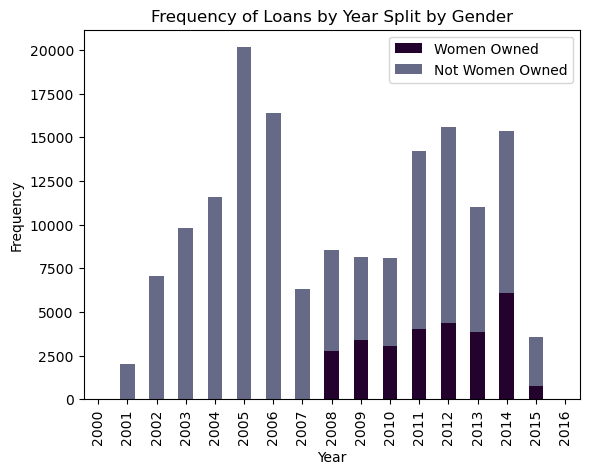

In [93]:
# group the data by 'year' and 'Is Woman Owned?', and calculate the count of each group
counts = df.groupby(['year', 'Is Woman Owned?'])['Is Woman Owned?'].count().unstack()

# add columns with proper names
counts['Women Owned'] = counts[1.0]
counts['Not Women Owned'] = counts[0.0]
counts = counts[['Women Owned', 'Not Women Owned']]

# plot a stacked bar chart of the frequency of 'Is Woman Owned?' by 'year'
counts.plot(kind='bar', stacked=True, color = ['#23022E','#666A86'])

# set the plot title and axis labels
plt.title('Frequency of Loans by Year Split by Gender')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend().set_title('')

# display the plot
plt.show()

Above we have the number of loans in our dataset plotted by year. split by gender of the owner of the business. Note that the year 2000 and 2016 seem to have no loans, but there are actually 4 and 5 loans in total respectively. The DCA's most active year seems to be 2005. 

The data that sticks out is that prior to 2008, no loans went to women. Looking closer at the actual data in 2006, 4 loans went to women, but otherwise no loans went to women from 2000-2007. This phenomenon is quite strange. It does not seem plausible that from 2000-2007, which represents about half of the dataset, no loans went to women (other than the 4). Unless there was some policy actively preventing women from receiving loans during that time, the most plausible explanation is that prior to 2008, whether the loan was given to a women entrepreneur was not recorded (properly). And given our dataset's tendency to record missing values as 0.0, this implies these values are actually missing.

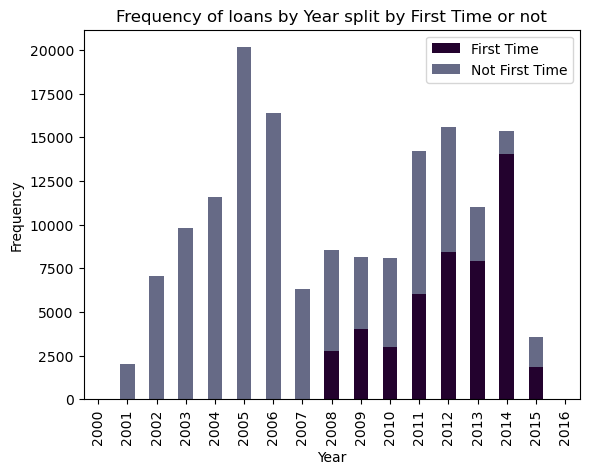

In [94]:
# group the data by 'year' and 'Is First Time Borrower?', and calculate the count of each group
counts = df.groupby(['year', 'Is First Time Borrower?'])['Is First Time Borrower?'].count().unstack()

# add columns with proper names
counts['First Time'] = counts[1.0]
counts['Not First Time'] = counts[0.0]
counts = counts[['First Time', 'Not First Time']]

# plot a stacked bar chart of the frequency of 'Is First Time Borrower?' by 'year'
counts.plot(kind='bar', stacked=True, color = ['#23022E','#666A86'])

# set the plot title and axis labels
plt.title('Frequency of loans by Year split by First Time or not')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend().set_title('')

# display the plot
plt.show()

Above we plotted a similar diagram, but using the "Is First Time Borrower?" column, and it further supports our previous result. We see a similar strange result that prior to 2008, basically no loans (in reality only 3) went to first time borrowers. For the same reasons as before, it does not seem plausible that no loans went to first time borrowers prior to 2008. 

We can almost be certain that something funny is going on with the data for the "Is Woman Owned?" and "Is First Time Borrower?" prior to 2008. In fact in 2012, "the DCA rewrote its evaluation methodology to include indicators that track impacts on borrowers, including indicators on gender and first-time borrowers" (OECD, 2016). Although this does not match the data in the data, one explanation is that the indicators were recorded staring in 2008, so that in 2012 it could be used in the evaluation methodology. Regardless, this proves that gender and first-time borrower indicators were not part of the original program, which further supports why values prior to 2008 should be recorded as missing.

In [95]:
mask = (df['year'] >= 2000) & (df['year'] <= 2007) # Only want replace years from 2000-2007
df.loc[mask, ['Is Woman Owned?', 'Is First Time Borrower?']] = np.nan 

So, above we defined a mask to filter rows for where the year is from 2000-2007. Then we recorded all values in the problematic columns as missing, so it does not affect our later analysis.

### 'Amount (USD)'

We will begin by cleaning our 'Amount (USD)' column ($Y$ variable) which represents the loan amount recorded in USD.

In [96]:
print(df['Amount (USD)'].min())  #There is some bad data since it does not make sense to have a loan of 0

0.0


Notice that some loan amounts were recorded as 0. This does not make any sense since a loan should be a positive amount. Thus, we will define a function to delete these entries so that it does not affect our analysis later.

In [97]:
def clean_zeros(df: pd.core.frame.DataFrame, col_index: str) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values that are 0 in the given column at col_index replaced with np.nan"""
    for i in range(len(df.index)):
        if df.loc[i, col_index] == 0:
            df.loc[i, col_index] = np.nan
    return df

In [98]:
df = clean_zeros(df, 'Amount (USD)')
print(df['Amount (USD)'].min())  #Notice there are still some really small loan amounts
print(len(df[df['Amount (USD)'].isnull()]))

0.0025
6


Notice there are still some really small loan amounts and we lost 6 entries through this process.

### 'Is Woman Owned?' & 'Is First Time Borrower?'

Now we will clean the columns that should have binary entries ($X$ variable). 
- 'Is Woman Owned?' records whether or not the business-owner that took out the loan identifies as a Woman or Man.
- 'Is First Time Borrower?' records whether or not the business that took out the loan is a first time borrower from a bank.

In [99]:
print(df['Is Woman Owned?'].max()) #There is some bad data in our columns that isn't 0 or 1
print(df['Is First Time Borrower?'].max()) #There is some bad data in our columns that isn't 0 or 1

21566.0
390.0


However, our data seems to have some non-boolean values.

In [100]:
def clean_non_binary(df: pd.core.frame.DataFrame, col_index: str) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values not 0 or 1 in the given column at col_index replaced with np.nan"""
    for i in range(len(df.index)):
        if df.loc[i, col_index] != 0 and df.loc[i, col_index] != 1:
            df.loc[i, col_index] = np.nan
    return df
df = clean_non_binary(df, 'Is Woman Owned?')
df = clean_non_binary(df, 'Is First Time Borrower?')
print(df['Is Woman Owned?'].min(), df['Is Woman Owned?'].max())
print(df['Is First Time Borrower?'].min(), df['Is First Time Borrower?'].max())

0.0 1.0
0.0 1.0


So we will define a function that deletes any values that are not 0 or 1. Problem Solved.

### 'Business Size' & 'Business Sector'

Moving on to 'Business Size' and 'Business Sector', we will need to check if the entries make sense. 

While the exact meaning of 'Business Size' is unclear in the dataset documentation, we can reasonably assume higher numbers are bigger businesses. A likely interpretation is that the entry represents the number of employees. 'Business Sector' is simply a label of which sector the business is in.

In [101]:
print('Business Size Unique Entries:')
for item in df['Business Size'].unique():
    print(item, '', end='')
print('\n')
print('Business Sector Unique Entries:')
for item in df['Business Sector'].unique():
    print(item, '', end='')

Business Size Unique Entries:
>100 nan 11--50 1--5 6--10 51--100 

Business Sector Unique Entries:
nan Trade/Commerce Manufacturing Other Service Agriculture Health Education Transportation Information & Communication Technologies Fisheries/Aquaculture Construction Housing Forestry/Wood Energy Tourism Infrastructure 

Using the built-in .unique() method on 'Business Size' and 'Business Sector', we can see that all the values make sense, so no cleaning is necessary. The entry nan means that some entries are missing, which will will keep in mind for later.

### 'Guarantee Country Name' & 'Region Name'

##### Part I: Recovering the entry 'Worldwide', in 'Guarantee Country Name'

The column 'Guarantee Country Name' refers to the name of the country the loan was issued to.

In [102]:
len(df[df['Guarantee Country Name'] == 'Worldwide'])

155

However, a quick look at the dataset's unique entries reveals that some entries were denoted as 'Worldwide'. 155 entries have this issue.

Thankfully, we can recover most of this information using what is available in the other columns:
- 'State/Province/Region Country Name'
- 'Currency Name'
- 'City/Town'

Below we briefly sketch out the details of this process.

In [103]:
def change_worldwide(df: pd.core.frame.DataFrame, col_index: str) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values that are 'Worldwide' in 'Guarantee Country Name' replaced with value at col_index"""
    for i in list(df.index):
        if df.loc[i, 'Guarantee Country Name'] == 'Worldwide' and type(df.loc[i, col_index]) == str: 
            df.loc[i, 'Guarantee Country Name'] = df.loc[i, col_index]
    return df

df = change_worldwide(df, 'State/Province/Region Country Name')

**Step 1:** Using "State/Province/Region Country Name", which also contains entries of the country name, we defined a function that replaces all entries that contain 'Worldwide' with the name at this other column (if it exists).

In [104]:
d = {'PERU - NUEVO SOL': 'Peru', 'BOLIVIA - BOLIVIANO': 'Bolivia',
     'TANZANIA - SHILLING': 'Tanzania', 'SENEGAL - CFA FRANC': 'Senegal',
     'MOLDOVA - LEU': 'Moldova', 'UGANDA - SHILLING': 'Uganda',
     'TOGO - CFA FRANC': 'Togo', 'BENIN - CFA FRANC': 'Benin',
     'MALI - CFA FRANC': 'Mali', 'RWANDA - FRANC': 'Rwanda',
     'PHILIPPINES - PESO': 'Philippines', "COTE D'IVOIRE - CFA FRANC": "Côte d'Ivoire",
     'CAMEROON - CFA FRANC': 'Cameroon', 'BURKINA FASO - CFA FRANC': 'Burkina',
     'GHANA - CEDI': 'Ghana'}

def change_worldwide_currency(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values that are 'Worldwide' to the proper name with according to the currency"""
    for i in list(df.index):
        if df.loc[i, 'Guarantee Country Name'] == 'Worldwide' and type(
            df.loc[i, 'Currency Name']) == str and df.loc[i, 'Currency Name'] in d:
            df.loc[i, 'Guarantee Country Name'] = d[df.loc[i, 'Currency Name']]
    return df

df = change_worldwide_currency(df)

**Step 2**: We recovered some information using the 'Currency Name' column. Note that we will exclude the entries 'UNITED STATES - DOLLAR' and 'EURO ZONE - EURO' since the United States should not be receiving its own foreign aid, and Euro Zone is not a country. 

We manually made a dictionary from currencies to country names of the 60 rows that remain. Then, we  created a function that uses this dictionary to replace countries according what is in the 'Currency Name' column.

In [105]:
d = {'Lima': 'Peru', 'Guatemala City': 'Guatemala', 'Alta Floresta': 'Brazil', 
     'Fort Collins': 'United States', 'New York': 'United States', 'Delaware': 'United States',
     'Black River': 'Jamaica', 'Kenya': 'Kenya', 'La Libertad ': 'El Salvador',
     'Njombe': 'Tanzania', 'Ducis': np.nan, 'Wa': np.nan,
     'San Francisco': 'United States', 'Nairobi': 'Kenya'}

def change_worldwide_city(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values that are 'Worldwide' to the proper name with according to the city/town name"""
    for i in list(df.index):
        if df.loc[i, 'Guarantee Country Name'] == 'Worldwide' and type(
            df.loc[i, 'City/Town']) == str and df.loc[i, 'City/Town'] in d:
            df.loc[i, 'Guarantee Country Name'] = d[df.loc[i, 'City/Town']]
    return df

df = change_worldwide_city(df)

**Step 3** Finally we manually recovered some information using the in the 'City/Town' column. We created a dictionary mapping from these towns to the country using a simple Google search. Strangely, we see a few cities in the US. Also 'Ducis' and 'Wa' are unknown, so those entries are unrecoverable and were recorded as missing instead. Note this means we lost 2 entries.

We created a function that is almost identical to the previous function using this dictionary to change entries that contain 'Worldwide' to the value that we can infer from the city.

In [106]:
print(len(df[df['Guarantee Country Name'] == 'Worldwide']))

12


The 12 entries we have left that say 'Worldwide' are unfortunately unrecoverable.

In [107]:
def change_worldwide_city_1(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values that are 'Worldwide' deleted"""
    for i in list(df.index):
        if df.loc[i, 'Guarantee Country Name'] == 'Worldwide':
            df.loc[i, 'Guarantee Country Name'] = np.nan
    return df

df = change_worldwide_city_1(df)

We do not want to have 'Worldwide' denoted as a country in our later analysis so all that there is to do is to delete these 12 entries. Recall we deleted 2 entries earlier, so 14 entries are lost in this cleaning process.

In [108]:
len(df[df['Guarantee Country Name'] == 'Worldwide'])

0

All are entries are now clean.

##### Part II: Recovering the entry 'Africa Region Funded Activities', in 'Guarantee Country Name'

Many entries under the same column were denoted 'Africa Region Funded Activities' and 'West Africa' which are not countries. We will recover some of these countries names using similar techniques as Part I.

In [109]:
print(len(df[df['Guarantee Country Name'] == 'Africa Region Funded Activities']))
print(len(df[df['Guarantee Country Name'] == 'West Africa']))

73
159


73 and 159 entries have this issue.

In [110]:
def change_africa(df: pd.core.frame.DataFrame, col_index: str) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values that are 'Africa Region Funded Activities' in 'Guarantee Country Name' replaced with value at col_index"""
    for i in list(df.index):
        if df.loc[i, 'Guarantee Country Name'] == 'Africa Region Funded Activities' and type(df.loc[i, col_index]) == str: 
            df.loc[i, 'Guarantee Country Name'] = df.loc[i, col_index]
    return df

df = change_africa(df, 'State/Province/Region Country Name')

In [111]:
def change_west_africa(df: pd.core.frame.DataFrame, col_index: str) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values that are 'West Africa' in 'Guarantee Country Name' replaced with value at col_index"""
    for i in list(df.index):
        if df.loc[i, 'Guarantee Country Name'] == 'West Africa' and type(df.loc[i, col_index]) == str: 
            df.loc[i, 'Guarantee Country Name'] = df.loc[i, col_index]
    return df

df = change_west_africa(df, 'State/Province/Region Country Name')

In [112]:
d = {'COMMUNE DE LEO': 'Burkina Faso', 'LEO': 'Burkina Faso', 'LEO ': 'Burkina Faso', 'COMMUNIE DE LEO': 'Burkina Faso', 
     'DIAPAGA': 'Burkina Faso', 'KAYA': 'Burkina Faso', 'NOUNA': 'Burkina Faso',
     'OUAGADOUGOU': 'Burkina Faso', 'Ouagadougou': 'Burkina Faso', 'POUYTENGA': 'Burkina Faso',
     'Pouytenga': 'Burkina Faso', 'TENKODOGO': 'Burkina Faso', 'ORODARA': 'Burkina Faso',
     'Niger': 'Niger', 'OUAYIGOUYA': 'Burkina Faso', 'NIAMEY': 'Niger', 
     'Bagre': 'Burkina Faso', 'BAGRE': 'Burkina Faso', 'BOBO-DIOULASSO': 'Burkina Faso'}

def change_west_africa_city(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Return a DataFrame with the values that are 'West Africa' to the proper name with according to the city/town name"""
    for i in list(df.index):
        if df.loc[i, 'Guarantee Country Name'] == 'West Africa' and type(
            df.loc[i, 'City/Town']) == str and df.loc[i, 'City/Town'] in d:
            df.loc[i, 'Guarantee Country Name'] = d[df.loc[i, 'City/Town']]
    return df

df = change_west_africa_city(df)
df.loc[142309, 'Guarantee Country Name'] = 'Burkina Faso'

In [113]:
print(len(df[df['Guarantee Country Name'] == 'Africa Region Funded Activities']))
print(len(df[df['Guarantee Country Name'] == 'West Africa']))

9
50


Our data is much cleaner now, though note a few entries were not cleaned. Unlike the previous part, we will still keep these entries since this data will be valuable for statistics by Region.

##### Part III: Sorting 'Guarantee Country Name' to 'Region Name'

Since there are so many countries that is in our data set, it makes sense to further categorize our data into bigger groups.

In [114]:
print('Region Name Unique Entries:')
for item in df['Region Name'].unique():
    print(item, ' ', end='')

Region Name Unique Entries:
LATIN AMERICA & THE CARIBBEAN  nan  AFRICA  EUROPE & EURASIA  ASIA  MIDDLE EAST  

There actually already exists a column 'Region Name' that does this for us. Notice how there are only a few regions, which is perfect.

In [115]:
len(df[df['Region Name'].isnull()]) #40997 rows have NaN in 'Region Name'

40997

These categories are more general, yet unfortunately many entries are missing.

In [116]:
def create_dictionary(df: pd.core.frame.DataFrame) -> dict:
    """Creates a dictionary mapping from country name to region with the entries we have filled"""
    output = {}
    for i in list(df.index):
        region_name = df.loc[i, 'Region Name']
        country_name = df.loc[i, 'Guarantee Country Name']
        if type(region_name) == str:
            if country_name not in output:
                output[country_name] = region_name
            else:
                if region_name != output[country_name]:
                    return False
    return output

Luckily we have cleaned the data in the 'Guarantee Country Name' column, so it should be straightforward to get the region from this column. We have many entries that do have both columns filled, so we used that first to create a dictionary mapping from country name to region.

In [117]:
country_to_region = create_dictionary(df)
manual_countries = ['United States', 'Brazil', 'Botswana', 'Bolivia', 'East Africa', "Côte d'Ivoire", 'Cameroon',
                    'West Africa', 'Africa Region Funded Activities', 'Romania']
manual_regions = ['NORTH AMERICA', 'LATIN AMERICA & THE CARIBBEAN', 'AFRICA', 'LATIN AMERICA & THE CARIBBEAN',
               'AFRICA', 'AFRICA', 'AFRICA', 'AFRICA', 'AFRICA', 'EUROPE & EURASIA']
country_to_region = country_to_region|dict(zip(manual_countries, manual_regions))

In [118]:
def recover_region(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    for i in list(df.index):
        region_name = df.loc[i, 'Region Name']
        country_name = df.loc[i, 'Guarantee Country Name']
        if type(region_name) != str:
            if country_name in country_to_region:
                df.loc[i, 'Region Name'] = country_to_region[country_name]
    return df

df = recover_region(df)

Some countries was not created by this function, so we can manually entered them in. Notice 'NORTH AMERICA' is now a new region to deal with the loans in the United States we recovered. Using this dictionary, we can use it to recover region names based off country names.

In [119]:
len(df[df['Region Name'].isnull()]) 

14

Only 14 are missing, which is expected since we lost 14 entries in the process of cleaning 'Guarantee Country Name'.

##### Part IV: Sorting 'Guarantee Country Name' to 'ISO_Code'

In [120]:
import pycountry

In [121]:
def get_iso_code(country):
    try:
        return pycountry.countries.get(name=country).alpha_3
    except:
        return None

df['ISO_Code'] = df['Guarantee Country Name'].apply(get_iso_code)

The standard way to refer to countries in other datasets is using the ISO country codes. The module `pycountry` has a built in function to get the ISO code given a country name. We will take advantage of to add a column of corresponding ISO country codes based off of the Guarantee Country Name.

In [122]:
d = {'Vietnam': 'VNM', 'Moldova': 'MDA', 'Kosovo': 'XK',
    'Democratic Republic of the Congo': 'COD', 'Bolivia': 'BOL', 'Russia': 'RUS', 'Tanzania': 'TZA',
    'Macedonia': 'MKD', 'Swaziland': 'SWZ', 'Bosnia Herzegovina': 'BIH', 'Ivory Coast': 'CIV'}

def recover_iso(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    for i in list(df.index):
        iso = df.loc[i, 'ISO_Code']
        country_name = df.loc[i, 'Guarantee Country Name']
        if iso is None:
            if country_name in d:
                df.loc[i, 'ISO_Code'] = d[country_name]
    return df

df = recover_iso(df)

Otherwise, we use a similar strategy as previous data cleaning to manually recover ISO codes from country name.

### Summary of Data Cleaning

Phew! That was a lot of data cleaning. To summarize this is what happened to our DataFrame in this process:
- 'Amount (USD)': Entries that were zero were deleted, we lost 6 entries to this
- 'Is Woman Owned?' & 'Is First Time Borrower?': Non-binary entries and all values prior to 2008 were deleted. 
- 'Business Size' & 'Business Sector': Checked the entries if they made sense. And yes they did, so no cleaning needed
- 'Guarantee Country Name' & 'Region Name': 
    - 'Guarantee Country Name': Fixed all entries that said 'Worldwide' with info from other columns, deleted what was unrecoverable. Lost 14 entries. Also changed the majority of entries that said 'West Africa' & 'Africa Region Funded Activities' to be the actual countries.
    - 'Region Name': Used 'Guarantee Country Name' to recover 'Region Name' in empty cells. Gained 40,983 entries!
- 'ISO_Code': Added this new column which will come in handy when merging with other datasets
    
We have cleaned all our dependent ('Amount (USD)') and independent variables so we are ready to analyze! 

## Summary Statistics Tables

To familiarize ourselves with the $X$ and $Y$ variables, we will organize the summary stats for our variables into a dataframe.

In [123]:
from stargazer.stargazer import Stargazer

In [124]:
d = {'Amount (USD)': df['Amount (USD)'].describe(), 'Is First Time Borrower?': df['Is First Time Borrower?'].describe(),
    'Is Woman Owned?': df['Is Woman Owned?'].describe()}
info = pd.DataFrame(d)
info.loc['sum'] = [df['Amount (USD)'].sum(), df['Is First Time Borrower?'].sum(), df['Is Woman Owned?'].sum()]
info['Amount (USD)'] = info['Amount (USD)'].apply(lambda x: '{:.0f}'.format(x))
info['Is First Time Borrower?'] = info['Is First Time Borrower?'].apply(lambda x: '{:.3f}'.format(x))
info['Is Woman Owned?'] = info['Is Woman Owned?'].apply(lambda x: '{:.3f}'.format(x))
info

Amount (USD) Is First Time Borrower? Is Woman Owned?
count       163789               90472.000       90470.000
mean         11603                   0.547           0.320
std         303714                   0.498           0.466
min              0                   0.000           0.000
25%            487                   0.000           0.000
50%            981                   1.000           0.000
75%           2142                   1.000           1.000
max       80600000                   1.000           1.000
sum     1900485694               49522.000       28947.000

The first column shows the summary statistics for our $Y$ Variable: Loan Amount. 
- In total 1.9 Billion USD in loans were backed by this program (note this does not mean that 1.9 Billion Dollars were spent).
- The average (mean) loan was about 12,000 (USD). However half of the loans were under 1,000 (median/50%). This indicates that most loans were small, but a few were much larger skewing the average.
- The smallest loan was less than a penny (rounded to 0). The largest loan was just over 80 Million. There is a very large standard deviation (300,000) which is expected since loan needs vary dramatically between businesses.

This second column shows the summary statistics for the $X$ Variable: First Time Borrower. Recall "1" means it is a first time borrower. Remember data for this statistic is only available for 2008 and after.
- 54.7% of loans made in the program were to first time borrower
- This translates to just under 50,000 first time borrowers reached by this program. 
- This is of special importance since the DCA aims to encourage banks to lend to businesses that are typically disregarded by the banking system.

This last column shows the summary statistics for the $X$ Variable: Gender of Loanee. Recall "1" means it is owned by a woman. Data for this statistic is only available for 2008 and after. 
- Only 32.0% of loans made in the program were to women entrepreneurs. Only 29,000 out of 90,000 loans under the program (2008 and after) were to women.
- This likely reflects the systemic and cultural barriers that women face in entrepreneurship, especially in developing countries. If the DCA aims to move the needle on providing women with fair and equitable opportunities in entrepreneurship, understanding and improving this statistic will be key. Further in depth discussion and exploration on this issue are in the following sections.

In [125]:
d = {'Region Name': df['Region Name'].describe(), 'Business Sector': df['Business Sector'].describe(),
    'Business Size': df['Business Size'].describe()}
pd.DataFrame(d)

Region Name Business Sector Business Size
count                          163781          155932         31069
unique                              6              15             5
top     LATIN AMERICA & THE CARIBBEAN     Agriculture          1--5
freq                           126784           62818         26770

This first column shows the summary statistics for the $X$ Variable: Region Name.
- The most common loan was to businesses in the Latin America region, accounting for 77.4% of loans.
- 5 other regions in the dataset are: Asia, Africa, Europe & Eurasia, Middle East, North America* (in order of highest to lowest appearances).

*North America was added in the "Data Cleaning/Loading" section for completeness of the data for this variable

This second column shows the summary statistics for the $X$ Variable: Business Sector.
- The most common loan was to an Agriculture business, accounting for 40.3% of loans.
- 14 business sectors are in the dataset. Besides Agriculture, the 2 most common loans were to businesses in Trade/Commerce and Manufacturing.
- Given that the DCA operates in developing regions, these results are unsurprising since economies in those regions tend to be agriculture-based.

This last column shows the summary statistics for the $X$ Variable: Size of Business. We will interpret the entry 1--5 as a business with one to five employees (i.e. a very small business).
- Of the data available, 86.2% of the business were very small business with under 5 employees.
- The next most frequent loans were made to business with 6--10 and 11--50 employees, indicating that the program lends disproportionately to small/medium sized businesses.
- Recall this is of interest since small business are typically disregarded by the banking system, which is the gap that the DCA aims to bridge.

## Plots, Histograms, Figures

In this section we will analyze the relationship between our 5 $X$ variables with our $Y$ variable (Loan Amount). In the Gender of Borrower section, we take this one step further and group the gender with our other variables find the distribution of covariates.

### Region Name

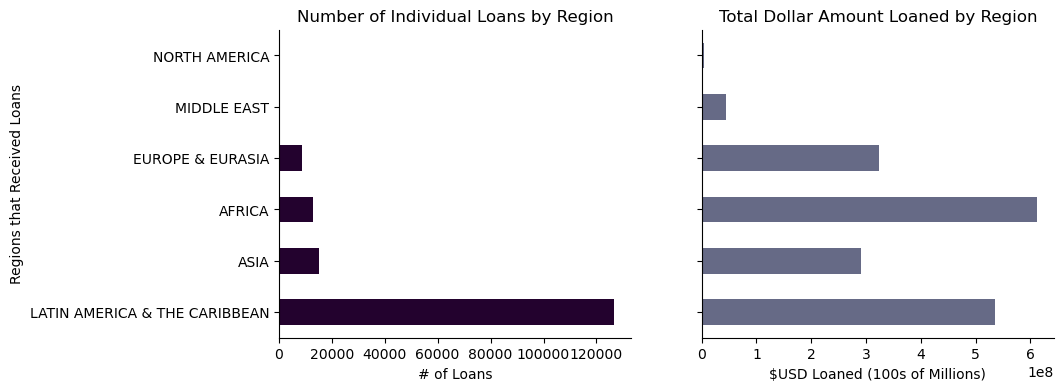

In [126]:
df1 = df['Region Name'].value_counts()
df1 = df1.sort_values(ascending = False)

df2 = df.get(['Region Name', 'Amount (USD)'])
df2 = df2.pivot(columns = 'Region Name')  # Pivot so that the columns are now Region Name
df2.columns = df2.columns.droplevel(0)
df2 = df2.sum()
df2 = df2.iloc[1:]
df2 = df2[df1.index]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

df1.plot(kind="barh", ax=ax[0], color="#23022E")
df2.plot(kind="barh", ax=ax[1], color="#666A86")

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("Number of Individual Loans by Region")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("Total Dollar Amount Loaned by Region")
ax[0].set_ylabel('Regions that Received Loans')
ax[0].set_xlabel('# of Loans')
ax[1].set_xlabel('$USD Loaned (100s of Millions)')
plt.show()

On the left, we see that businesses in Latin America by far are the most frequent receiver of loans backed by the DCA. Yet on the right, Africa are ahead of Latin America in the total dollar amount of loans received. This means that the average loan size in Latin America is much smaller than the other countries.

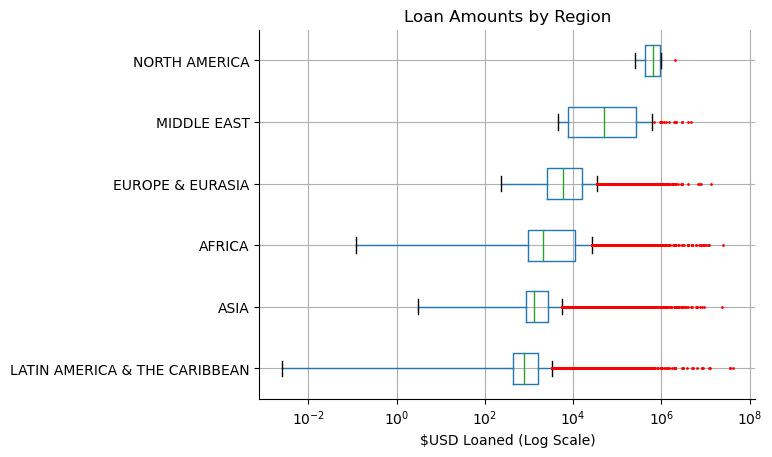

In [127]:
df1 = df.get(['Region Name', 'Amount (USD)'])
df1 = df1.pivot(columns = 'Region Name')
df1.columns = df1.columns.droplevel(0)
df1 = df1.iloc[:, 1:]
df1 = df1[['LATIN AMERICA & THE CARIBBEAN', 'ASIA', 'AFRICA', 'EUROPE & EURASIA', 'MIDDLE EAST', 'NORTH AMERICA']]

fig, ax = plt.subplots()
plt.xscale("log") 

df1.boxplot(vert=False, flierprops={'markersize': 1, 'markerfacecolor': 'red', 'markeredgecolor': 'r'})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Loan Amounts by Region')
ax.set_xlabel('$USD Loaned (Log Scale)')
plt.show()

We plotted a box plot of the Loan Amounts categorized by region. Note a log scale was used to fit everything on a graph. 

Indeed we see that Latin America's median loan amount is the lowest of all the Regions in our dataset. In fact, it seems that countries that receive fewer number of loans have higher median loan amounts! This potentially can be explained by each region's specific needs for loans due to the current economic circumstances, but more data is needed to explain any causation effects.

Also, notice the significant number of outliers on the right-hand side of our plot. This matches our earlier discovery that the average loan (mean) is much higher than the median loan amount. So, most loans were small, but a few were much larger skewing the average.

Overall, the region seems to have a significant impact on the loan amount received by the program.

### Business Sector

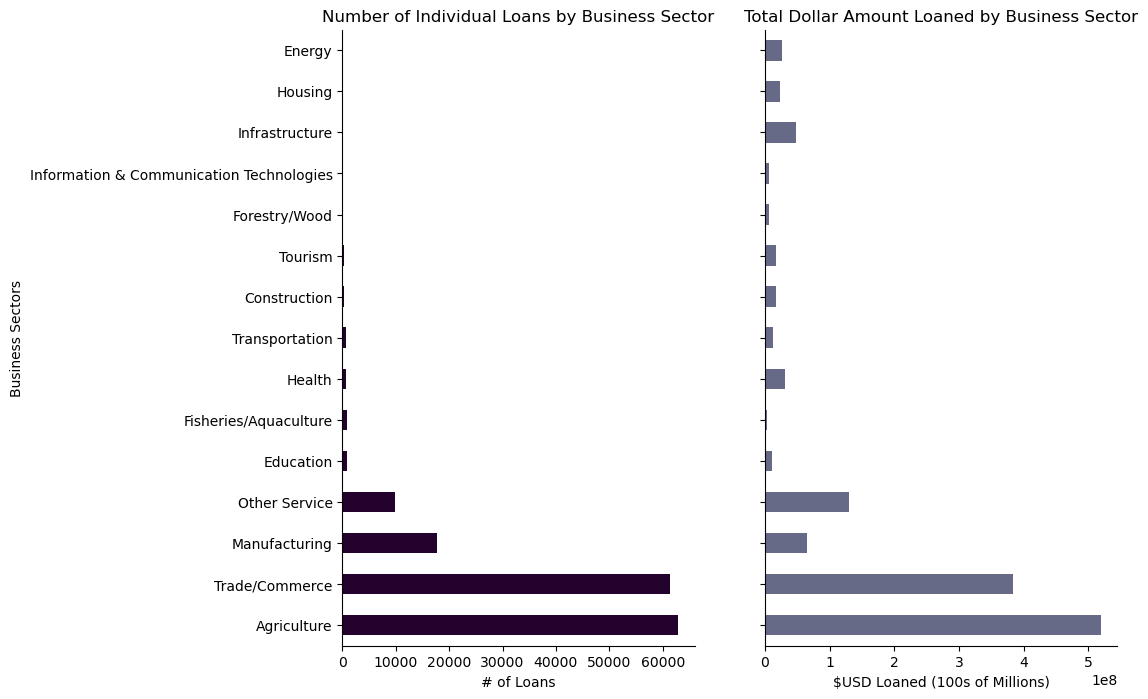

In [128]:
df1 = df['Business Sector'].value_counts()
df_special = df1.copy()

df2 = df.get(['Business Sector', 'Amount (USD)'])
df2 = df2.pivot(columns = 'Business Sector')
df2.columns = df2.columns.droplevel(0)
df2 = df2.sum()
df2 = df2.iloc[1:]
df2 = df2[df1.index]

fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

df1.plot(kind="barh", ax=ax[0], color="#23022E")
df2.plot(kind="barh", ax=ax[1], color="#666A86")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("Number of Individual Loans by Business Sector")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("Total Dollar Amount Loaned by Business Sector")
ax[0].set_ylabel('Business Sectors')
ax[0].set_xlabel('# of Loans')
ax[1].set_xlabel('$USD Loaned (100s of Millions)')
plt.show()

On the left, we see that businesses in the Agriculture and Trade/Commerce sector by far are the most frequent receiver of loans backed by the DCA. However on the right, many of the less frequent loan sectors such as Energy, Housing, and Infrastructure receive a disproportionate amount of loan dollars.

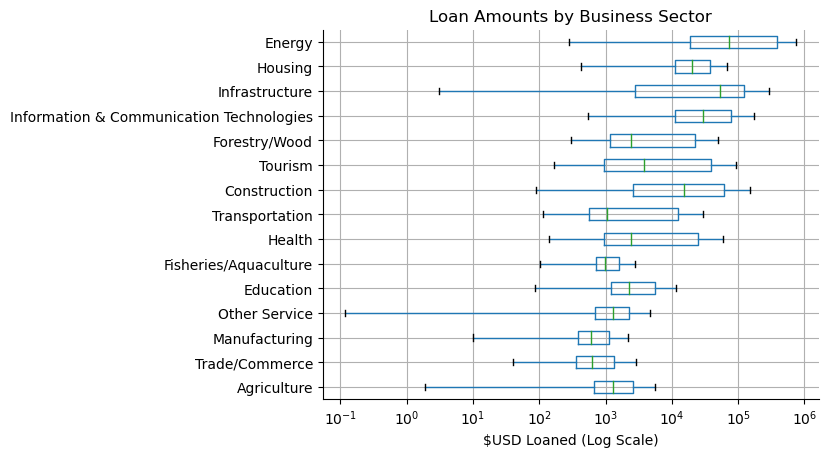

In [129]:
fig, ax = plt.subplots()

df3 = df.get(['Business Sector', 'Amount (USD)'])
df3 = df3.pivot(columns = 'Business Sector')
df3.columns = df3.columns.droplevel(0)
df3 = df3.iloc[:, 1:]
df3 = df3[df1.index]
plt.xscale("log") 

df3.boxplot(vert=False, showfliers=False)
ax.set_xticks([], minor=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Loan Amounts by Business Sector')
ax.set_xlabel('$USD Loaned (Log Scale)')
plt.show()

We plotted a box plot of the Loan Amounts categorized by region. Note a log scale was used. Outliers are hidden to reduce visual clutter.

Indeed we see that Energy, Housing, and Infrastructure sectors have the highest median loan amounts in our dataset. In fact, again we see a negative correlation between the frequency of a specific loan to a sector and the median loan amount. Frequent loans to Agriculture, Trade/Commerce, and Manufacturing tend to be the lowest amounts.

Overall, the business sector seems to have a significant impact on the loan amount received by the program.

### Business Size

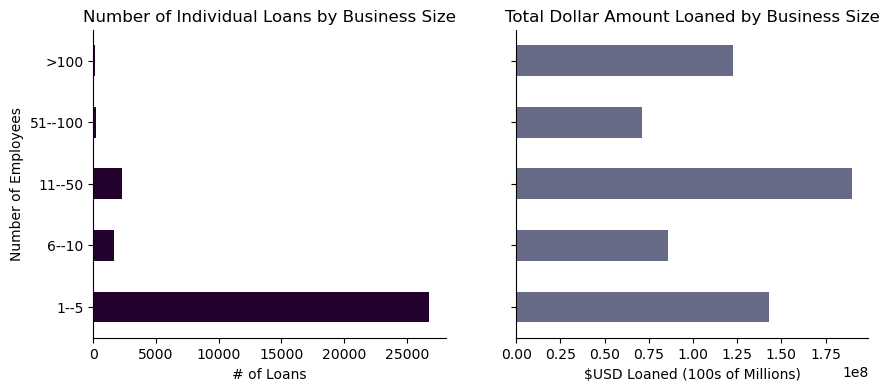

In [130]:
df1 = df['Business Size'].value_counts()
df1 = df1.reindex(['1--5', '6--10', '11--50', '51--100', '>100'])

df2 = df.get(['Business Size', 'Amount (USD)'])
df2 = df2.pivot(columns = 'Business Size')  # Pivot so that the columns are now Business Sector
df2.columns = df2.columns.droplevel(0)
df2 = df2.sum()
df2 = df2.iloc[1:]
df2 = df2[df1.index]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

df1.plot(kind="barh", ax=ax[0], color="#23022E")
df2.plot(kind="barh", ax=ax[1], color="#666A86")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("Number of Individual Loans by Business Size")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("Total Dollar Amount Loaned by Business Size")
ax[0].set_ylabel('Number of Employees')
ax[0].set_xlabel('# of Loans')
ax[1].set_xlabel('$USD Loaned (100s of Millions)')
plt.show()

Very small businesses received the most number of loans, but unsurprisingly bigger businesses received a higher dollar amount per loan on average.

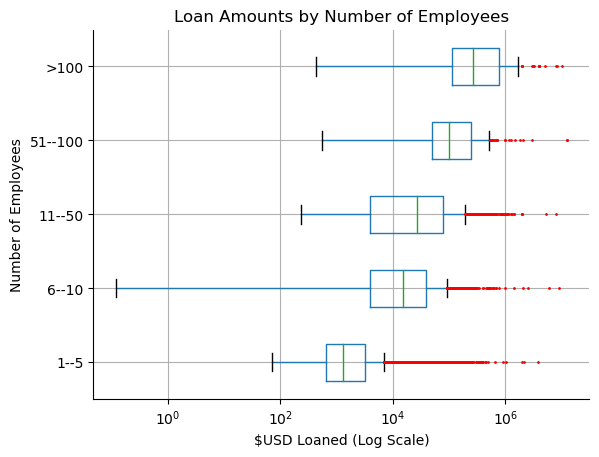

In [131]:
df1 = df.get(['Business Size', 'Amount (USD)'])
df1 = df1.pivot(columns = 'Business Size') 
df1.columns = df1.columns.droplevel(0)
df1 = df1.iloc[:, 1:]
df1 = df1[['1--5', '6--10', '11--50', '51--100', '>100']]

fig, ax = plt.subplots()
plt.xscale("log") 


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Loan Amounts by Number of Employees')
ax.set_ylabel('Number of Employees')
df1.boxplot(vert=False, flierprops={'markersize': 1, 'markerfacecolor': 'red', 'markeredgecolor': 'r'})
ax.set_xlabel('$USD Loaned (Log Scale)')
plt.show()

We plotted a box plot of the Loan Amounts categorized by Business Size. Note a log scale was used to fit everything on a graph.

Indeed we see that larger business have higher median loan amounts which matches our earlier visual.

Overall, the business size seems to have a significant impact on the loan amount received by the program.

### First Time Borrower

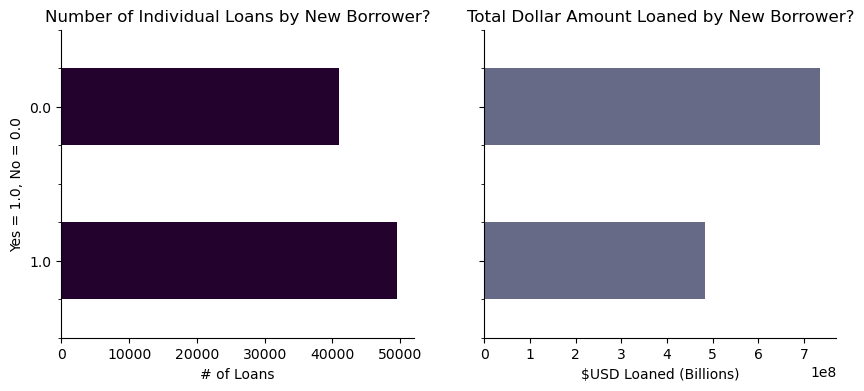

In [132]:
df1 = df['Is First Time Borrower?'].value_counts()

df2 = df.get(['Is First Time Borrower?', 'Amount (USD)'])
df2 = df2.pivot(columns = 'Is First Time Borrower?') 
df2.columns = df2.columns.droplevel(0)
df2 = df2.sum()
df2 = df2.iloc[1:]
df2 = df2[df1.index]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

df1.plot(kind="barh", ax=ax[0], color="#23022E")
df2.plot(kind="barh", ax=ax[1], color="#666A86")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("Number of Individual Loans by New Borrower?")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("Total Dollar Amount Loaned by New Borrower?")
ax[0].set_ylabel('Yes = 1.0, No = 0.0')
ax[0].set_xlabel('# of Loans')
ax[1].set_xlabel('$USD Loaned (Billions)')
plt.show()

In [133]:
print(f'Percentage of Loans: {(df1[1.0] / df1.sum() * 100).round(1)}')
print(f'Percentage of Loans Dollars: {(df2[1.0] / df2.sum() * 100).round(1)}')

Percentage of Loans: 54.7
Percentage of Loans Dollars: 39.7


As discussed previously, new borrowers accounted for slightly more than half (54.7%) of the loans made out by the DCA. However it seems like on average, they received slightly less than former borrowers, accounting for a smaller proportion (39.7%) of the total amount of the loans paid.

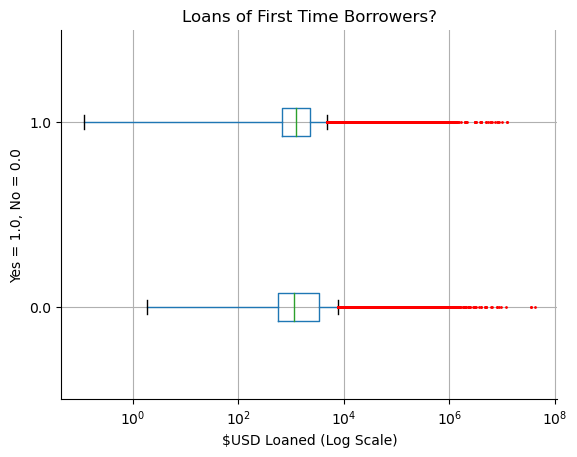

In [134]:
fig, ax = plt.subplots()
df1 = df.get(['Is First Time Borrower?', 'Amount (USD)'])
df1 = df1.pivot(columns = 'Is First Time Borrower?')  
df1.columns = df1.columns.droplevel(0)
df1 = df1.iloc[:, 1:]
plt.xscale("log") 

df1.boxplot(vert=False, showfliers=True, flierprops={'markersize': 1, 'markerfacecolor': 'red', 'markeredgecolor': 'r'})
ax.set_ylabel('Yes = 1.0, No = 0.0')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([], minor=True)
ax.set_title('Loans of First Time Borrowers?')
ax.set_xlabel('$USD Loaned (Log Scale)')
plt.show()

We plotted a box plot of the Loan Amounts categorized by whether the borrower was a first time borrower or not. Note a log scale was used to fit everything on a graph.

Indeed it seems like the first time borrowers receive slightly less than non-first time borrowers. Notice that the box and whiskers of the plot for first time borrowers are to the left of (smaller than) non-first time borrowers. 

Overall this effect seems quite small. It is likely that this effect is a spurious relationship (e.g. first time borrowers have smaller business which is the true cause of smaller loans). We will explore this in later regression sections.

### Gender of Borrower

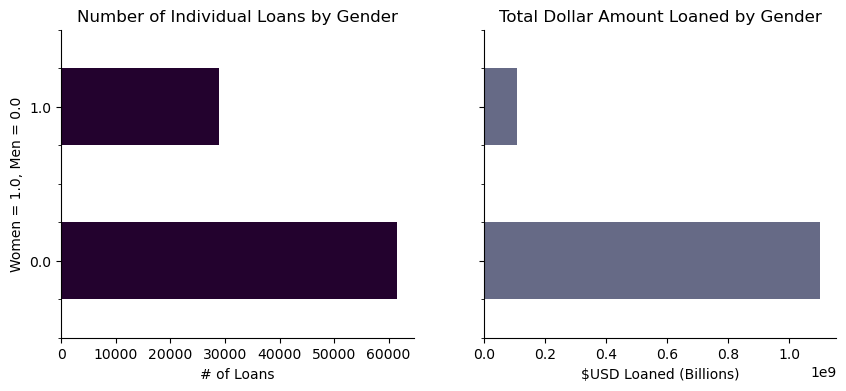

In [135]:
df1 = df['Is Woman Owned?'].value_counts()

df2 = df.get(['Is Woman Owned?', 'Amount (USD)'])
df2 = df2.pivot(columns = 'Is Woman Owned?') 
df2.columns = df2.columns.droplevel(0)
df2 = df2.sum()
df2 = df2.iloc[1:]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

df1.plot(kind="barh", ax=ax[0], color="#23022E")
df2.plot(kind="barh", ax=ax[1], color="#666A86")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("Number of Individual Loans by Gender")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title("Total Dollar Amount Loaned by Gender")
ax[0].set_ylabel('Women = 1.0, Men = 0.0')
ax[0].set_xlabel('# of Loans')
ax[1].set_xlabel('$USD Loaned (Billions)')
plt.show()

In [136]:
print(f'Percentage of Loans: {(df1[1.0] / df1.sum() * 100).round(1)}')
print(f'Percentage of Loans Dollars: {(df2[1.0] / df2.sum() * 100).round(1)}')

Percentage of Loans: 32.0
Percentage of Loans Dollars: 9.0


As discussed previously, women borrowers accounted for about 32% of the loans made out by the DCA. Also it is clear that women represent a disproportionately smaller amount (9%) of the total dollars loaned by the DCA. This is a cause for concern and raises the question whether women systemically receive smaller loans than men in this program.

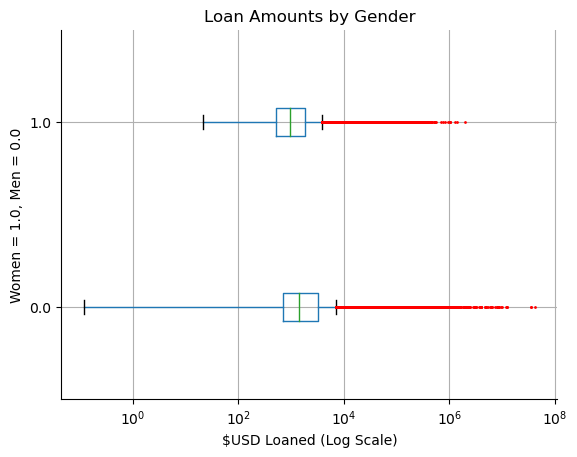

In [137]:
fig, ax = plt.subplots()
df1 = df.get(['Is Woman Owned?', 'Amount (USD)'])
df1 = df1.pivot(columns = 'Is Woman Owned?')  
df1.columns = df1.columns.droplevel(0)
df1 = df1.iloc[:, 1:]
df1.boxplot(vert=False, showfliers=True, flierprops={'markersize': 1, 'markerfacecolor': 'red', 'markeredgecolor': 'r'})
plt.xscale("log") 


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Women = 1.0, Men = 0.0')
ax.set_title('Loan Amounts by Gender')
ax.set_xlabel('$USD Loaned (Log Scale)')
plt.show()

We plotted a box plot of the Loan Amounts categorized by whether the borrower was a Women borrower or not. Note a log scale was used to fit everything on a graph.

It seems like borrowers who are women actually receive around the same median amount of loans. However, the outliers tell us that women do not receive many of the larger loans for some reason. Is there some spurious relationship with the other established determinants of loan size? For example, is it possible that women tend to own smaller business so take out smaller loans?

We will explore this relationship by analyzing covariates of gender with the established determinants of loan size (Geography, Type of Business, Business Size) and calculating the average loan amount for each category. 

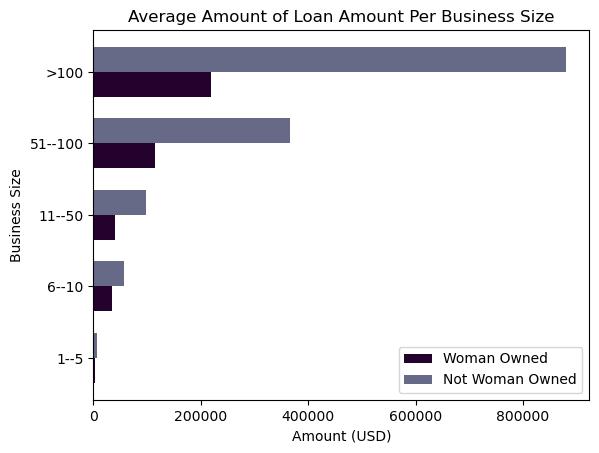

In [138]:
pivot_df = df.get(['Business Size', 'Amount (USD)', 'Is Woman Owned?']).pivot_table(values='Amount (USD)', index='Business Size', columns='Is Woman Owned?', aggfunc=np.mean)
pivot_df = pivot_df.reindex(['1--5', '6--10', '11--50', '51--100','>100'])

fig, ax = plt.subplots()

width = 0.35
labels = pivot_df.index.tolist()

x = np.arange(len(labels))

rects1 = ax.barh(x - width/2, pivot_df[1.0], width, label='Woman Owned', color='#23022E')
rects2 = ax.barh(x + width/2, pivot_df[0.0], width, label='Not Woman Owned', color='#666A86')

ax.set_xlabel('Amount (USD)')
ax.set_ylabel('Business Size')
ax.set_title('Average Amount of Loan Amount Per Business Size')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(loc='lower right')

plt.show()

Plotting the Average Loan Amount per business sector, for every size of business, women business owners received smaller loan amounts than their not woman owned businesses.

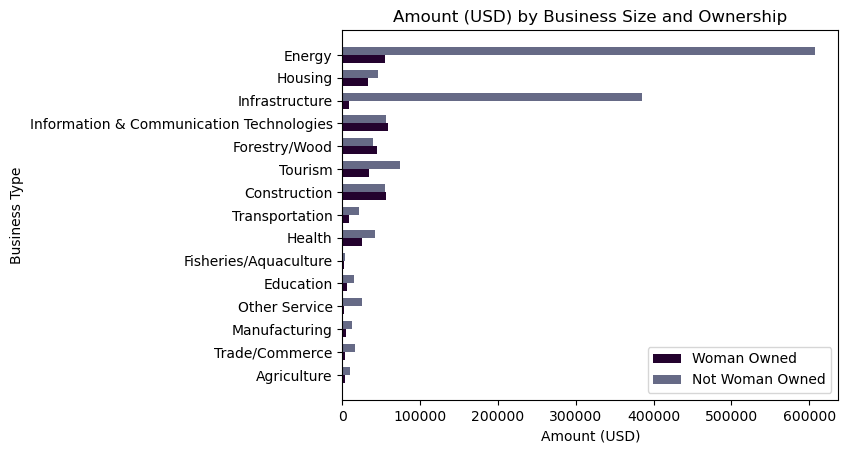

In [139]:
df1 = df['Business Sector'].value_counts()

pivot_df = df.get(['Business Sector', 'Amount (USD)', 'Is Woman Owned?']).pivot_table(values='Amount (USD)', index='Business Sector', columns='Is Woman Owned?', aggfunc=np.mean)
pivot_df = pivot_df.reindex(df1.index)

fig, ax = plt.subplots()

height = 0.35
labels = pivot_df.index.tolist()

y = np.arange(len(labels))

rects1 = ax.barh(y - height/2, pivot_df[1.0], height, label='Woman Owned', color='#23022E')
rects2 = ax.barh(y + height/2, pivot_df[0.0], height, label='Not Woman Owned', color='#666A86')

ax.set_xlabel('Amount (USD)')
ax.set_ylabel('Business Type')
ax.set_title('Amount (USD) by Business Size and Ownership')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

plt.show()

For all business sectors, except for Forestry/Wood, Information & Communication Technologies, and Construction, women received less loan amounts than their male counterparts.

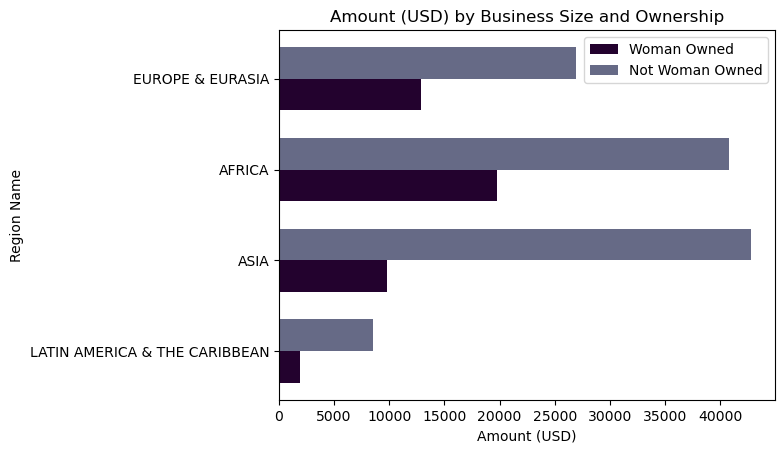

In [140]:
df1 = df['Region Name'].value_counts()

pivot_df = df.get(['Region Name', 'Amount (USD)', 'Is Woman Owned?']).pivot_table(values='Amount (USD)', index='Region Name', columns='Is Woman Owned?', aggfunc=np.mean)
pivot_df = pivot_df.reindex(df1.index)
pivot_df = pivot_df.drop(['MIDDLE EAST', 'NORTH AMERICA'])

fig, ax = plt.subplots()

height = 0.35
labels = pivot_df.index.tolist()

y = np.arange(len(labels))

rects1 = ax.barh(y - height/2, pivot_df[1.0], height, label='Woman Owned', color='#23022E')
rects2 = ax.barh(y + height/2, pivot_df[0.0], height, label='Not Woman Owned', color='#666A86')

ax.set_xlabel('Amount (USD)')
ax.set_ylabel('Region Name')
ax.set_title('Amount (USD) by Business Size and Ownership')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

plt.show()

For all business Regions, except for North America and the Middle East (which had few entries and did not have women borrowers), women received less loan amounts than their male counterparts. 

Overall, it is clear that despite individually controlling for factors related to Geography, Business Sector, and Business Size, women still receive on average smaller loans than their comparable male counterparts. We will continue to unravel this interesting relationship in the subsequent sections. 

# Project 2

## The Message

### The Gender Gap

In [141]:
pivot_df = df.get(['Region Name', 'Amount (USD)', 'Is Woman Owned?']).pivot_table(values='Amount (USD)', index='Region Name', columns='Is Woman Owned?', aggfunc=[np.mean, np.median])
total_df = df.get(['Amount (USD)', 'Is Woman Owned?']).pivot_table(values='Amount (USD)', columns='Is Woman Owned?', aggfunc=[np.mean, np.median])
total_df

mean                  median          
Is Woman Owned?           0.0          1.0        0.0       1.0
Amount (USD)     17876.640016  3746.260213  1382.1864  955.8617

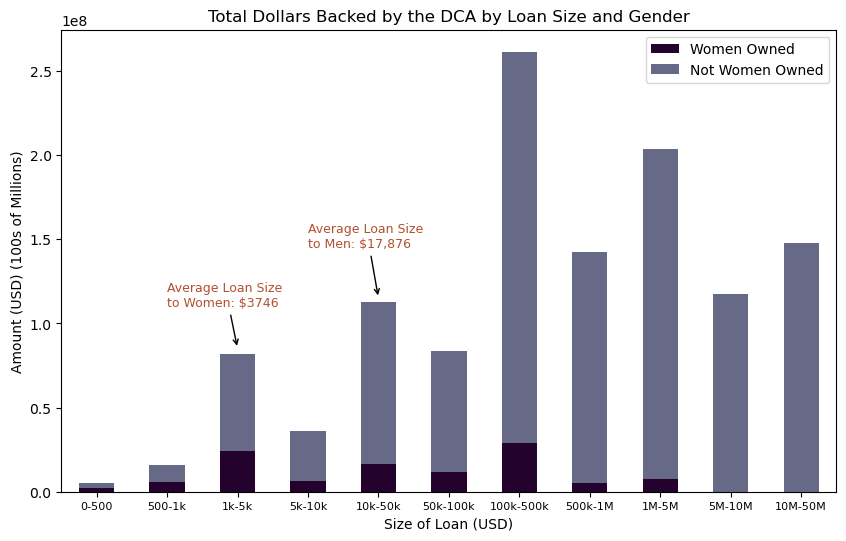

In [142]:
partitions = [0, 10**3, 10**4, 10**5, 10**6, 10**7] + [10**3//2, 10**4//2, 10**5//2, 10**6//2, 10**7//2, 10**8//2]
partitions.sort()

df_partition = df.copy().get(['Amount (USD)', 'Is Woman Owned?'])
df_partition['partition'] = pd.cut(df_partition['Amount (USD)'], bins=partitions)
pivot_df = df_partition.pivot_table(values='Amount (USD)', index='partition', columns='Is Woman Owned?', aggfunc=np.sum)

total = pivot_df[0.0] + pivot_df[1.0]
pivot_df['Total'] = total
pivot_df['Men_Percentage'] = pivot_df[0.0] / total * 100
pivot_df['Women_Percentage'] = pivot_df[1.0] / total * 100


df_pivot = pivot_df.pivot_table(index='partition', values=[0.0, 1.0])
df_pivot = df_pivot[[1.0, 0.0]]

ax = df_pivot.plot(kind='bar', stacked=True, color=['#23022E','#666A86'], figsize=(10,6))

plt.annotate('Average Loan Size \nto Women: $3746', xy=(2, 0.85*10**8), xytext=(1, 1.1*10**8), fontsize=9, color='#B34F30', arrowprops=dict(arrowstyle="->"))
plt.annotate('Average Loan Size \nto Men: $17,876', xy=(4, 1.15*10**8), xytext=(3, 1.45*10**8), fontsize=9, color='#B34F30', arrowprops=dict(arrowstyle="->"))

# Set the labels and title
ax.set_xlabel('Size of Loan (USD)')
ax.set_ylabel('Amount (USD) (100s of Millions)')
ax.set_title('Total Dollars Backed by the DCA by Loan Size and Gender')
plt.xticks(range(len(partitions) - 1), ['0-500', '500-1k', '1k-5k', '5k-10k', '10k-50k', '50k-100k', '100k-500k', '500k-1M', '1M-5M', '5M-10M', '10M-50M'], rotation = 0, fontsize=8)

ax.legend(['Women Owned', 'Not Women Owned'])

# Show the chart
plt.show()

The plot above summarizes the key findings when comparing the sizes of loans women receive compared to men. On the x-axis we have various sizes of loans. We took all loans in our dataset of these sizes, and added them to find how much money in total was lent out for loans for that size. Then we split them by whether or not the loans were made out to a women. "k" denotes thousand(s), "M" denotes million(s).

Notice the average loan amounts are towards the left side in the diagram since smaller loans simply require more individual loans to aggregate, dragging the average down. 

Not only do women receive a disproportionately small fraction of the total loan dollars backed by the DCA, the loans they do receive also tend to be of smaller amounts.

- Of the 1.9 Billion dollars of loans backed by the DCA, recall that 32% of all loan transactions were made to women. However, only 9% of loan dollars ended up for women (dark purple), and 91% of loan dollars went to men (light gray). 
- The reason why is clear: women entrepreneurs receive almost none of the loans larger than 500k, which roughly make up half of to total dollars of loans backed by the DCA.

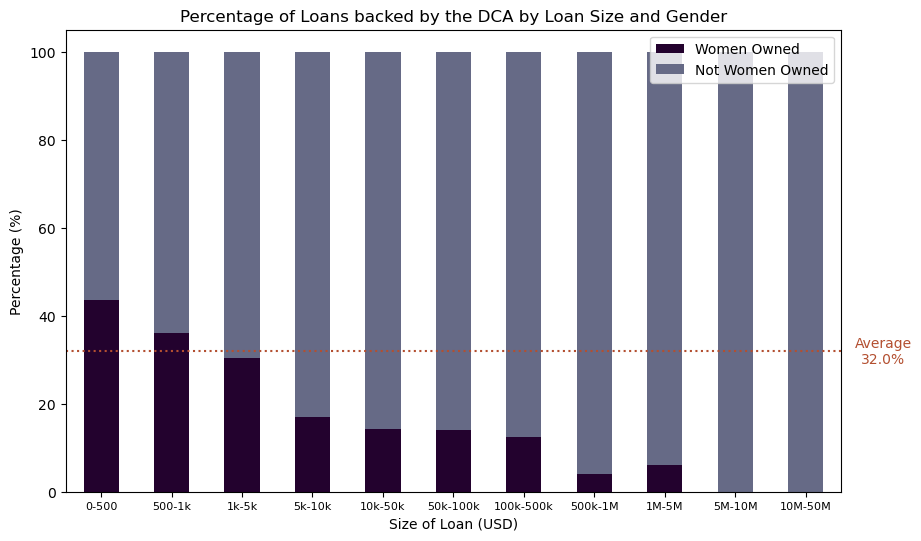

In [143]:
partitions = [0, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8] + [10**3//2, 10**4//2, 10**5//2, 10**6//2, 10**7//2]
partitions.sort()

df_partition = df.copy().get(['Amount (USD)', 'Is Woman Owned?'])
df_partition['partition'] = pd.cut(df_partition['Amount (USD)'], bins=partitions)
pivot_df = df_partition.pivot_table(values='Amount (USD)', index='partition', columns='Is Woman Owned?', aggfunc='count')

total = pivot_df[0.0] + pivot_df[1.0]
pivot_df['Total'] = total
pivot_df['Not Women Owned'] = pivot_df[0.0] / total * 100
pivot_df['Women Owned'] = pivot_df[1.0] / total * 100

df_pivot = pivot_df.pivot_table(index='partition', values=['Not Women Owned', 'Women Owned'])

df_pivot = df_pivot[['Women Owned', 'Not Women Owned']]

# Plot the bars and baseline
ax = df_pivot.plot(kind='bar', stacked=True, color=['#23022E','#666A86'], figsize=(10,6))
plt.axhline(y=32.0, linestyle='dotted', color='#B34F30')

# Set the labels and title
ax.set_xlabel('Size of Loan (USD)')
ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of Loans backed by the DCA by Loan Size and Gender')


plt.xticks(range(len(partitions) - 1), ['0-500', '500-1k', '1k-5k', '5k-10k', '10k-50k', '50k-100k', '100k-500k', '500k-1M', '1M-5M', '5M-10M', '10M-50M'], rotation = 0, fontsize=8)
ax.legend()
plt.text(11.1, 28.5, 'Average\n32.0%', color='#B34F30', fontsize=10, ha='center', va='bottom')

# Show the chart
plt.show()

Another way to see this systemic issue is by counting the number of loans in each loan size category, and calculating the share of these loans going to women entrepreneurs. 32.0% of loans backed by the DCA go to women, so if loans were distributed independently of gender we would expect the share of loans across loan sizes to be close to this average.

However, only loans under five thousand dollars seem to meet this expectation, and we see a significant drop off thereafter, with no loans greater than five million dollars going to women.

### Gender Gap by Region Name

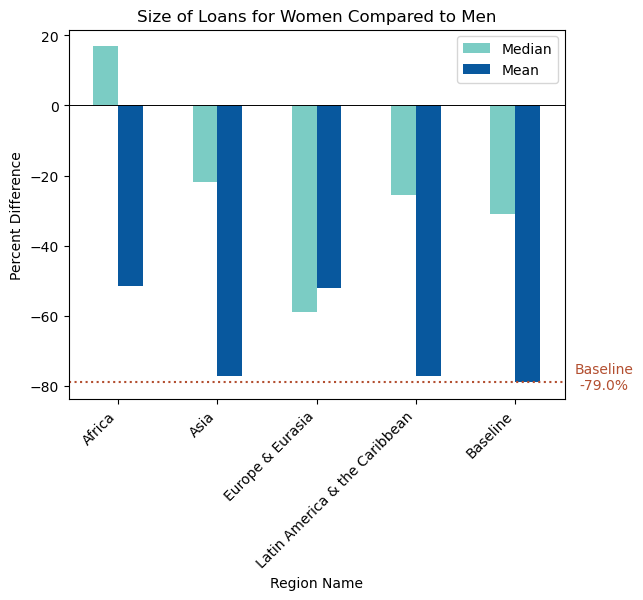

In [144]:
##### Calculate the median and mean amount by region and whether it's woman-owned
grouped = df.groupby(['Region Name', 'Is Woman Owned?'])['Amount (USD)'].agg(['median', 'mean']).reset_index()
grouped = grouped.drop([8,9]) # Drop North America and Middle East since no women owned data

# Calculate the overall median and mean amount for woman-owned and not woman-owned separately
overall_median_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].median()
overall_mean_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].mean()
overall_median_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].median()
overall_mean_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].mean()

# Add a 'Baseline' row to the pivot table with the overall median and mean values
pivot_table = pd.pivot_table(grouped, index='Region Name', columns='Is Woman Owned?', values=['median', 'mean'])
pivot_table.loc['BASELINE'] = [overall_mean_not_woman, overall_mean_woman, overall_median_not_woman, overall_median_woman]

# Calculate the percent difference between woman-owned and not woman-owned for the median and mean columns
pivot_table['Percentage Diff Median'] = ((pivot_table['median'][1.0] - pivot_table['median'][0.0]) / pivot_table['median'][0.0]) * 100
pivot_table['Percentage Diff Mean'] = ((pivot_table['mean'][1.0] - pivot_table['mean'][0.0]) / pivot_table['mean'][0.0]) * 100

# Plot the bar graph
ax = pivot_table[['Percentage Diff Median', 'Percentage Diff Mean']].plot(kind='bar', color=['#7bccc4','#08589e'])
ax.legend(['Median', 'Mean'])
ax.set_xticks(range(5), ['Africa', 'Asia', 'Europe & Eurasia', 'Latin America & the Caribbean', 'Baseline'], rotation=45, ha="right")
ax.set_xlabel('Region Name')
ax.set_ylabel('Percent Difference')
plt.axhline(y=0, linewidth=0.7, color='black')
ax.set_title('Size of Loans for Women Compared to Men')

plt.axhline(y=-79.0, linestyle='dotted', color='#B34F30')
plt.text(4.9, -82, 'Baseline\n-79.0%', color='#B34F30', fontsize=10, ha='center', va='bottom')
plt.show()

To prove that it is unlikely that women receive smaller loans because of some of spurious relationship (i.e. women simply have smaller business resulting in smaller loans), we will plot the differences in mean and median loan amounts over the other variables we have established to have an impact on loan size.

In the above chart, we have calculated the percent difference of the mean and median loan amounts women receive compared to men across different regions. Baseline indicates the entire dataset average, the median women receives 3% smaller loans than men, but 70.5% smaller loans on average! All regions seem to trend with this observation, with Asia being the noticeable outlier. However, women still receive over 40% smaller loans on average in Asia, but it seems like loans tend to be distributed more fairly in Asia. Regardless, the mean is significantly below the median, indicating that larger loans are less likely to be given to women.

Notice we omitted North America and Middle East regions since no women received loans in those regions. This missing data explains why the baseline average is lower than all the other regions.

### Gender Gap by Business Sector

                        Is Woman Owned?
Percentage Diff Median                     169.397207
Percentage Diff Mean                         2.671214
Name: Construction, dtype: float64


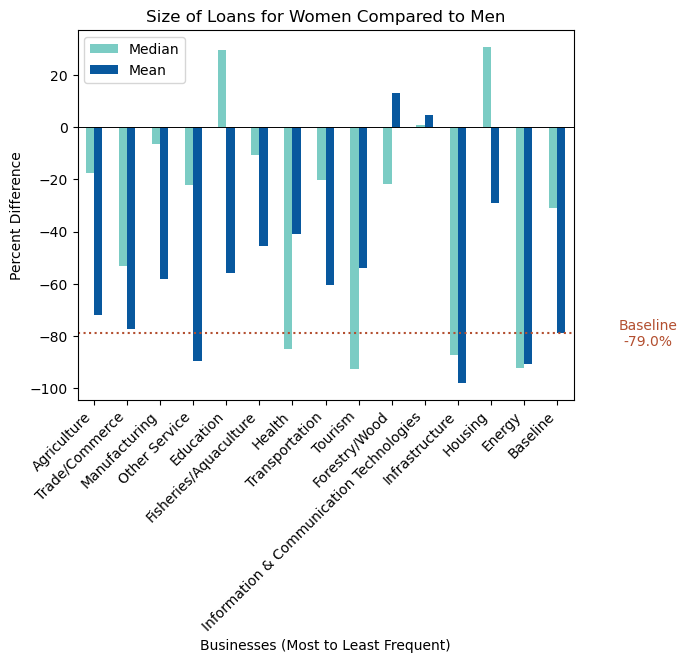

In [145]:
# Calculate the median and mean amount by region and whether it's woman-owned
grouped = df.groupby(['Business Sector', 'Is Woman Owned?'])['Amount (USD)'].agg(['median', 'mean']).reset_index()

# Calculate the overall median and mean amount for woman-owned and not woman-owned separately
overall_median_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].median()
overall_mean_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].mean()
overall_median_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].median()
overall_mean_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].mean()

# Add a 'Baseline' row to the pivot table with the overall median and mean values
pivot_table = pd.pivot_table(grouped, index='Business Sector', columns='Is Woman Owned?', values=['median', 'mean'])
pivot_table = pivot_table.reindex(df_special.index)
pivot_table.loc['BASELINE'] = [overall_mean_not_woman, overall_mean_woman, overall_median_not_woman, overall_median_woman]

# Calculate the percent difference between woman-owned and not woman-owned for the median and mean columns
pivot_table['Percentage Diff Median'] = ((pivot_table['median'][1.0] - pivot_table['median'][0.0]) / pivot_table['median'][0.0]) * 100
pivot_table['Percentage Diff Mean'] = ((pivot_table['mean'][1.0] - pivot_table['mean'][0.0]) / pivot_table['mean'][0.0]) * 100

# Print and remove extreme outlier
print(pivot_table.loc['Construction'][['Percentage Diff Median', 'Percentage Diff Mean']])
pivot_table = pivot_table.drop('Construction')

# Plot the bar graph
ax = pivot_table[['Percentage Diff Median', 'Percentage Diff Mean']].plot(kind='bar', color=['#7bccc4','#08589e'])
ax.legend(['Median', 'Mean'])
ax.set_xticks(range(len(df_special.drop('Construction').index)+1), df_special.drop('Construction').index.append(pd.Index(['Baseline'])), rotation=45, ha="right")
ax.set_xlabel('Businesses (Most to Least Frequent)')
ax.set_ylabel('Percent Difference')
plt.axhline(y=0, linewidth=0.7, color='black')
plt.axhline(y=-79.0, linestyle='dotted', color='#B34F30')
plt.text(16.75, -85, 'Baseline\n-79.0%', color='#B34F30', fontsize=10, ha='center', va='bottom')
ax.set_title('Size of Loans for Women Compared to Men')
plt.show()

Similarly, we have calculated the percent difference of the mean and median loan amounts women receive compared to men across different business types. The business are sorted from left to right by most to least frequent appearances (number of loans) in the dataset.

Some noticeable outliers are Construction (omitted from graph because of its extreme median), Forestry/Wood, and Information Technologies, which are the same outliers as identified in the previous section. In these industries, women on average receive bigger loans than men. Nevertheless, women clearly receive smaller loans on average, especially for the most frequent categories. Notice this can be explained again by the fact that women do not get many bigger loans since the median tends to be greater than the mean.

### Gender Gap by Business Size

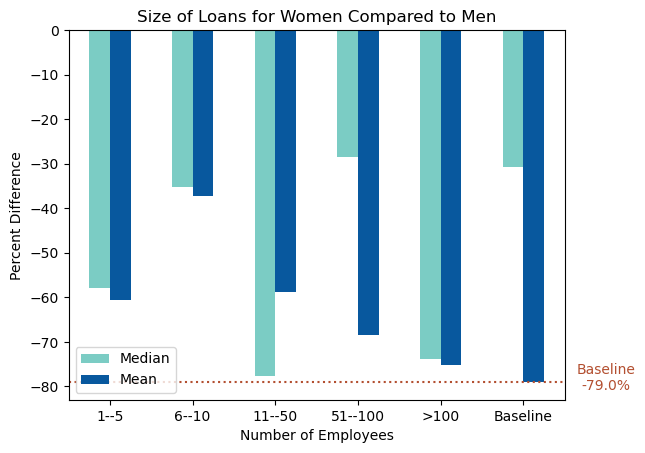

In [146]:
# Calculate the median and mean amount by region and whether it's woman-owned
grouped = df.groupby(['Business Size', 'Is Woman Owned?'])['Amount (USD)'].agg(['median', 'mean']).reset_index()
#grouped = grouped.drop([8,9])

# Calculate the overall median and mean amount for woman-owned and not woman-owned separately
overall_median_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].median()
overall_mean_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].mean()
overall_median_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].median()
overall_mean_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].mean()

# Add a 'Baseline' row to the pivot table with the overall median and mean values
pivot_table = pd.pivot_table(grouped, index='Business Size', columns='Is Woman Owned?', values=['median', 'mean'])
pivot_table.loc['BASELINE'] = [overall_mean_not_woman, overall_mean_woman, overall_median_not_woman, overall_median_woman]

# Calculate the percent difference between woman-owned and not woman-owned for the median and mean columns
pivot_table['Percentage Diff Median'] = ((pivot_table['median'][1.0] - pivot_table['median'][0.0]) / pivot_table['median'][0.0]) * 100
pivot_table['Percentage Diff Mean'] = ((pivot_table['mean'][1.0] - pivot_table['mean'][0.0]) / pivot_table['mean'][0.0]) * 100
pivot_table = pivot_table.reindex(['1--5', '6--10', '11--50','51--100', '>100', 'BASELINE' ])

# Plot the bar graph
ax = pivot_table[['Percentage Diff Median', 'Percentage Diff Mean']].plot(kind='bar', color=['#7bccc4','#08589e'])
ax.legend(['Median', 'Mean'])
ax.set_xlabel('Number of Employees')
ax.set_ylabel('Percent Difference')
ax.set_xticks(range(6), ['1--5', '6--10', '11--50', '51--100', '>100', 'Baseline'], rotation=0)

plt.axhline(y=0, linewidth=0.7, color='black')
plt.axhline(y=-79.0, linestyle='dotted', color='#B34F30')
plt.text(6, -81.5, 'Baseline\n-79.0%', color='#B34F30', fontsize=10, ha='center', va='bottom')
ax.set_title('Size of Loans for Women Compared to Men')
plt.show()

Probably the most telling diagram of the Gender Gap, when we control for business size, women systemically receive smaller loans then men. In fact, this gap seems to get worse as the business gets bigger, with large business (>100) owned by women receiving on average 75% smaller loans than business of comparable sizes owned by men.

Interestingly, the median loan size also seems to show a similar gap now, further supporting our hypothesis. Not all observation in the dataset contained information about business size, which is why the median bars do not average out to the baseline median.

### Gender Gap by First TIme Borrower

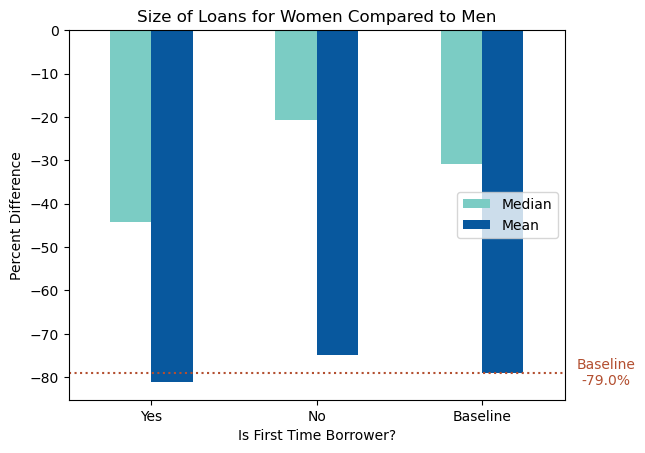

In [147]:
# Calculate the median and mean amount by region and whether it's woman-owned
grouped = df.groupby(['Is First Time Borrower?', 'Is Woman Owned?'])['Amount (USD)'].agg(['median', 'mean']).reset_index()

# Calculate the overall median and mean amount for woman-owned and not woman-owned separately
overall_median_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].median()
overall_mean_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].mean()
overall_median_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].median()
overall_mean_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].mean()

# Add a 'Baseline' row to the pivot table with the overall median and mean values
pivot_table = pd.pivot_table(grouped, index='Is First Time Borrower?', columns='Is Woman Owned?', values=['median', 'mean'])
pivot_table.loc['BASELINE'] = [overall_mean_not_woman, overall_mean_woman, overall_median_not_woman, overall_median_woman]

# Calculate the percent difference between woman-owned and not woman-owned for the median and mean columns
pivot_table['Percentage Diff Median'] = ((pivot_table['median'][1.0] - pivot_table['median'][0.0]) / pivot_table['median'][0.0]) * 100
pivot_table['Percentage Diff Mean'] = ((pivot_table['mean'][1.0] - pivot_table['mean'][0.0]) / pivot_table['mean'][0.0]) * 100

# Plot the bar graph
ax = pivot_table[['Percentage Diff Median', 'Percentage Diff Mean']].plot(kind='bar', color=['#7bccc4','#08589e'])
ax.legend(['Median', 'Mean'])
ax.set_xticks(range(3), ['Yes', 'No', 'Baseline'], rotation=0)
ax.set_xlabel('Is First Time Borrower?')
ax.set_ylabel('Percent Difference')
plt.axhline(y=0, linewidth=0.7, color='black')
plt.axhline(y=-79.0, linestyle='dotted', color='#B34F30')
plt.text(2.75, -82.5, 'Baseline\n-79.0%', color='#B34F30', fontsize=10, ha='center', va='bottom')
ax.set_title('Size of Loans for Women Compared to Men')
plt.show()

For the sake of completeness, we have also plotted a similar graph against the variable "Is First Time Borrower?". Recall we have already ruled this variable out as having any significant impacts of loan sizes in the previous section. Unsurprisingly, we do not see a big difference between the Baseline and whether it is a first time borrower or not. The gender gap still exists for either group. Notably, women owned business that are first time borrowers are even smaller than those with past borrowing experience.

### Summary of the Message

To recap, we have uncovered that the DCA program has an undeniable systemic issue where women business owners receive smaller loans than comparable male business owners. Our key findings include:
- 32% of loans were made to women, but only 9% of loan dollars went to women. Women entrepreneurs receive 79% smaller loans than men on average.
- The median loan women receive is 31% smaller than men.
- This skewness is because women receive less than 20% loans larger than $5,000 which make up the majority of loan dollars. In fact, the larger the loan, the less likely a women entrepreneur receives it.
- This gap approximately holds across other covariates, with very few exceptions.

Henceforth, we will define the "Gender Loan Gap" or simply "Gender Gap" as the percentage difference in average (mean) loan amounts women entrepreneurs receive compared to men. Formally:

\begin{align*}
    \text{Gender Gap} &= \frac{\text{Mean Loan Amount}_{women} - \text{Mean Loan Amount}_{men}}{\text{Mean Loan Amount}_{men}} \times 100
    \\\\
    &= \left[ \frac{\text{Mean Loan Amount}_{women}}{\text{Mean Loan Amount}_{men}} - 1 \right] \times 100
\end{align*}

This last equation can be interpreted as the fraction of mean loan amount women receive compared to men, normalized by subtracting an equal world, where the mean loans are equal so 1. A perfectly equal world is where the Gender Gap is 0%. Negative numbers indicate women receive smaller loans than men. 

As typically in economics, when discussing a "smaller" or "larger" Gender Gap we will be referring to the absolute change. Typically, we will deal with the case where the Gender Gap is negative (women receive smaller loans on average), so a larger Gender Gap is a more negative number, and a smaller Gender Gap is a less negative number.

Notice we have been using definition already throughout this section implicitly as "Percent Difference" for the mean loan amounts.

## Maps and Interpretations

### Merging with a New Dataset

In [148]:
df_gii = pd.read_csv(r"C:\Users\yunfe\OneDrive - University of Toronto\Courses\Eco 225\Project\Data\HDR21-22_Composite_indices_complete_time_series.csv")
df_gii = df_gii.get(['country', 'iso3', 'gii_1999', 'gii_2001', 'gii_2002', 'gii_2003', 'gii_2004', 'gii_2005', 'gii_2006', 'gii_2007', 'gii_2008', 'gii_2009', 'gii_2010', 'gii_2011', 'gii_2012', 'gii_2013', 'gii_2014', 'gii_2015', 'gii_2016'])
df_gii = df_gii.set_index('country')
# Since the Dataset was created in 2016, we will assume that the loans were given from 1999-2016

In [149]:
df_gdp = pd.read_csv(r"C:\Users\yunfe\OneDrive - University of Toronto\Courses\Eco 225\Project\Data\gdp-per-capita-worldbank.csv")
df_gdp = df_gdp[df_gdp['Year'] == 2010].set_index('Entity')

Above we added two new datasets to our analysis: The United Nations Development Programme's Gender Inequality Index (GII) and GDP per capita in 2010.

GDP per captia is assumed background knowledge, but we will briefly explain the GII with a quote from the UN. "GII is a composite metric of gender inequality using three dimensions: reproductive health, empowerment and the labour market. A low GII value indicates low inequality between women and men, and vice-versa." (United Nations 2023).

Recall one finding we found in our previous analysis was the significant effects of Region on loan size. This leads us to the natural question: Do countries that are richer receive bigger loans because their economy have more advanced businesses? We choose GDP per captia in 2010 since it is somewhere in the middle of 1999-2017, the duration of the DCA program.

Another key finding we uncovered was the gender gap prevalent in the loans given by the DCA. Remember the DCA does not actually give out the loans themselves, but backs local financial institutions who give out the loans. In other words, this gender gap may actually be a reflection of systemic inequality of the country's institutions, and may not be systemic issue of the DCA program itself. Perhaps if the DCA program was operating in a more equal society, this gender gap might disappear? Nevertheless, if programs like DCA aim to be equitable, actively designing the program to counteract local systemic inequality is key. This leads us to the natural question: Do countries that have more inequality (i.e. have a higher GII) correlate with a bigger gender loan gap?

We will explore both of these questions by mapping these indicators.

In [150]:
to_merge = df_gii.set_index('iso3')['gii_2010']
to_merge.name = 'GII 2010'
df['index'] = df.index # Save Indexes
df = df.set_index('ISO_Code')
df = pd.merge(df, to_merge, how='left', left_index=True, right_index=True)

In [151]:
to_merge = df_gdp[df_gdp['Year'] == 2010].set_index('Code')['GDP per capita, PPP (constant 2017 international $)']
to_merge = to_merge[to_merge.index.notnull()] # Drop nan indexes generated by set_index
to_merge.name = 'GDP per Capita 2010'
df = pd.merge(df, to_merge, how='left', left_index=True, right_index=True)
df['ISO_Code'] = df.index
df = df.set_index('index').sort_index()

Above we also merged these values into our main DataFrame to use for regressions later.

### GDP and Average Loan Amounts

In [152]:
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import ListedColormap, BoundaryNorm

In [153]:
df_world_grouped = df.groupby('Guarantee Country Name')

bad_countries = []
for country in df_world_grouped:
# If there are less than 10 instances of this country in the group, there are too few to compute an accurate average
    if df_world_grouped.get_group(country[0])['Amount (USD)'].count() < 10:  
        bad_countries.append(country[0])
        
df_world_grouped = df[~df['Guarantee Country Name'].isin(bad_countries)]

df_world_grouped = df_world_grouped.groupby('Guarantee Country Name')['Amount (USD)'].mean()

In [154]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index('name')  # Reset the index of world to be name
world = world.drop('Antarctica') # We don't need Antarctica on our map
world['Average Amount (USD)'] = df_world_grouped

In [155]:
df[df['Guarantee Country Name'] == 'India']['Amount (USD)'].mean() # Average of loans to India

4686576.067015384

In [156]:
df[df['Guarantee Country Name'] == 'Mali']['Amount (USD)'].mean() # Average of loans to Mali

559472.70198

In [157]:
df[df['Guarantee Country Name'] == 'Russia']['Amount (USD)'].mean() # Average of loans to Russia

71751.05818743455

In [158]:
df[df['Guarantee Country Name'] == 'South Africa']['Amount (USD)'].mean() # Average of loans to South Africa

583354.954108527

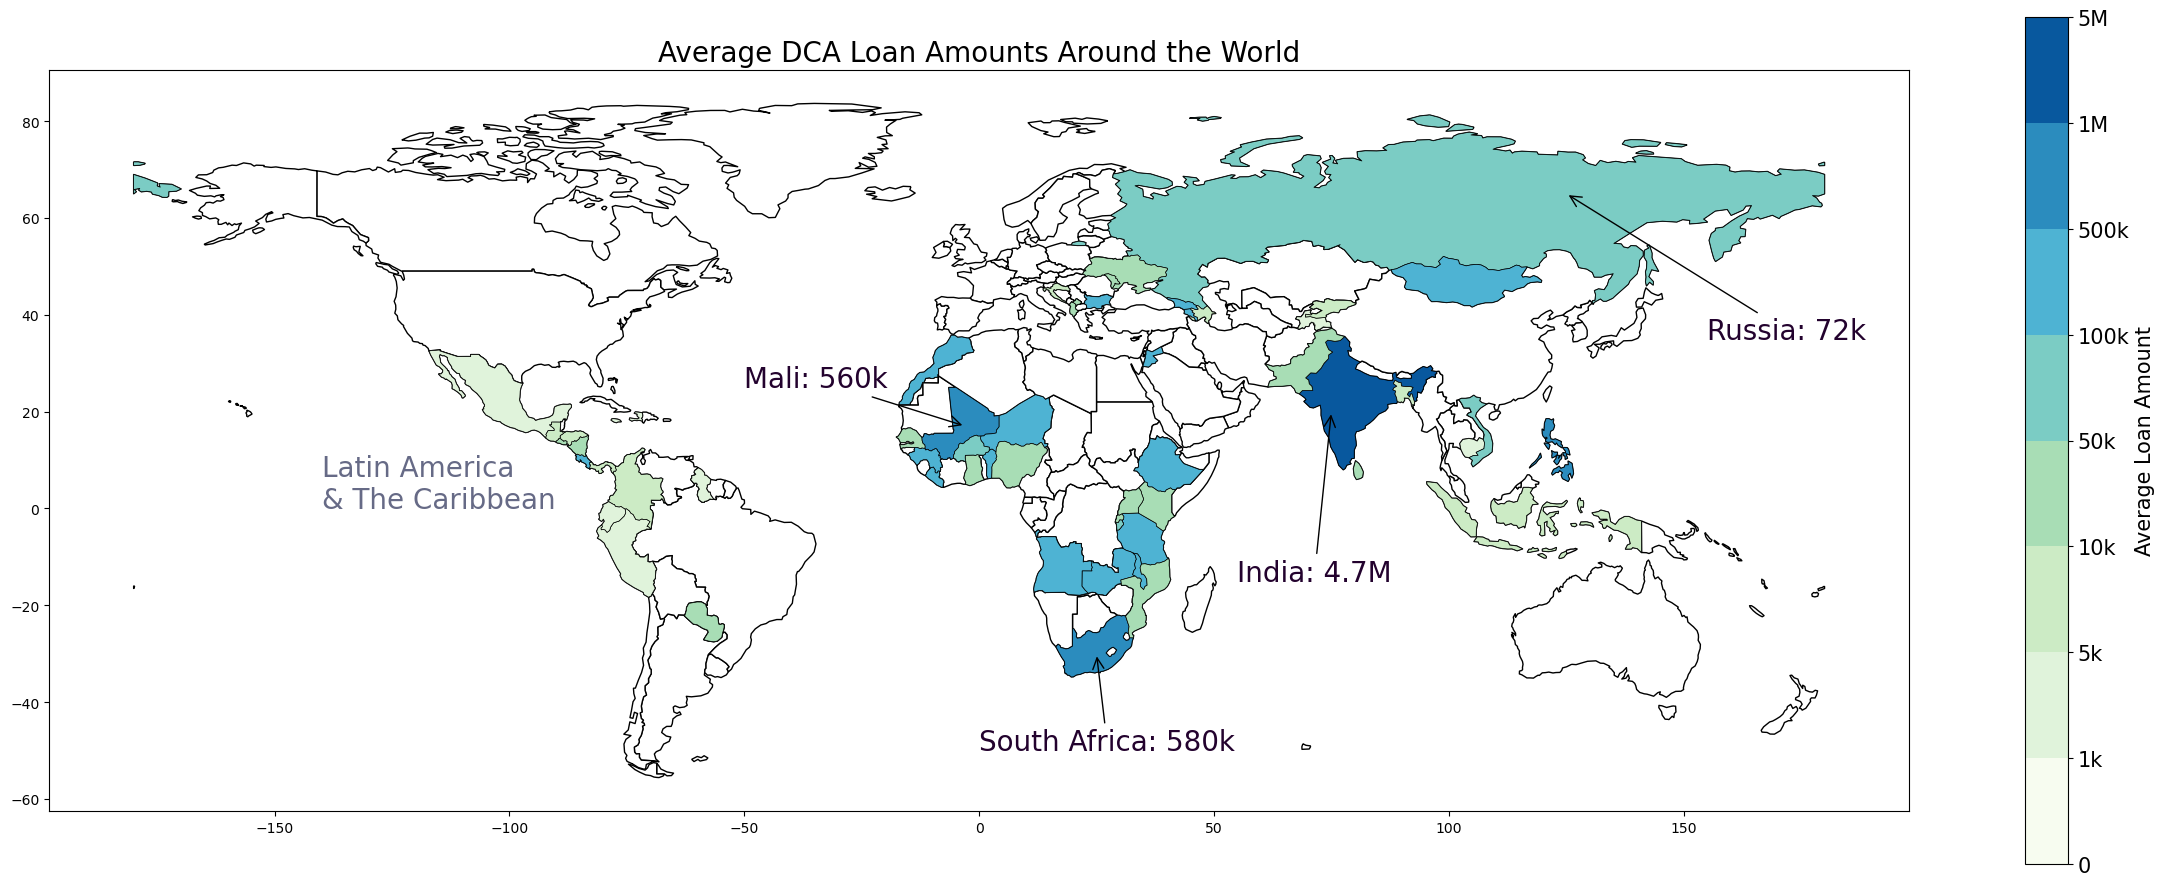

In [159]:
fig, gax = plt.subplots(figsize=(30,11))


# Define the color map
cmap = ListedColormap(['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'])

# Set the intervals for the color map
bounds = [0, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000]
norm = BoundaryNorm(bounds, len(cmap.colors))

world.plot(ax=gax, edgecolor='black', color = 'white')
ax = world.plot(ax=gax, edgecolor='black', column='Average Amount (USD)', cmap=cmap, norm=norm,
                 linewidth=0.5, legend=True)

cb_ax = fig.axes[1]
cb_ax.set_yticks(bounds, [0, '1k', '5k', '10k', '50k', '100k', '500k', '1M', '5M'])
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Average Loan Amount', size=15)
gax.set_title('Average DCA Loan Amounts Around the World', fontsize=20)

plt.annotate('India: 4.7M', xy=(75, 20), xytext=(55, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Russia: 72k', xy=(125, 65), xytext=(155, 35), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Mali: 560k', xy=(-3, 17), xytext=(-50, 25), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('South Africa: 580k', xy=(25, -30), xytext=(0, -50), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Latin America\n& The Caribbean', xy=(-140, 0), fontsize=20, color='#666A86')

plt.show()

Above is the average loan amount backed by the DCA around the world. We excluded countries that received fewer than 10 loans since those countries would not have enough loan information to derive an accurate average. Countries that were excluded and where the DCA did not operate are in white. On the map we highlighted countries with the highest average loan amounts. India is an extreme outlier with the average loans backed by the DCA being 4.7 Million USD.

One interesting fact to note is the lack of any blue areas in the Latin America & the Caribbean areas. Loans in the countries in this region on average are well under 50,000 USD. This matches our previous findings that while this region received the most number loans, the total loan dollars they received was disproportionately small.

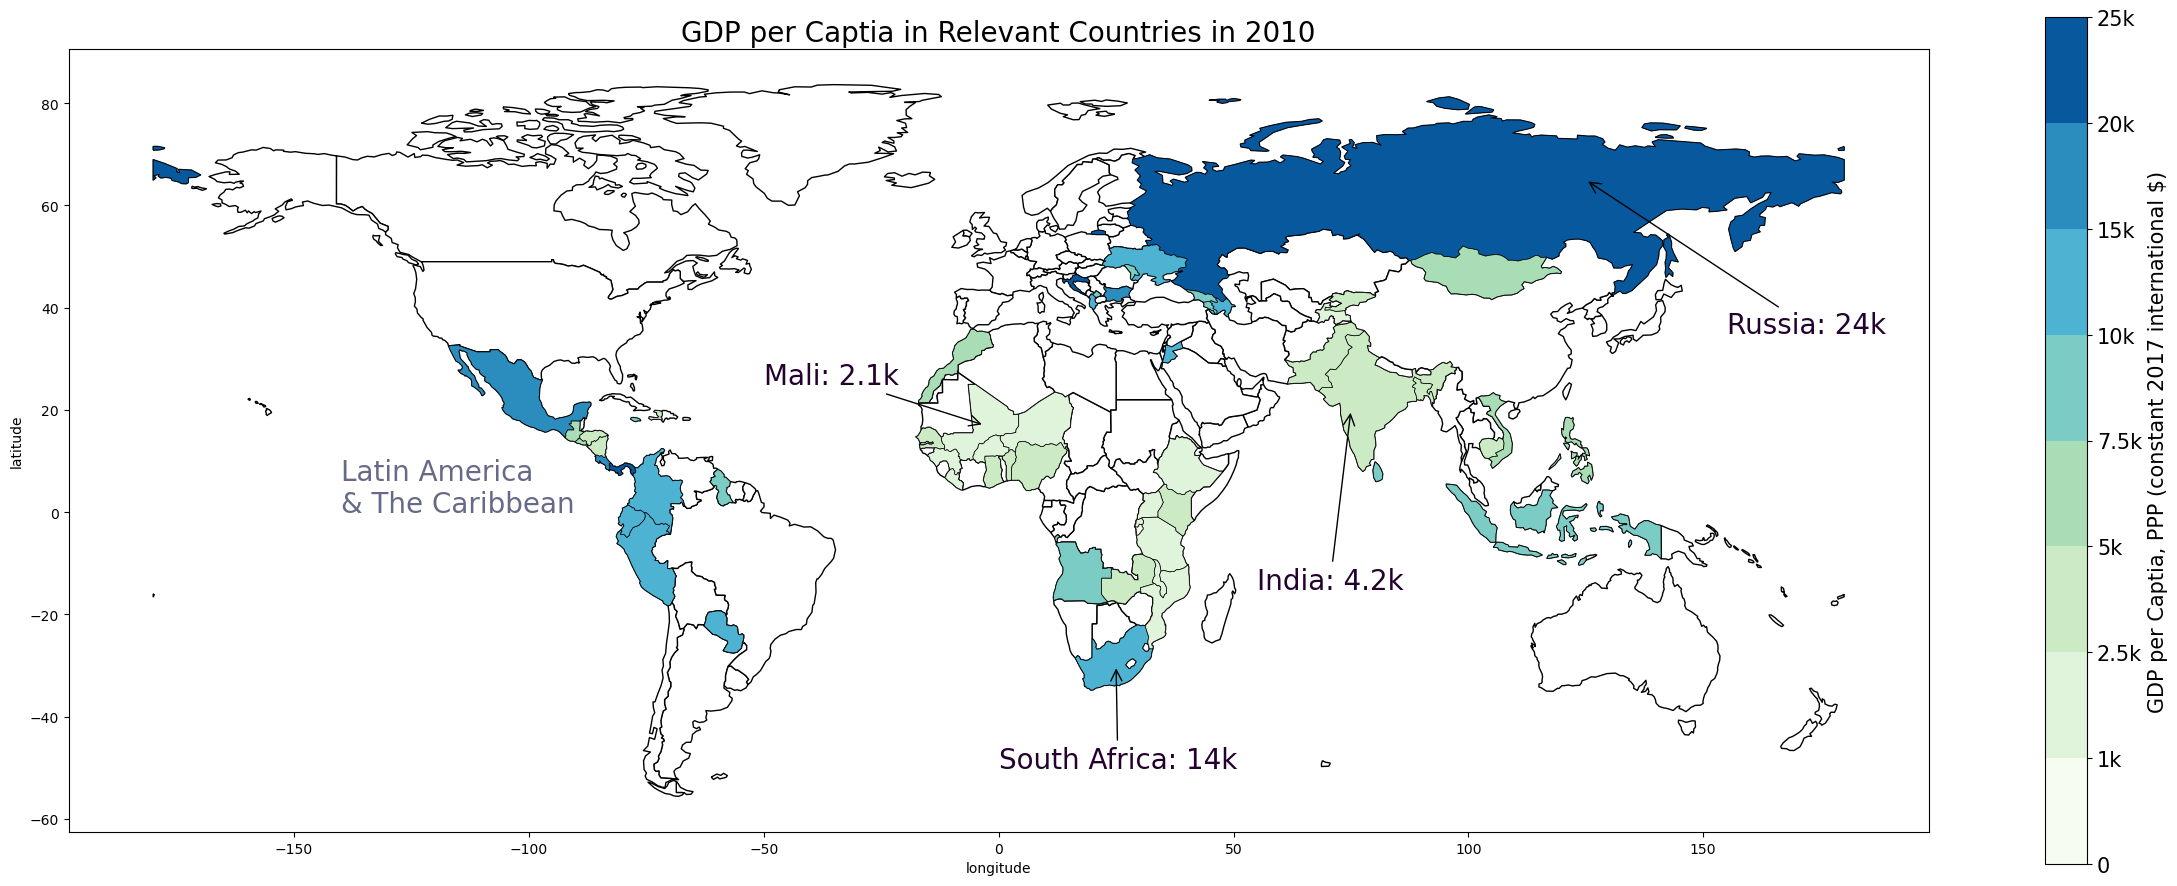

In [160]:
world_dropped = world.copy()
world_dropped['GDP Per Capita'] = df_gdp['GDP per capita, PPP (constant 2017 international $)']
world_dropped = world_dropped[world_dropped['Average Amount (USD)'].notna()]


fig, gax = plt.subplots(figsize=(30,11))

# Define the color map
cmap = ListedColormap(['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'])

# Set the intervals for the color map
bounds = [0, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000]
norm = BoundaryNorm(bounds, len(cmap.colors))

world.plot(ax=gax, edgecolor='black', color = 'white')
world_dropped.plot(ax=gax, edgecolor='black', column='GDP Per Capita', cmap=cmap, norm=norm,
                 linewidth=0.5, legend=True)

cb_ax = fig.axes[1]
cb_ax.set_yticks(bounds, [0, '1k', '2.5k', '5k', '7.5k', '10k', '15k', '20k', '25k'])
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('GDP per Captia, PPP (constant 2017 international $)', size=15)
gax.set_title('GDP per Captia in Relevant Countries in 2010', fontsize=20)

plt.annotate('India: 4.2k', xy=(75, 20), xytext=(55, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Russia: 24k', xy=(125, 65), xytext=(155, 35), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Mali: 2.1k', xy=(-3, 17), xytext=(-50, 25), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('South Africa: 14k', xy=(25, -30), xytext=(0, -50), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Latin America\n& The Caribbean', xy=(-140, 0), fontsize=20, color='#666A86')

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

plt.show()

Above is plotted the GDP per Capita with the same countries as the last month. 

Curiously, there seems to be an inverse relationship between GDP per Capita with average loan size. For example, areas in Latin America that are the richest (highest GDP per Capita) received very small loans on average, while areas in Africa that are the poorest (lowest GDP per Capita) seem to have received bigger loans on average. This also goes for areas in Asia (especially India) and the Middle East.

This flips our initial hypothesis upside down and it seems like richer countries tend to receive smaller loans on average. Some kind of regression analysis will be needed to determine the strength of this correlation. One speculative explanation of this phenomenon could be that richer countries tend to have more developed financial institutions that operate in a less risky environment. Thus they are more willing to bear the risk to loan to smaller businesses of smaller amounts. Thus the DCA program would only need to step in to incentivise banks to give those very small loans, resulting in loans backed by the DCA program being very small in richer countries, and vice versa. Of course, this is all speculation for now.

### GII and the Loan Gender Gap

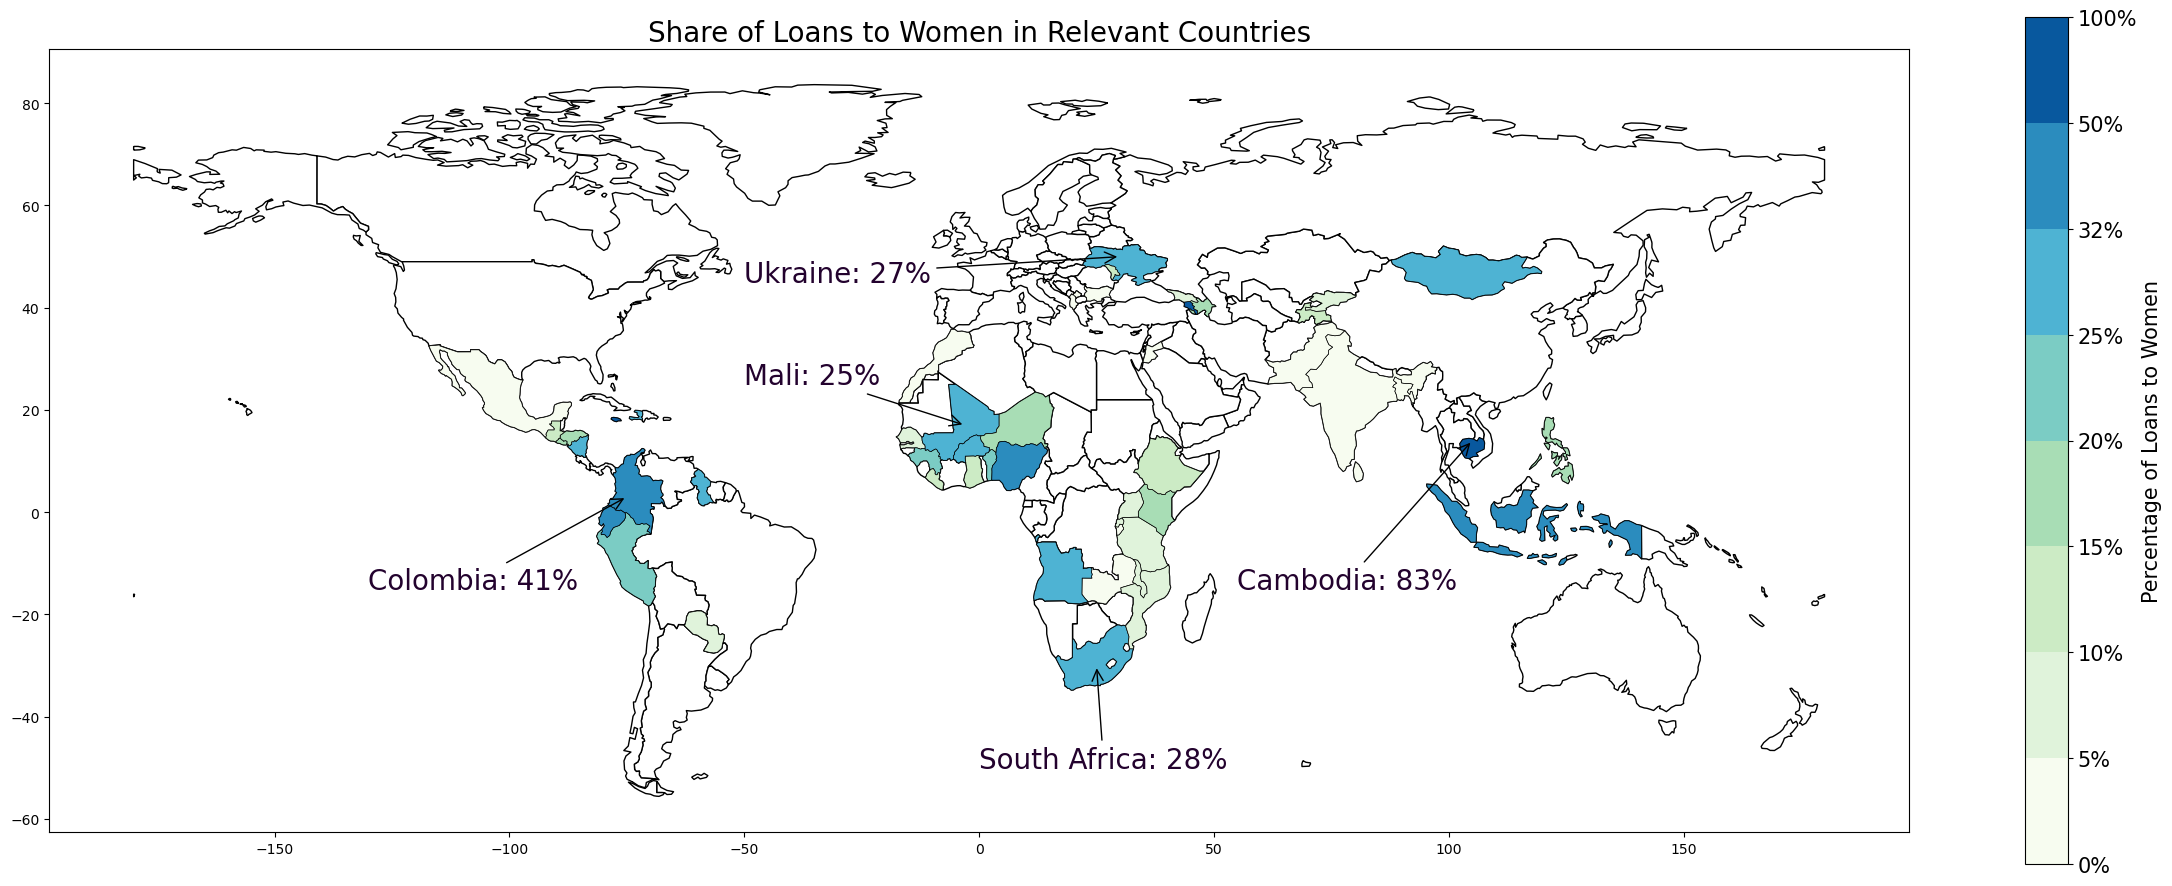

In [161]:
df_world_grouped = df[~df['Guarantee Country Name'].isin(bad_countries)]

df_world_grouped = df_world_grouped.groupby('Guarantee Country Name')['Is Woman Owned?'].mean()

world_dropped['Percentage Women Owned'] = df_world_grouped

fig, gax = plt.subplots(figsize=(30,11))

# Define the color map
cmap = ListedColormap(['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'])

# Set the intervals for the color map
bounds = [0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.32, 0.5, 1]
norm = BoundaryNorm(bounds, len(cmap.colors))

world.plot(ax=gax, edgecolor='black', color = 'white')
world_dropped.plot(ax=gax, edgecolor='black', column='Percentage Women Owned', cmap=cmap, norm=norm,
                 linewidth=0.5, legend=True)

cb_ax = fig.axes[1]
cb_ax.set_yticks(bounds, ['0%', '5%', '10%', '15%', '20%', '25%', '32%', '50%', '100%'])
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Percentage of Loans to Women', size=15)
gax.set_title('Share of Loans to Women in Relevant Countries', fontsize=20)

# Annotations
plt.annotate('Cambodia: 83%', xy=(105, 14), xytext=(55, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Colombia: 41%', xy=(-75, 3), xytext=(-130, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Mali: 25%', xy=(-3, 17), xytext=(-50, 25), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('South Africa: 28%', xy=(25, -30), xytext=(0, -50), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Ukraine: 27%', xy=(30, 50), xytext=(-50, 45), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))


plt.show()

Above we have plotted the percentage of loans given to women in relevant countries in our dataset. Cambodia and countries in southeast Asia stand out as the strongest lending practices to women. Many countries in Africa also have better than average (32%) loan rates to women. However, most regions loan to women at rates well below the 25% mark.

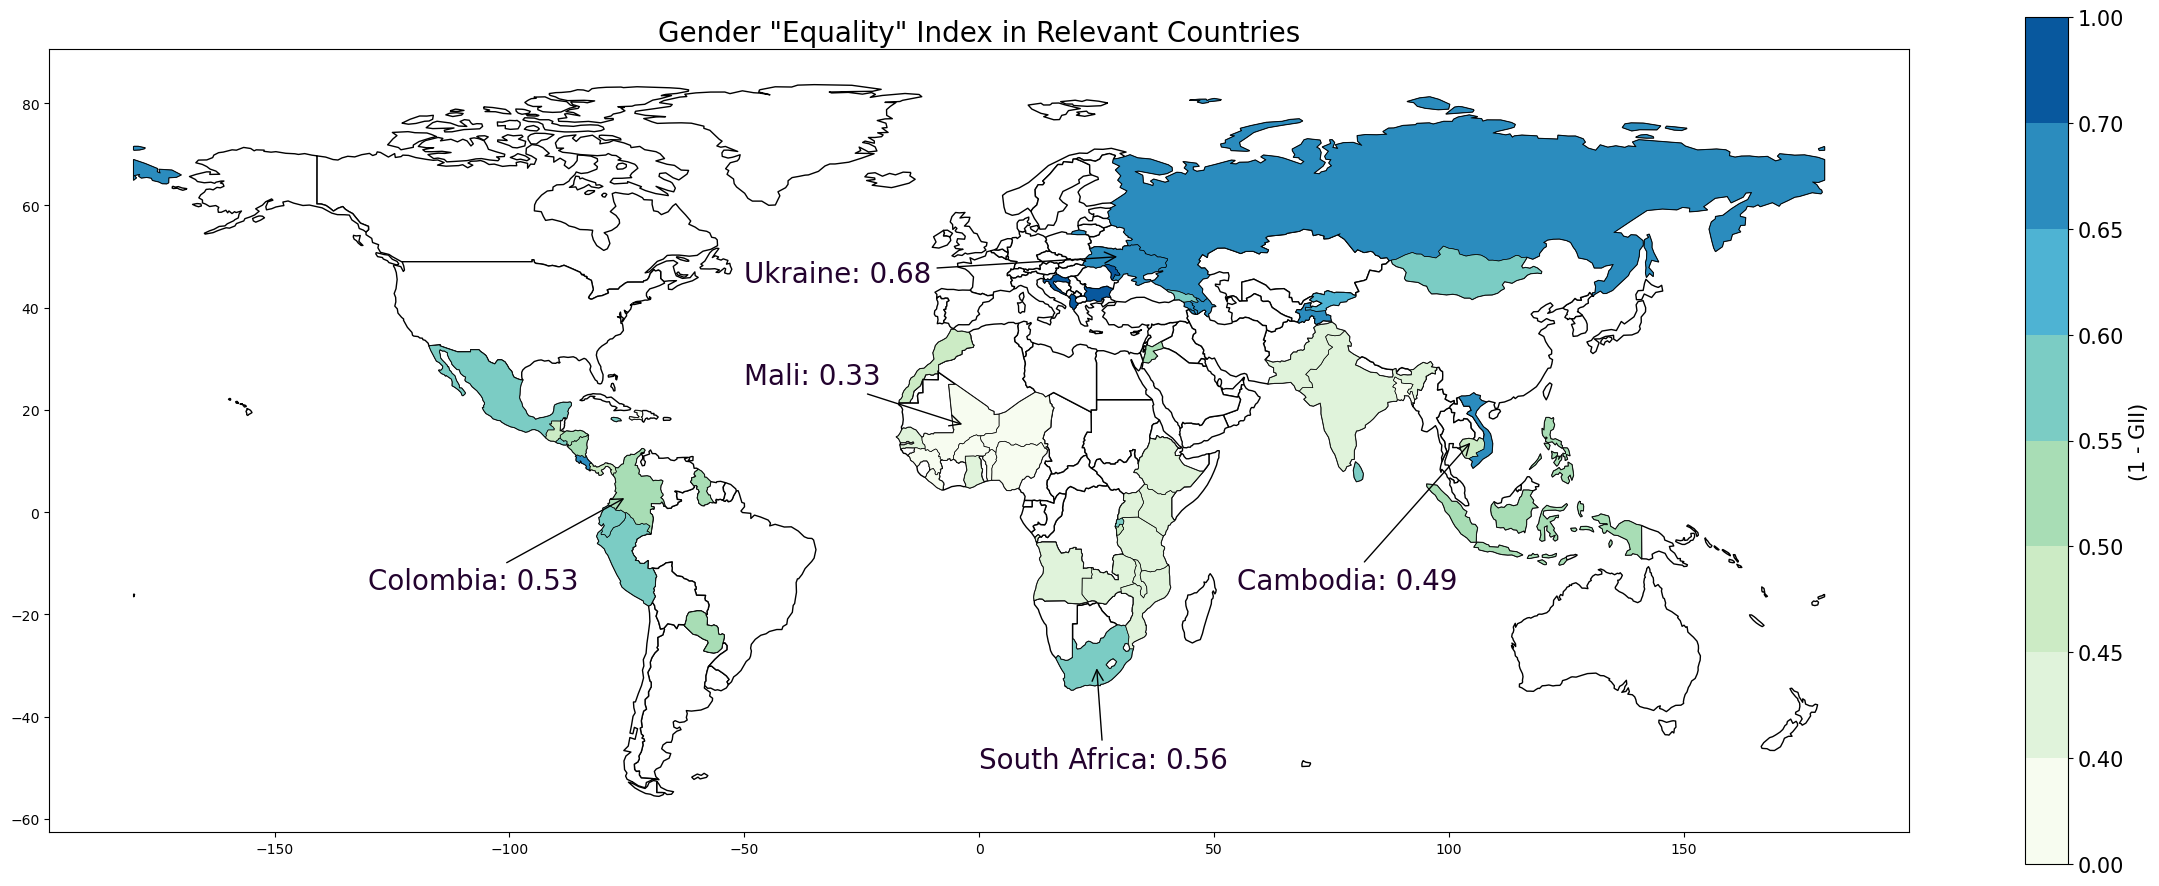

In [162]:
# Fix different naming conventions
df_gii = df_gii.rename({'Viet Nam': 'Vietnam', 'Tanzania (United Republic of)': 'Tanzania', 
                        'Russian Federation': 'Russia', 'Moldova (Republic of)': 'Moldova'})
world_dropped['Gender Equality Index'] = 1-df_gii['gii_2010']

fig, gax = plt.subplots(figsize=(30,11))


# Define the color map
cmap = ListedColormap(['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'])

# Set the intervals for the color map
bounds = [0, 0.4, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 1]
norm = BoundaryNorm(bounds, len(cmap.colors))

world.plot(ax=gax, edgecolor='black', color = 'white')
world_dropped.plot(ax=gax, edgecolor='black', column='Gender Equality Index', cmap=cmap, norm=norm,
                 linewidth=0.5, legend=True)

cb_ax = fig.axes[1]
#cb_ax.set_yticks(bounds, ['0%', '5%', '10%', '12.5%', '15%', '17.5%', '20%', '40%', '100%'])
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('(1 - GII)', size=15)

gax.set_title('Gender "Equality" Index in Relevant Countries', fontsize=20)

plt.annotate('Cambodia: 0.49', xy=(105, 14), xytext=(55, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Colombia: 0.53', xy=(-75, 3), xytext=(-130, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Mali: 0.33', xy=(-3, 17), xytext=(-50, 25), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('South Africa: 0.56', xy=(25, -30), xytext=(0, -50), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Ukraine: 0.68', xy=(30, 50), xytext=(-50, 45), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))


plt.show()

The GII measure inequality on a scale of 0 to 1, with 0 meaning no inequality (perfect equality). However, we want lower values to mean more inequality since we are comparing this index to share of loans to women, and average loan size for women compared to men (smaller values means more inequality). 

So we will define the suitably named Gender Equality Index as:

<h10><center>$GEI = 1 - GII$</center></h10>

Thus on the GEI scale, 1 means perfect equality, with smaller numbers from 0 to 1 meaning more inequality.

In the map above, we plotted the GEI of relevant countries. Like GDP, we used the 2010 measure since it is somewhere in between 1999-2017 when the DCA program was in operation. Note some countries are missing (e.g. Russia) since the GEI was unavailable. Regions in the Middle East and Europe have the standout GEIs, while regions in Africa have the most inequality.

Comparing this graph to the Share of Loans graph, there does not seem to be a clear correlation between the Gender Equality of the Country and the share of loans women receive under the DCA. The main sticking point is that in the Middle East/Eurasia, which are the most equal of the countries in our dataset, have the fewest loans to women! The exception to this is Ukraine.

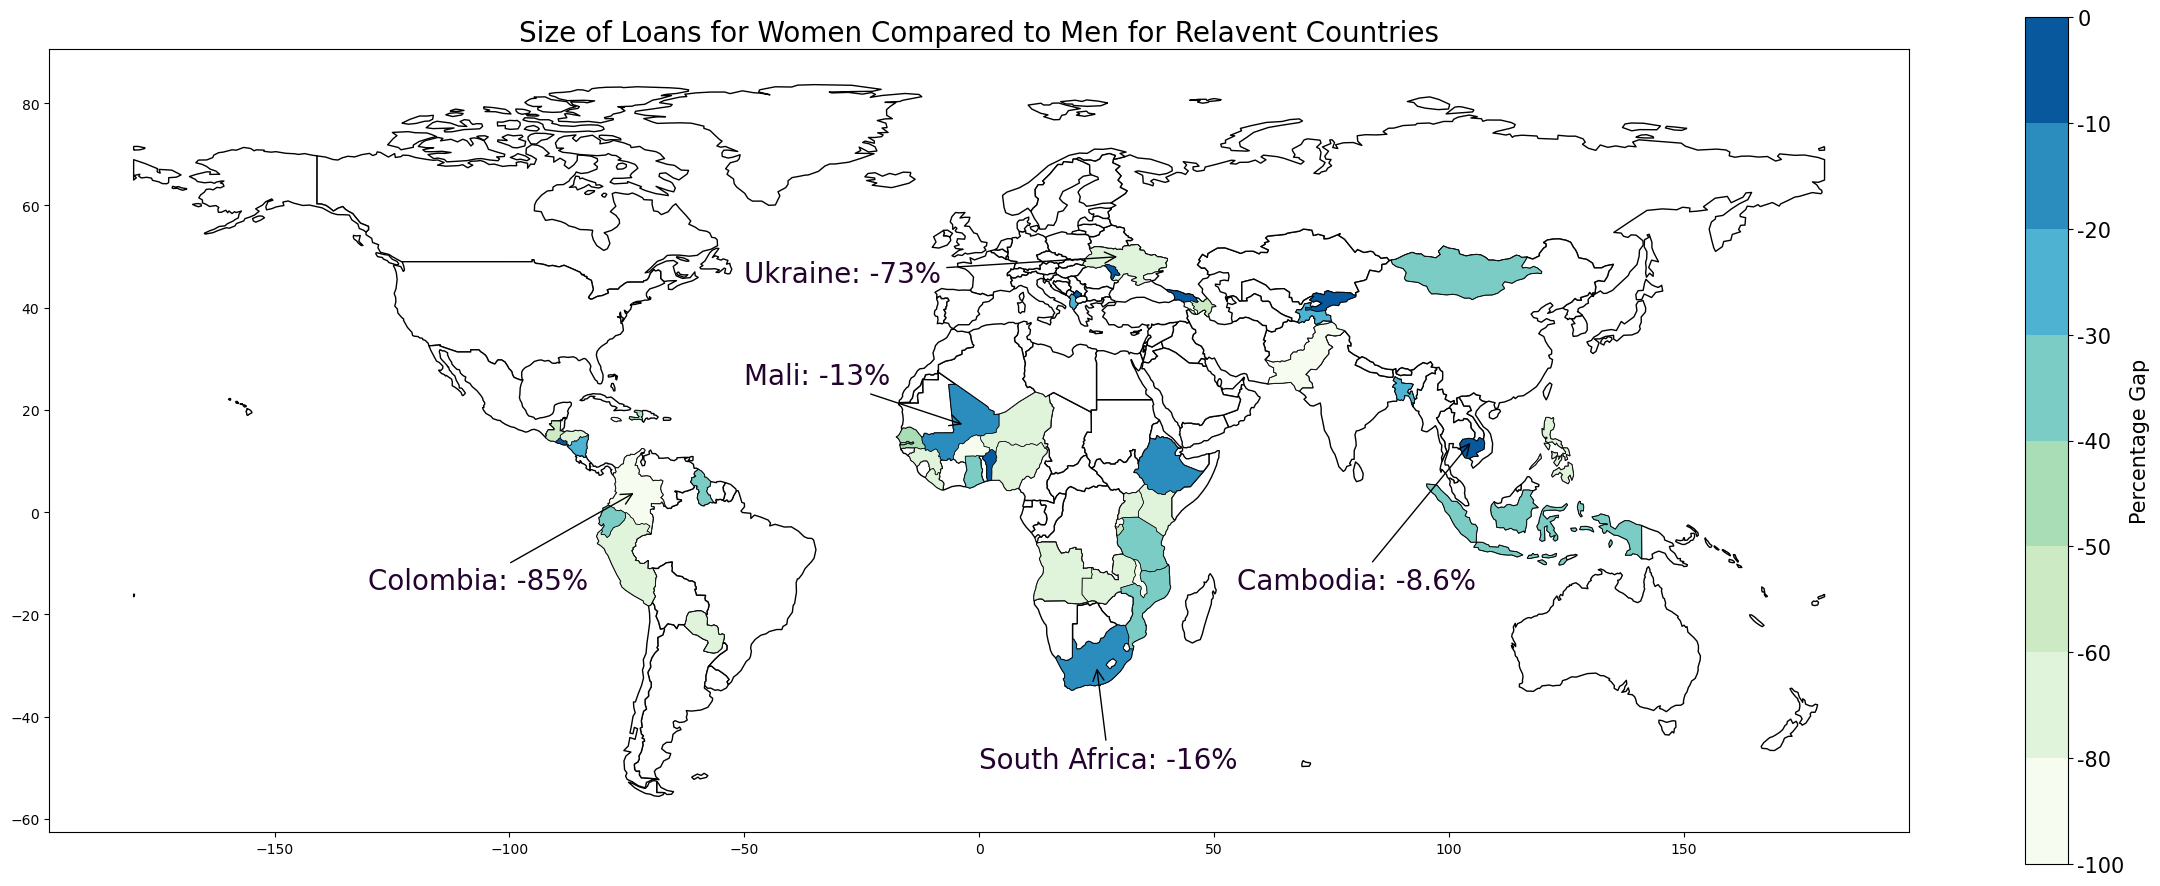

In [163]:
###### Calculate the median and mean amount by region and whether it's woman-owned
grouped = df.groupby(['Guarantee Country Name', 'Is Woman Owned?'])['Amount (USD)'].agg('mean').reset_index()

# Calculate the overall median and mean amount for woman-owned and not woman-owned separately
overall_mean_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].mean()
overall_mean_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].mean()

pivot_table = pd.pivot_table(grouped, index='Guarantee Country Name', columns='Is Woman Owned?', values=['Amount (USD)'])
pivot_table.loc['BASELINE'] = [overall_mean_not_woman, overall_mean_woman]

# Calculate the percent difference between woman-owned and not woman-owned for the median and mean columns
pivot_table['Percentage Diff Mean'] = ((pivot_table['Amount (USD)'][1.0] - pivot_table['Amount (USD)'][0.0]) / pivot_table['Amount (USD)'][0.0]) * 100

world_dropped['Gender Gap'] = pivot_table['Percentage Diff Mean'].dropna()

fig, gax = plt.subplots(figsize=(30,11))

# Define the color map
cmap = ListedColormap(['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'])

# Set the intervals for the color map
bounds = [-100, -80, -60, -50, -40, -30, -20, -10, 0]
norm = BoundaryNorm(bounds, len(cmap.colors))

world.plot(ax=gax, edgecolor='black', color = 'white')
world_dropped.plot(ax=gax, edgecolor='black', column='Gender Gap', cmap=cmap, norm=norm,
                 linewidth=0.5, legend=True)

cb_ax = fig.axes[1]
cb_ax.set_yticks(bounds, [-100, -80, -60, -50, -40, -30, -20, -10, 0])
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Percentage Gap', size=15)
gax.set_title('Size of Loans for Women Compared to Men for Relavent Countries', fontsize=20)

plt.annotate('Cambodia: -8.6%', xy=(105, 14), xytext=(55, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Colombia: -85%', xy=(-73, 4), xytext=(-130, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Mali: -13%', xy=(-3, 17), xytext=(-50, 25), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('South Africa: -16%', xy=(25, -30), xytext=(0, -50), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Ukraine: -73%', xy=(30, 50), xytext=(-50, 45), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))

plt.show()

FInally, we plotted the average size of loans for women compared to men in the countries in our dataset. Recall this was the disparity or loan gender gap measure that led us to explore whether institutional gender equality in countries was causing smaller average loan sizes for women.

Right away, it is clear that the percentage loan gap is least apparent in the regions in southeast Asia. For example, in Cambodia, loans under the DCA were only 8.6% smaller for women than men. Not insignificant, but better than the average (79% smaller loans). Also there are a number of outliers, a few of which we highlighted.

The key insight comes when we compare this map to the GEI map. Besides the number of outliers such as Mali: low disparity and GEI (-6.1%, 0.33), South Africa high disparity and medium GEI (-87%, 0.56), higher disparity in loan size seems to correlate to a lower GEI and vice versa. 
- Regions in Eurasia with lower disparities (darker blue), have better GEIs (darker blue). 
- Regions in Asia with lower disparities (darker blue), have middling GEIs (greenish-blue). 
- Finally excluding the outliers in Africa such as Mali and South Africa, most areas have high disparities (light green) and low GEIs (light green).
- In South America we have (excluding the outliers) high disparities (light green) middling GEIs (greenish-blue).

The correlation is not perfect, but perhaps we are on to something! This relationship is formalized in the next section.

# Project 3

## Potential Data to Scrape


#### Introduction to World Bank Indicators

One unanswered question we still have about the loan gender gap is what is the systemic cause of it? We have found some evidence that varying levels systemic inequality, proxied by the GII, is potentially correlated to this disparity. However one limitation is that this indicator is too broad to suggest any specific changes to the DCA or other foreign aid programs. What does it mean to tackle gender inequality in the context of entrepreneurship?

Indeed, world bank actually tracks many relevant statistics of female entrepreneurship rates in many developing countries! This will be a breakthrough to uncover how financial regulations, current business ownership, and borrowing tendencies interact with the number and amount of loans women receive under the DCA program. The indicators we will retrieve From the World Bank are briefly explained below.

*Women Business and Law Entrepreneurship Score*
   - Description: "The Entrepreneurship indicator measures constraints on women starting and running a business." Each question is given a weight of 25 accordingly, and a score of 100 is the ideal for gender equality. The questions are:
        1. Does the law prohibit discrimination in access to credit based on gender?
        2. Can a woman sign a contract in the same way as a man; 
        3. Can a woman register a business in the same way as a man?
        4. Can a woman open a bank account in the same way as a man?
   - Theory: Legal obstacles could be resulting in fewer and smaller loans for women.
    
*Firms with female participation in ownership (% of firms)*
   - Description: "Firms with female participation in ownership are the percentage of firms with a woman among the principal owners."
   - Theory: Low female loan rates is a reflection of low female entrepreneurship rates.

#### API Availability & Procedure

The data is freely available through the World Bank's API. The general API documentation is available here: https://documents.worldbank.org/en/publication/documents-reports/api

And the API designed for Python that we will use is available here:
https://pypi.org/project/wbgapi/

Since this data is by country, we will merge it to our dataframes created in the "Maps and Interpretations" section in Project 2, which contains data by country and the statistics of interest: Percentage Women Owned and the Gender Loan Gap in the DCA program by country. We will use a left merge technique to ensure all data contained in our original dataframe is preserved.

Using this data we will test the theories we proposed above, and better understand the reasons behind the effects of gender on loan frequencies and sizes in the DCA program. With this knowledge, hopefully we can propose some concrete improvements to the DCA program and similar foreign aid programs to increase women entrepreneurship.

## Potential Challenges

Fortunately the World Bank is a well-documented and clearly structured API. The main challenge is to learn understand the features of the API and how to access the data. However, there are still some potential challenges to be aware of before beginning:
- Availability of Data: Some indicators have only data for a handful of countries, so is unavailable for the majority of countries in the DCA dataset. The 4 indicators that we have selected were carefully chosen to ensure this will not be a huge problem. 
- Year of Data: Many indicators were established in the late 2010s, and/or only have obtained data since the late 2010s. When merging our data we will need to be conscious of the year of these indicator since these values may have changed. Ultimately, we will have to obtain data within 1999-2016 if possible, and otherwise use what is available with caution. Averaging the available data from 1999-2016 is the solution we will use.

## Scraping Data from a Website


In [164]:
#!pip install wbgapi  # Uncomment to install if necessary
import wbgapi as wb
wb.db = 14  # Change default database to 14 (Gender Stats)

First, we need to install and import the World Bank API. Then we will change the default database to the Gender Statistics database.

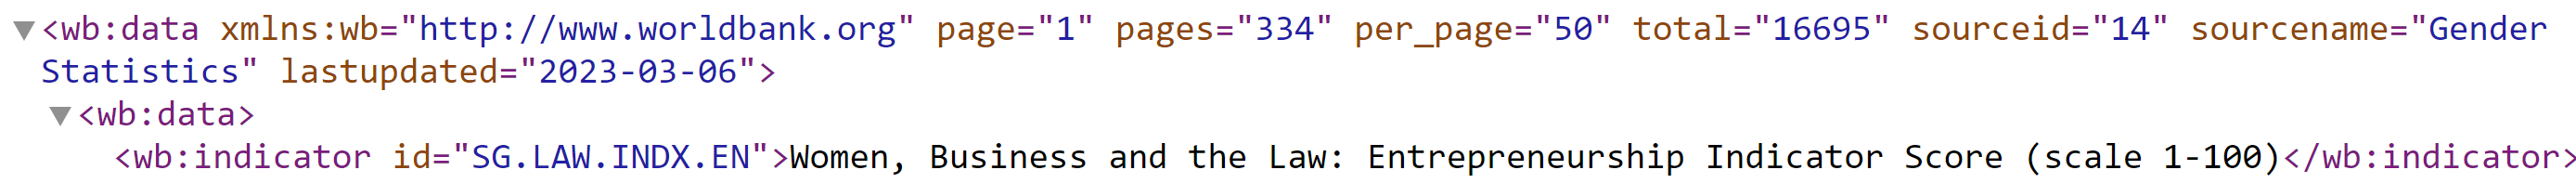

There is specific id associated with each indicator. For example, the Entrepreneurship Indicator Score has the id *SG.LAW.INDX.EN*. This information can be found in the API source code (as shown above) or in the table by calling `wb.series.info()`. The ids of the indicators of interest are:
- *SG.LAW.INDX.EN* - Women Business and Law Entrepreneurship Score
- *IC.FRM.FEMO.ZS* - Firms with female participation in ownership (% of firms)

Using these ids, we can easily query for the specific indicator into a dataframe using `wb.data.DataFrame()` method.

## Merging the Scraped Dataset

In [165]:
dca_indicators = world_dropped.set_index('iso_a3')
dca_indicators['Country Name'] = world_dropped.index
dca_indicators = dca_indicators.drop('-99') # Kosovo is a partially recognized state so most indicators are missing

Recall that `world_dropped` is the DataFrame containing the interesting statistics in the DCA program we plotted in the maps section. This includes the percentage of women owned business and the loan gender gap by country. We renamed it above to be `dca_indicators`.

In [166]:
female_participation = wb.data.DataFrame('IC.FRM.FEMO.ZS', time=range(1999,2017), numericTimeKeys=True).mean(axis=1)
female_participation.name = 'female participation in ownership'
dca_indicators = pd.merge(dca_indicators, female_participation, how='left', left_index=True, right_index=True)

df['index'] = df.index # Save current indexes
df = df.set_index("ISO_Code") # Set ISO_Code as index
df = pd.merge(df, female_participation, how='left', left_index=True, right_index=True) # Merge using ISO__Code

Above we queried the IC.FRM.FEMO.ZS (Firms with female participation in ownership (% of firms)) indicator from 1999 to 2016 and took the mean. We will call this new indicator the "Female Participation Rate in Ownership". Remember taking the mean is to capture on average the value of the indicator during when the DCA was in operation. We then used a left merge to `dca_indicators` and the original `df` dataset.

In [167]:
e_score = wb.data.DataFrame('SG.LAW.INDX.EN', time=range(1999,2017), numericTimeKeys=True).mean(axis=1)
e_score.name = 'Entrepreneurship Score'
dca_indicators = pd.merge(dca_indicators, e_score, how='left', left_index=True, right_index=True)

df = pd.merge(df, e_score, how='left', left_index=True, right_index=True) # Merge using ISo_Code
df['ISO_Code'] = df.index # Save ISO_Code
df = df.set_index('index').sort_index() # Reset the indexes to original

Similarly, the SG.LAW.INDX.EN (Women Business and Law Entrepreneurship Score) indicator from 1999 to 2016, took the mean, and merged to the `dca_indicators` and `df` datasets. We will call this indicator the "Entrepreneurship Score."

## Visualizing the Scraped Dataset

### Plots Against Gender Statistics

In [168]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

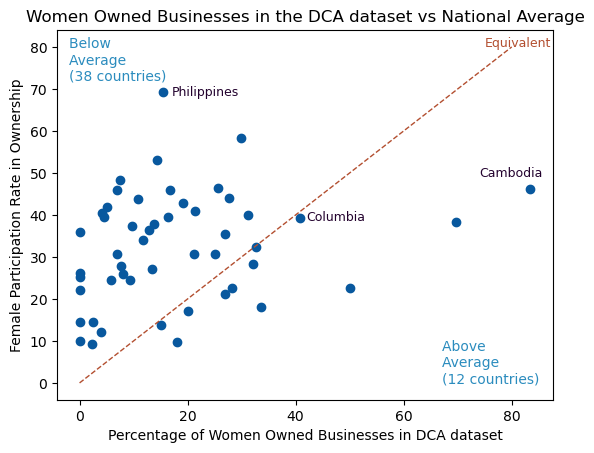

In [169]:
# Scaling entries to be percentage instead of decimal
dca_indicators['Scaled Percentage Women Owned'] = dca_indicators['Percentage Women Owned']*100

# Dropping missing values from plot
to_plot = dca_indicators[['Scaled Percentage Women Owned', 'female participation in ownership']].dropna()

# create a scatter plot of the data
plt.scatter(to_plot['Scaled Percentage Women Owned'], to_plot['female participation in ownership'], color = '#08589e')

plt.plot([0, 80], [0, 80], color = '#B34F30', linewidth = 1, linestyle='dashed')

# add axis labels and a title to the plot
plt.xlabel('Percentage of Women Owned Businesses in DCA dataset')
plt.ylabel('Female Participation Rate in Ownership')
plt.title('Women Owned Businesses in the DCA dataset vs National Average')

# Annotations
plt.annotate('Cambodia', xy=(74, 49), fontsize=9, color='#23022E')
plt.annotate('Philippines', xy=(17, 68.25), fontsize=9, color='#23022E')
plt.annotate('Columbia', xy=(42, 38.5), fontsize=9, color='#23022E')

# Counting number of countries on left and right of equivalent line
left = (to_plot['Scaled Percentage Women Owned'] < to_plot['female participation in ownership']).sum()
right = (to_plot['Scaled Percentage Women Owned'] >= to_plot['female participation in ownership']).sum()

plt.annotate('Equivalent', xy=(75, 80), fontsize=9, color='#B34F30')
plt.annotate(f'Above \nAverage \n({right} countries)', xy=(67, 0), fontsize=10, color='#2b8cbe')
plt.annotate(f'Below \nAverage \n({left} countries)', xy=(-2, 72), fontsize=10, color='#2b8cbe')

# display the plot
plt.show()

Above we plotted a scatter plot of the percentage of women owned businesses in the DCA dataset and the Female Participation Rate in Ownership (Firms with female participation in ownership (% of firms)). Clearly, the majority of loans given out by the DCA program are below the national average which is quite disappointing. In fact, this might highlight a systemic issue with the DCA program: Loans are going disproportionately to business owned by men, even in comparison to the national average!

There are a variety of limitations with this comparison however. The Female Participation Rate measures if a women is among the "principal owners" business, so a business with the majority owned by men could still be counted as "women owned". On the other hand, the DCA's definition of a "women owned" business is unclear. Nevertheless, since the vast majority of businesses are small so likely have only one owner, the effect of this may be limited.

Gender Gap KGZ: 296.00553356643496
Gender Gap BEN: 60.08181019510628


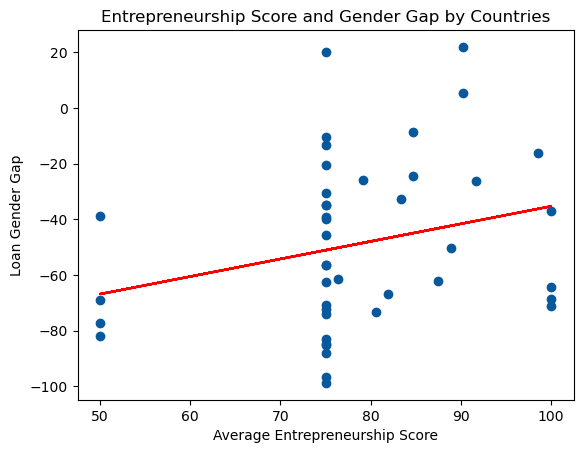

Intercept: -98.42983090620947
Slope: 0.6309701881493704
R-squared: 0.06711136568088782


In [170]:
to_plot = dca_indicators[['Entrepreneurship Score', 'Gender Gap']].dropna()

# Print and drop outliers
print(f'Gender Gap KGZ: ' + str(to_plot.loc['KGZ']['Gender Gap']))
print(f'Gender Gap BEN: ' + str(to_plot.loc['BEN']['Gender Gap']))
to_plot = to_plot.drop(['KGZ', 'BEN'])

plt.scatter(to_plot['Entrepreneurship Score'], to_plot['Gender Gap'], color = '#08589e')

# fit a linear regression model to the data
model = LinearRegression().fit(to_plot[['Entrepreneurship Score']], to_plot['Gender Gap'])

# plot the linear regression line on top of the scatter plot
plt.plot(to_plot['Entrepreneurship Score'], model.predict(to_plot[['Entrepreneurship Score']]), color='red')

# add axis labels and a title to the plot
plt.xlabel('Average Entrepreneurship Score')
plt.ylabel('Loan Gender Gap')
plt.title('Entrepreneurship Score and Gender Gap by Countries')

plt.show()

# get the intercept and slope of the linear regression model
intercept = model.intercept_
slope = model.coef_[0]

# get the R-squared value of the linear regression model
r_squared = model.score(to_plot[['Entrepreneurship Score']], to_plot['Gender Gap'])

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")
print(f"R-squared: {r_squared}")

Above we plotted the relationship between the Gender Loan Gap and the Average Entrepreneurship Score Indicators. There seems to be a small positive correlation between the Average Entrepreneurship Score and the Loan Gender Gap. As the Entrepreneurship Score increases (i.e. more equal laws protecting female entrepreneurs), we see the gender gap shrink (less negative)! This is an expected result, but we must emphasize that we have not established that better entrepreneurship laws for females (measured by Entrepreneurship Score) result in a smaller (less negative) gender loan gap.

Note we dropped two extreme outliers in our `dca_indicators` from our plot: Kyrgyzstan (KGZ) and Benin (BEN). Both have extremely positive Gender Loan Gaps (over 60%), indicating loans for women are 60% larger for women than men. This seems highly likely due to a error from a limited sample from these countries, so we removed them to not affect the analysis.

We will avoid reading too much into the the intercept/slope/r-squared values since we have only a limited number of data points, and they are provided for sake of completeness.

### Maps of Scraped Data

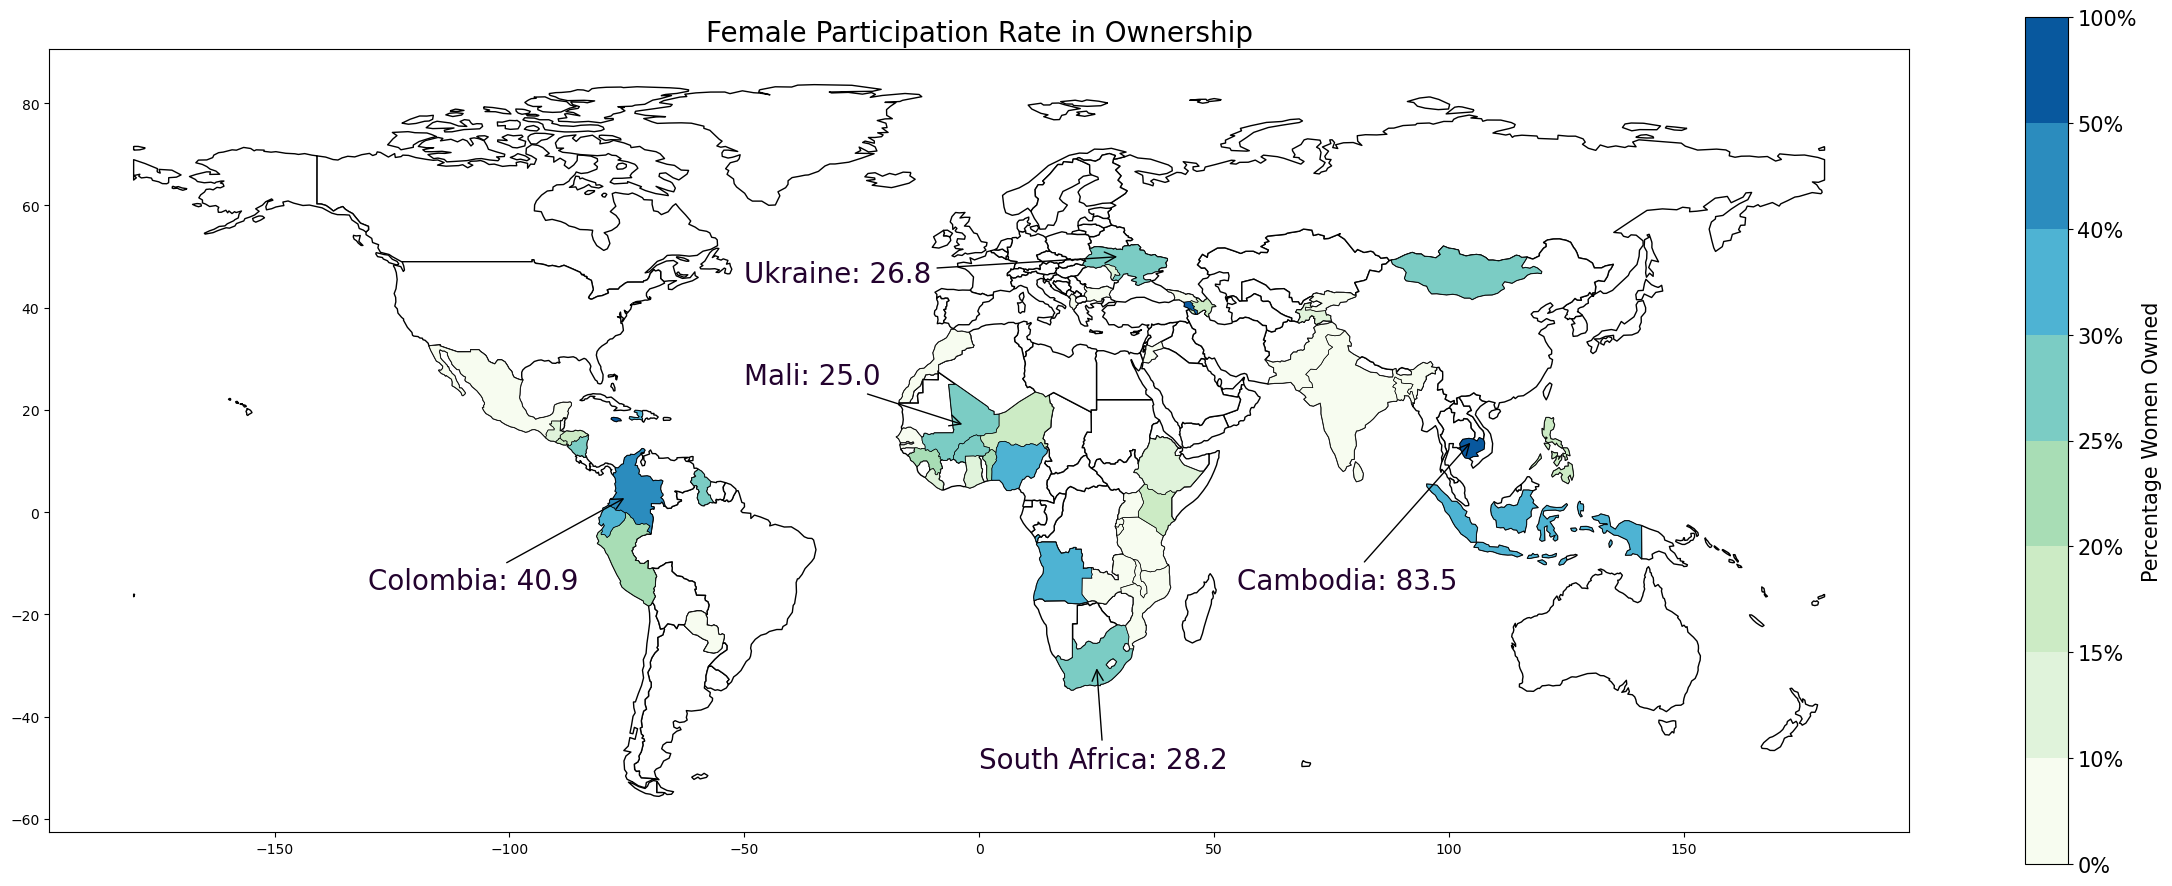

In [171]:
to_plot = world_dropped.set_index('iso_a3')
to_plot['Percentage Women Owned'] = dca_indicators['Percentage Women Owned']

fig, gax = plt.subplots(figsize=(30,11))


# Define the color map
cmap = ListedColormap(['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'])

# Set the intervals for the color map
bounds = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1]
norm = BoundaryNorm(bounds, len(cmap.colors))

world.plot(ax=gax, edgecolor='black', color = 'white')
to_plot.plot(ax=gax, edgecolor='black', column='Percentage Women Owned', cmap=cmap, norm=norm,
                 linewidth=0.5, legend=True)

cb_ax = fig.axes[1]
cb_ax.set_yticks(bounds, ['0%', '10%', '15%', '20%', '25%', '30%', '40%', '50%', '100%'])
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Percentage Women Owned', size=15)

gax.set_title('Female Participation Rate in Ownership', fontsize=20)

plt.annotate('Cambodia: 83.5', xy=(105, 14), xytext=(55, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Colombia: 40.9', xy=(-75, 3), xytext=(-130, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Mali: 25.0', xy=(-3, 17), xytext=(-50, 25), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('South Africa: 28.2', xy=(25, -30), xytext=(0, -50), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Ukraine: 26.8', xy=(30, 50), xytext=(-50, 45), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))


plt.show()

Above we plotted the indicator the Female Participation Rate in Ownership in countries in the DCA dataset.

Cambodia is outstanding as found in the previous scatter plot with a female participation rate of 83.5% in business ownership. Indeed, it seems many countries south-east Asia have higher rates. Countries in Africa seem to have lower rates of female participation in business ownership, with the notable exception being Colombia. 

This relationship between regions and this indicator will be important to keep in mind when we run regressions to avoid multicollinearity problems

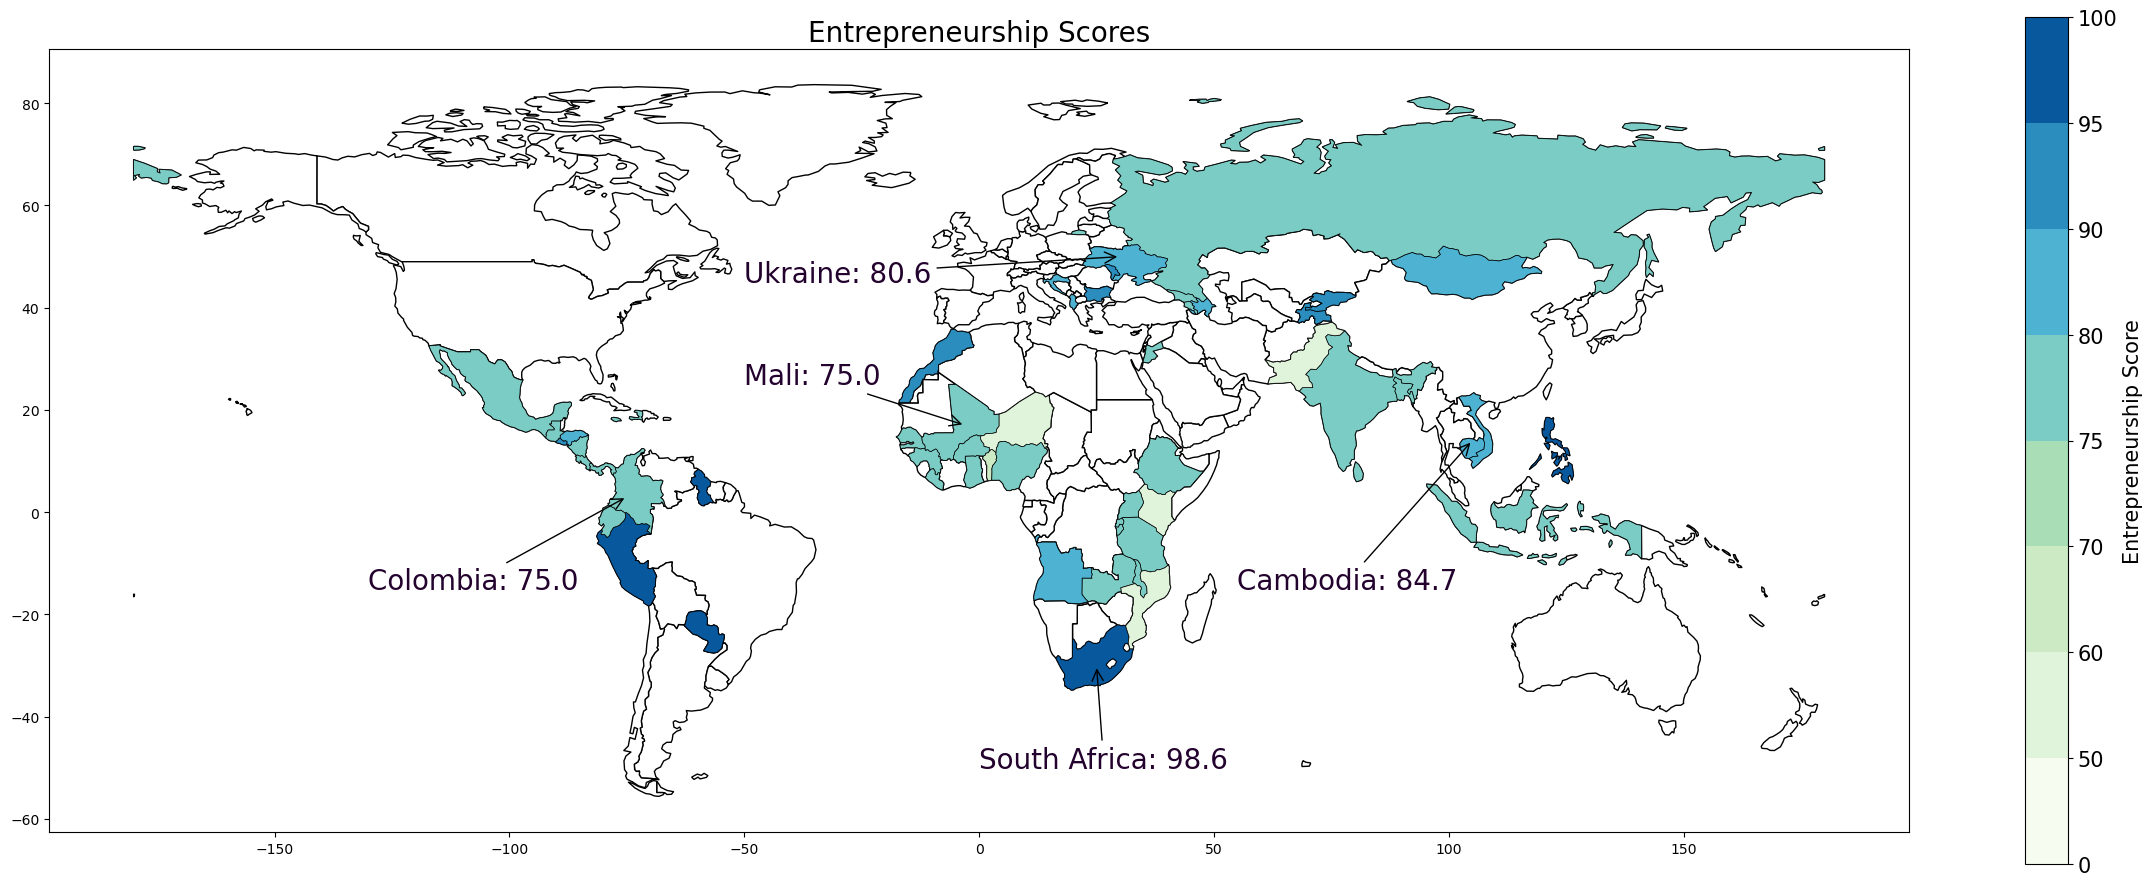

In [172]:
to_plot = world_dropped.set_index('iso_a3')
to_plot['Entrepreneurship Score'] = dca_indicators['Entrepreneurship Score']

fig, gax = plt.subplots(figsize=(30,11))


# Define the color map
cmap = ListedColormap(['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'])

# Set the intervals for the color map
bounds = [0, 50, 60, 70, 75, 80, 90, 95, 100]
norm = BoundaryNorm(bounds, len(cmap.colors))

world.plot(ax=gax, edgecolor='black', color = 'white')
to_plot.plot(ax=gax, edgecolor='black', column='Entrepreneurship Score', cmap=cmap, norm=norm,
                 linewidth=0.5, legend=True)

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Entrepreneurship Score', size=15)

gax.set_title('Entrepreneurship Scores', fontsize=20)

plt.annotate('Cambodia: 84.7', xy=(105, 14), xytext=(55, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Colombia: 75.0', xy=(-75, 3), xytext=(-130, -15), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Mali: 75.0', xy=(-3, 17), xytext=(-50, 25), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('South Africa: 98.6', xy=(25, -30), xytext=(0, -50), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))
plt.annotate('Ukraine: 80.6', xy=(30, 50), xytext=(-50, 45), fontsize=20, color='#23022E', arrowprops=dict(arrowstyle="->"))


plt.show()

Above we plotted the Entrepreneurship Score indicator for countries in the DCA dataset.

Female Entrepreneurship Scores are the highest in Latin America, Europe, and Asia, and lower in Africa. Notice how generally there is a positive correlation between the Entrepreneurship Scores and the Female Participation Rate. This result will be more formally studied in the "Multicollinearity of Indicators" section of the Final Project.

This relationship between regions and this indicator will be important to keep in mind when we run regressions to avoid multicollinearity problems

### Other Scatter Plots

Below we will plot the relationships we conjectured in the "Maps and Interpretations" section. Recall we proposed the following two results:
1. GEI & Gender Loan Gap: A larger (more negative) Gender Loan Gap correlates with a lower GEI (Gender Equality Index)
2. GDP Per Capita & Average Loan Size: Richer countries (higher GDP Per Capita) tend to receive smaller loans

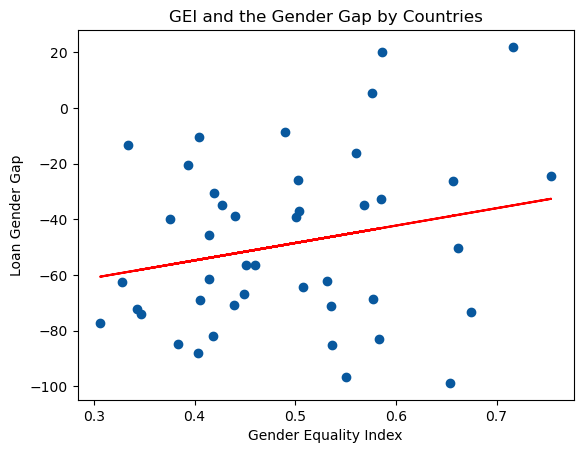

Intercept: -79.77030732993055
Slope: 62.50451891539135
R-squared: 0.05242115827213367


In [173]:
to_plot = dca_indicators[['Gender Equality Index', 'Gender Gap']].dropna()

# Drop outliers
to_plot = to_plot.drop(['KGZ', 'BEN'])

plt.scatter(to_plot['Gender Equality Index'], to_plot['Gender Gap'], color = '#08589e')

# fit a linear regression model to the data
model = LinearRegression().fit(to_plot[['Gender Equality Index']], to_plot['Gender Gap'])

# plot the linear regression line on top of the scatter plot
plt.plot(to_plot['Gender Equality Index'], model.predict(to_plot[['Gender Equality Index']]), color='red')

# add axis labels and a title to the plot
plt.xlabel('Gender Equality Index')
plt.ylabel('Loan Gender Gap')
plt.title('GEI and the Gender Gap by Countries')

plt.show()

# get the intercept and slope of the linear regression model
intercept = model.intercept_
slope = model.coef_[0]

# get the R-squared value of the linear regression model
r_squared = model.score(to_plot[['Gender Equality Index']], to_plot['Gender Gap'])

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")
print(f"R-squared: {r_squared}")


Above we plotted the relationship between the GEI and the Gender Gap. Note we dropped  Kyrgyzstan (KGZ) and Benin (BEN) for the same reasons as the previous plot.

As conjectured, there is a slight positive correlation between the GEI and Gender Gap. As countries are more equal measured by the GEI, the Gender Loan Gap gets smaller (less negative)! Conversely, a larger (more negative) Gender Loan Gap correlates with a a lower GEI as we visually saw in the maps!

This correlation is expected, since the Gender Equality Index captures the economic equality between gender, which the Gender Loan gap presumably is a measure of. We will avoid reading too much into the the intercept/slope/r-squared values since we have only a limited number of data points, and they are provided for sake of completeness.

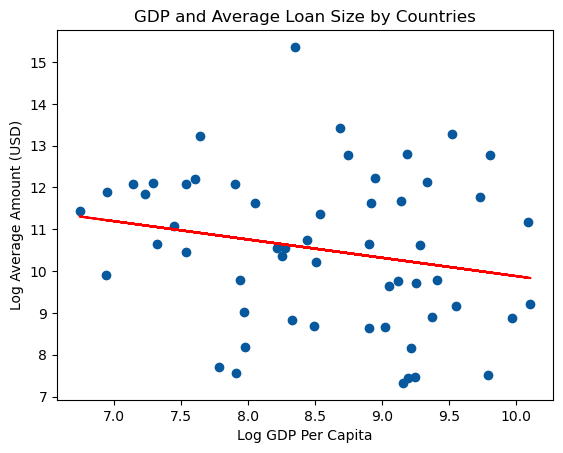

Intercept: 14.254744594400577
Slope: -0.4374589948595487
R-squared: 0.04498335929872199


In [174]:
to_plot = dca_indicators[['Average Amount (USD)', 'GDP Per Capita']].dropna()

# Apply a log transformation
to_plot = to_plot.apply(np.log)

# create a scatter plot of the data
plt.scatter(to_plot['GDP Per Capita'], to_plot['Average Amount (USD)'], color = '#08589e')

# fit a linear regression model to the data
model = LinearRegression().fit(to_plot[['GDP Per Capita']], to_plot['Average Amount (USD)'])

# plot the linear regression line on top of the scatter plot
plt.plot(to_plot['GDP Per Capita'], model.predict(to_plot[['GDP Per Capita']]), color='red')

# add axis labels and a title to the plot
plt.xlabel('Log GDP Per Capita')
plt.ylabel('Log Average Amount (USD)')
plt.title('GDP and Average Loan Size by Countries')

# display the plot

plt.show()

# get the intercept and slope of the linear regression model
intercept = model.intercept_
slope = model.coef_[0]

# get the R-squared value of the linear regression model
r_squared = model.score(to_plot[['GDP Per Capita']], to_plot['Average Amount (USD)'])

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")
print(f"R-squared: {r_squared}")

Above we plotted the relationship between the log of Average Loan Amount vs. log of GDP per Capita. More details about the justification behind taking the log of these amounts is discussed in the "OLS Regression" in the Final Project, but it boils down to that these values are exponentially distributed.

There is a clear negative correlation between GDP Per Capita and Average Loan Amounts. Countries that have higher GDP Per Capita have lower average loan amounts, which is our conjecture from mapping! This is a really counter-intuitive result, since you would expect loans for businesses to get bigger as countries become richer and have bigger businesses. However, if we recall the DCA's purpose, this might actually be a good indication. 

Recall speculative explanation of this phenomenon could be that richer countries tend to have more developed financial institutions that operate in a less risky environment. Thus they are more willing to bear the risk to loan to smaller businesses of smaller amounts. Thus the DCA program would only need to step in to incentivise banks to give those very small loans, resulting in loans backed by the DCA program being very small in richer countries, and vice versa. This result means that the DCA program is doing its job for mobilizing credit for underserved markets and not simply funding loans that would have happened anyways!

We will avoid reading too much into the the intercept/slope/r-squared values since we have only a limited number of data points, and they are provided for sake of completeness.

## Merging with a New Dataset (Part 2)

**This is a continuation of "Merging with a New Dataset (Part 1)" available in Project 1**

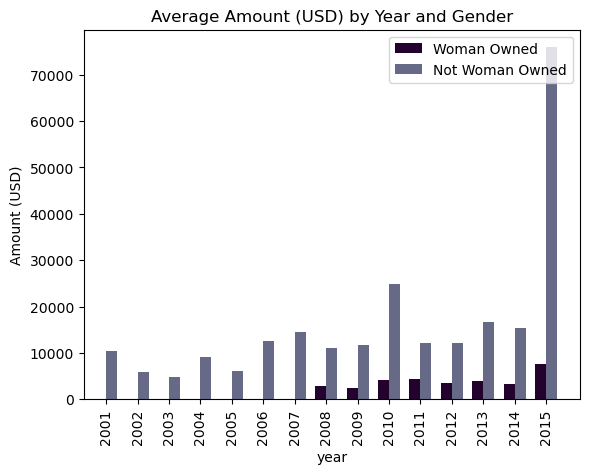

In [175]:
df1 = df['year'].value_counts()
df1 = df1.drop([2000, 2016])

pivot_df = df.get(['year', 'Amount (USD)', 'Is Woman Owned?']).fillna(0.0).pivot_table(
    values='Amount (USD)', index='year', columns='Is Woman Owned?', aggfunc=np.mean)
pivot_df = pivot_df.drop([2000, 2016])
pivot_df = pivot_df.reindex(df1.index)
pivot_df = pivot_df.sort_index()

fig, ax = plt.subplots()

width = 0.35
labels = pivot_df.index.tolist()

x = np.arange(len(labels))

rects1 = ax.bar(x - width/2, pivot_df[1.0], width, label='Woman Owned', color='#23022E')
rects2 = ax.bar(x + width/2, pivot_df[0.0], width, label='Not Woman Owned', color='#666A86')

ax.set_xlabel('year')
ax.set_ylabel('Amount (USD)')
ax.set_title('Average Amount (USD) by Year and Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

plt.show()

Above the plotted the familiar plot of Average Loan Amounts by Year and Gender. Note since we don't have gender data for prior to 2008, interpret those bars as the entire loan dataset average. 

Over the years, average loan amounts seems to have increased, as one might expect perhaps because of inflation. Also to note, in 2015, there seems to have been a large increase in average loan amounts. This may be sampling error since the dataset that year was smaller from the previous plot (under Project 1).

It is clear there is a persistent gender loan gap throughout the years. Women entrepreneurs receive smaller loans than men.

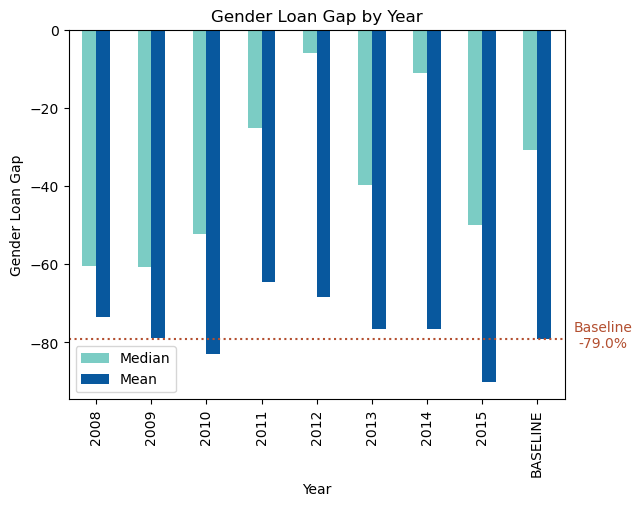

In [176]:
##### Calculate the median and mean amount by region and whether it's woman-owned
grouped = df.groupby(['year', 'Is Woman Owned?'])['Amount (USD)'].agg(['median', 'mean']).reset_index()
grouped = grouped.drop(16)

# Calculate the overall median and mean amount for woman-owned and not woman-owned separately
overall_median_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].median()
overall_mean_woman = df[df['Is Woman Owned?'] == 1.0]['Amount (USD)'].mean()
overall_median_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].median()
overall_mean_not_woman = df[df['Is Woman Owned?'] == 0.0]['Amount (USD)'].mean()

# Add a 'Baseline' row to the pivot table with the overall median and mean values
pivot_table = pd.pivot_table(grouped, index='year', columns='Is Woman Owned?', values=['median', 'mean'])
pivot_table.loc['BASELINE'] = [overall_mean_not_woman, overall_mean_woman, overall_median_not_woman, overall_median_woman]

# Calculate the percent difference between woman-owned and not woman-owned for the median and mean columns
pivot_table['Percentage Diff Median'] = ((pivot_table['median'][1.0] - pivot_table['median'][0.0]) / pivot_table['median'][0.0]) * 100
pivot_table['Percentage Diff Mean'] = ((pivot_table['mean'][1.0] - pivot_table['mean'][0.0]) / pivot_table['mean'][0.0]) * 100

# Plot the bar graph
ax = pivot_table[['Percentage Diff Median', 'Percentage Diff Mean']].plot(kind='bar', color=['#7bccc4','#08589e'])
ax.legend(['Median', 'Mean'])
ax.set_xlabel('Year')
ax.set_ylabel('Gender Loan Gap')
plt.axhline(y=0, linewidth=0.7, color='black')
ax.set_title('Gender Loan Gap by Year')

plt.axhline(y=-79.0, linestyle='dotted', color='#B34F30')
plt.text(9.2, -82, 'Baseline\n-79.0%', color='#B34F30', fontsize=10, ha='center', va='bottom')
plt.show()

Above is the familiar Gender Loan Gap plot over the years.

2011 was the most equal (-65% Gender Gap), but otherwise, there does not seem to be any clear relationship between the year and the Gender Loan Gap. The Gender Loan Gap is persistent throughout the years, and there is no trend towards more equality. Furthermore, the difference between mean and median as found for other variables continues to be present, indicating that the main reason behind this disparity is the lack of larger loans going to women.

# Final Project

## OLS Regressions

### Data Setup

In [177]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
from scipy.stats import norm, expon

In [178]:
df_regression = df[['Amount (USD)', 'Business Sector', 'Region Name', 'Is Woman Owned?', 'Is First Time Borrower?',
                    'Business Size', 'GII 2010', 'GDP per Capita 2010', 'female participation in ownership',
                   'Entrepreneurship Score', 'year']].copy()


df_regression = pd.get_dummies(df_regression, drop_first=True) # Create k-1 dummy variables
df_regression['const'] = 1
df_regression['year'] = df_regression['year'].astype('float64') # Convert year to a float

Above we imported relevant Regression models, and created `df_regression` which contains all the variables which we are interested in regressing. 

A notable omission is 'Guarantee Country Name' since it is impractical to create dummy variables for so many countries. Instead we will use relevant indicators such as GDP, GII (Gender Inequality Index, defined as 1-GEI), and the Entrepreneurship Score. 

We created dummy variables using `get_dummies`, ensuring to drop one column to avoid redundancy. We added a column of ones for the fixed effect.

### Logarithmic Transformation of Loan Amounts

#### Justification of Logarithmic Transformation

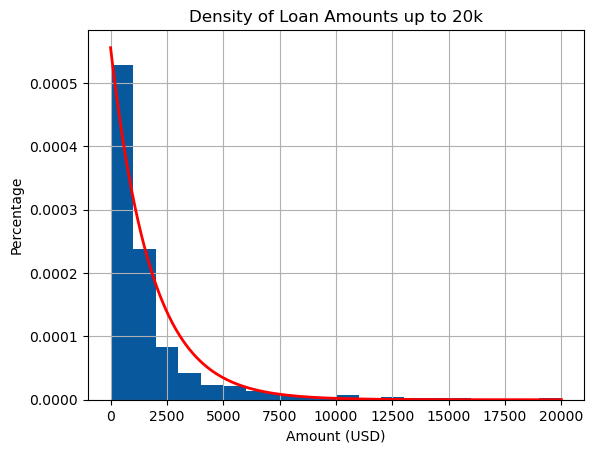

In [179]:
bins = range(0, 20001, 1000)

# plot the histogram
df_regression['Amount (USD)'].hist(bins=bins, density=True, color='#08589e')

# fit a normal distribution to the data
x = np.arange(0, 20000, 1)
p = expon.pdf(x, scale=1800)

# plot the normal distribution
plt.plot(x, p, 'r', linewidth=2)

# add labels and title
plt.xlabel('Amount (USD)')
plt.ylabel('Percentage')
plt.title('Density of Loan Amounts up to 20k')

# show the plot
plt.show()

Above we plotted the histogram distribution of loan amounts in our dataset up to 20k (the majority of loans). It roughly follows an exponential distribution.

Thus, this gives us good reason to take the natural logarithm of the loan amounts to normalize this distribution as demonstrated below. We also took the log of GDP per Capita using a similar line of reasoning.

In [180]:
df_regression[['Amount (USD)', 'GDP per Capita 2010']] = df_regression[['Amount (USD)', 'GDP per Capita 2010']].apply(np.log)

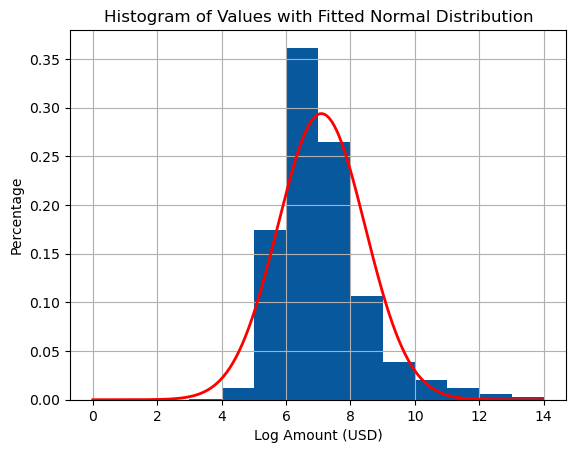

In [181]:
# specify the bin edges
bins = range(0, 15, 1)

# plot the histogram
df_regression['Amount (USD)'].hist(bins=bins, density=True, color='#08589e')

# fit a normal distribution to the data
mu, std = norm.fit(df_regression['Amount (USD)'].dropna())
x = np.arange(0, 14, 0.05)
p = norm.pdf(x, mu, std)

# plot the normal distribution
plt.plot(x, p, 'r', linewidth=2)

# add labels and title
plt.xlabel('Log Amount (USD)')
plt.ylabel('Percentage')
plt.title('Histogram of Values with Fitted Normal Distribution')

# show the plot
plt.show()

After taking the log of the loan amounts, the distribution follows much more closely a normal distribution, which will make our linear regressions perform better. An improvement to this procedure is to plot a Q-Q plot, but these graphs should be convincing enough. A similar result is for GDP, but since it is a common transformation made in economics, we will not provide more details.

#### Interpretation of Logarithmic Transformation Results

Since we took the log of our dependent variable (y), the interpretation of our regressions will slightly be different. Let $\beta_0, \beta_1, \beta_2, ... \beta_n$ be the parameters of our regression with $n$ different independent variables (x). The linear regression gives us the estimator of $\ln \hat{y}$ as a function of realized $x$'s as shown below:

\begin{equation}
    \ln \hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n
\end{equation}

When interpreting linear regressions we assume everything is fixed except for one independent variable we are changing, say $x_i$. 

We define $\ln A = \beta_0 + \beta_1x_1 + ... + \beta_{i-1}x_{i-1} + \beta_{i+1}x_{i+1}+ ... + \beta_nx_n$ is a constant in the context of interpreting $x_i$.

The previous equation simplifies to:

\begin{align}
 \ln \hat{y} &= \ln A + \beta_ix_i\\
 \hat{y} &= Ae^{\beta_ix_i}
\end{align}

Define $\hat{y}'$ to be the estimate where everything fixed except $x_i$ increases by one. The percent change in $\hat{y}$ is given as 
\begin{align*}
 \%\Delta \hat{y} &= 100 * \frac{\hat{y}' - \hat{y}}{\hat{y}} \\
 &= 100 * \frac{Ae^{\beta_i(x_i + 1)} - Ae^{\beta_ix_i}}{Ae^{\beta_ix_i}} \\
 &= 100 (e^{\beta_i} - 1)
\end{align*}

Thus, we can interpret our parameter $\beta_i$ using this formula as the percent change in the estimate of our dependent variable (y) given a unit increase in $x_i$.

An important note is that our fixed effect $\beta_0$ cannot be interpreted using this formula since it does not have a corresponding $x_0$. This makes since we are calculating percent change, and fixed effects by definition do not change.

### Multicollinearity of Indicators

Since we have collected so many indicators for each country in the DCA dataset, it will be worthwhile to check some correlations between each indicator. If there are strong correlations between the indicators, we will have to be aware of this issue when performing model selection in the OLS Regression section.

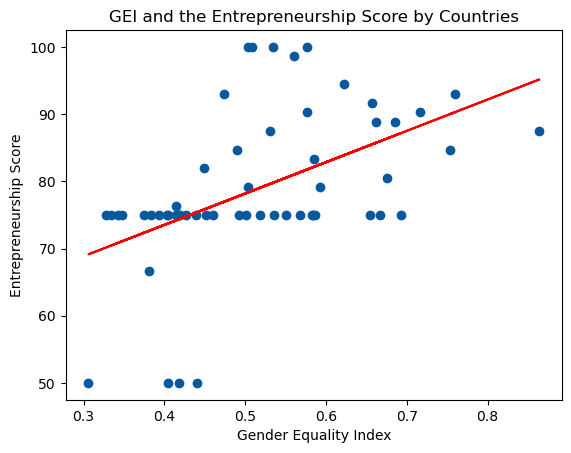

Intercept: 54.861912231501336
Slope: 46.642211059705296
R-squared: 0.24593012150200266


In [182]:
to_plot = dca_indicators[['Gender Equality Index', 'Entrepreneurship Score']].dropna()

plt.scatter(to_plot['Gender Equality Index'], to_plot['Entrepreneurship Score'], color = '#08589e')

# fit a linear regression model to the data
model = LinearRegression().fit(to_plot[['Gender Equality Index']], to_plot['Entrepreneurship Score'])

# plot the linear regression line on top of the scatter plot
plt.plot(to_plot['Gender Equality Index'], model.predict(to_plot[['Gender Equality Index']]), color='red')

# add axis labels and a title to the plot
plt.xlabel('Gender Equality Index')
plt.ylabel('Entrepreneurship Score')
plt.title('GEI and the Entrepreneurship Score by Countries')

plt.show()

# get the intercept and slope of the linear regression model
intercept = model.intercept_
slope = model.coef_[0]

# get the R-squared value of the linear regression model
r_squared = model.score(to_plot[['Gender Equality Index']], to_plot['Entrepreneurship Score'])

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")
print(f"R-squared: {r_squared}")


Above we plotted the relationship between the Gender Equality Index and the Entrepreneurship Score. Since they are both measure of gender equality, it is expected that these indicators are correlated with each other.

From the plot above, an R-squared of 0.25 indicates there is a medium level of correlation between the two indicators. This fact is important to know to avoid multicollinearity problems in our OLS Regression section. We will need to ensure our models do not include both variables at the same time.

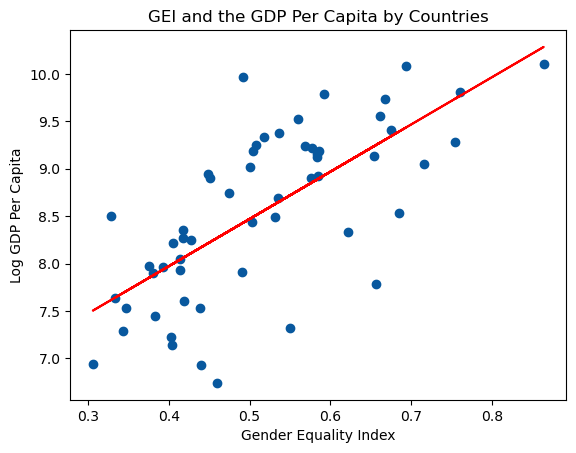

Intercept: 5.977509296166775
Slope: 4.984905165430805
R-squared: 0.49022421835295615


In [183]:
to_plot = dca_indicators[['Gender Equality Index', 'GDP Per Capita']].dropna()

# apply a logarithmic transformation to GDP Per Capita
to_plot['GDP Per Capita'] = to_plot['GDP Per Capita'].apply(np.log)

plt.scatter(to_plot['Gender Equality Index'], to_plot['GDP Per Capita'], color = '#08589e')

# fit a linear regression model to the data
model = LinearRegression().fit(to_plot[['Gender Equality Index']], to_plot['GDP Per Capita'])

# plot the linear regression line on top of the scatter plot
plt.plot(to_plot['Gender Equality Index'], model.predict(to_plot[['Gender Equality Index']]), color='red')

# add axis labels and a title to the plot
plt.xlabel('Gender Equality Index')
plt.ylabel('Log GDP Per Capita')
plt.title('GEI and the GDP Per Capita by Countries')

plt.show()

# get the intercept and slope of the linear regression model
intercept = model.intercept_
slope = model.coef_[0]

# get the R-squared value of the linear regression model
r_squared = model.score(to_plot[['Gender Equality Index']], to_plot['GDP Per Capita'])

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")
print(f"R-squared: {r_squared}")

More wealth countries tend to be be more equal unsurprisingly. We took the log of GDP to normalize the values, which will justified in the previous section. The correlation is quite strong with a R-squared of 0.49. 

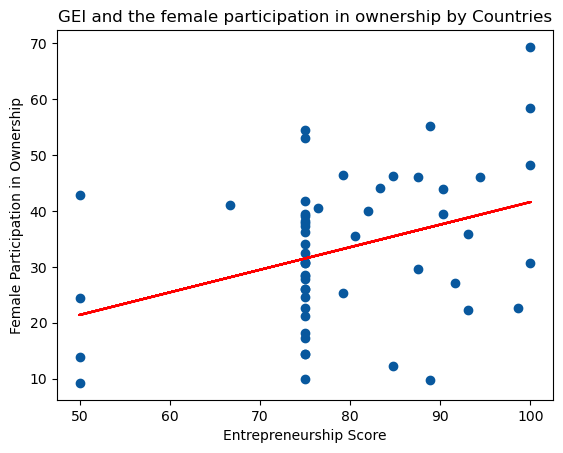

Intercept: 1.209751433739786
Slope: 0.40371551397376293
R-squared: 0.12969214430581888


In [184]:
to_plot = dca_indicators[['Entrepreneurship Score', 'female participation in ownership']].dropna()

plt.scatter(to_plot['Entrepreneurship Score'], to_plot['female participation in ownership'], color = '#08589e')

# fit a linear regression model to the data
model = LinearRegression().fit(to_plot[['Entrepreneurship Score']], to_plot['female participation in ownership'])

# plot the linear regression line on top of the scatter plot
plt.plot(to_plot['Entrepreneurship Score'], model.predict(to_plot[['Entrepreneurship Score']]), color='red')

# add axis labels and a title to the plot
plt.xlabel('Entrepreneurship Score')
plt.ylabel('Female Participation in Ownership')
plt.title('GEI and the female participation in ownership by Countries')

plt.show()

# get the intercept and slope of the linear regression model
intercept = model.intercept_
slope = model.coef_[0]

# get the R-squared value of the linear regression model
r_squared = model.score(to_plot[['Entrepreneurship Score']], to_plot['female participation in ownership'])

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")
print(f"R-squared: {r_squared}")

There is also a medium-weak correlation between Entrepreneurship Score and the Female Participation rate in Ownership. This makes sense the Entrepreneurship Score measure how friendly the countries laws are to female Entrepreneurship.

There may be also multicollinearity problems with other variables such as Region Name with these indicators, so we will need to be aware of this when selecting a model. Conveniently, the python `statsmodels` packages automatically prints a warning in the results summary in cases of strong multicollinearity of our independent variables.

### Regression Setup

For our analysis, we opted for a linear regression with only first order terms. While it is conceivable there are interaction effects between coefficients (e.g. women owned business in Africa may not be at as big of a disadvantage as seen in project 2), our models will quickly become too complicated and difficult to interpret if we include higher order terms.

Also given we used a logarithmic transformation on our y variable (loan amounts) in the previous section, which suppressed the exponential distribution, this further supports why a linear model should be able to capture a reasonable relationship in the data.

As in typical OLS regression set ups, our goal is to find parameters $\beta_0, \beta_1, ..., \beta_n$ that yield the estimator $\ln \hat{y}$, Log of Loan Amount (USD) in the form of:

\begin{equation}
    \ln \hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n
\end{equation}

where $x_1,...,x_n$ are the features of our regression. Our parameters are found through minimizing the Residual Sum of Squares (RSS):

\begin{equation}
    \underset{\beta_0,..., \beta_n}{\min} \sum^N_{i=1}{(\ln y_i - \ln \hat{y}_i)^2}
\end{equation}

where $N$ is the number of samples. Finding $\ln \hat{y}_i$ corresponds to plugging in the values of the features for a specific sample.

(*Note this is an equivalent setup to using error terms defined as $\epsilon_i = \ln y_i - \ln \hat{y}_i$.)

We will not explicitly write this out for each regression to save space, but refer back to this equation.

### Intuitive Model Selection

In this section, we will use our economic intuition to select a few linear regression models.

Recall one question we have yet to have answer properly is whether women systemically receive smaller loans independent of other confounding variables. Rephrased to be directly relevant to our research question: "To what extent is being a women entrepreneur a negative determinant on Loan Size in the DCA program?" A parallel question can be asked for being a first-time borrower.

We have already explored this question extensively through data visualizations of the gender loan gap plotted against different co-variates *individually*, but how does our previous results hold up when controlling for variables *simultaneously*? Linear regression will allow us to do that!

In [185]:
# Create lists of variables to be used in each regression
X1 = ['const', 'Is Woman Owned?', 'Is First Time Borrower?']
X2 = X1 + ['Business Size_6--10', 'Business Size_11--50', 'Business Size_51--100', 'Business Size_>100']
X3 = X2 + ['GII 2010']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df_regression['Amount (USD)'], df_regression[X1], missing='drop').fit()
reg2 = sm.OLS(df_regression['Amount (USD)'], df_regression[X2], missing='drop').fit()
reg3 = sm.OLS(df_regression['Amount (USD)'], df_regression[X3], missing='drop').fit()

Above we have chosen a few interesting sets of model specifications to run our regressions on. The economic intuition behind these choices are:

`X1`
- An obvious place to start since we are trying to tease out the effects of being a women entrepreneur and a new borrower has on loan size. 
- Having both these variables will also pose the benefit of controlling for any relationships between these variables. For example, women entrepreneurs may be more likely to be new borrowers since women-owned businesses may be newer and not as well established.

`X2` 
- We added what our economic intuition leads us to believe should be most explanatory variable: Business Size (in terms of employees). Assuming typical production functions (i.e. Cobbs-Douglas), as businesses hire more employees, profit maximization results in their capital investments growing proportionally larger. Larger capital investments require larger loans, so it is expected that larger business receive larger loans.
- This set of variables improves on our previous methods of plotting women businesses with business size by quantitatively controlling for business size. This will control for certain effects like if women enterprises are smaller than men enterprises on average so result in smaller loans (and not because of discrimination).

`X3`
- Adding a direct measure of Gender Inequality into our analysis might be an interesting approach to control for overall gender inequality by country. If we notice that the GII reduces the explanatory power of the "Is Woman Owned?" parameter, this may indicate the underlying reason why women are receiving smaller loans is related to the overall gender inequality measured by the GII.

In [186]:
# !pip install stargazer
from stargazer.stargazer import Stargazer

In [187]:
stargazer = Stargazer([reg1, reg2, reg3])
stargazer.dependent_variable_name('Dependent variable: Log of ')
stargazer.rename_covariates({'const': 'Constant', 'Is Woman Owned?': 'Woman Owned', 
                            'Is First Time Borrower?': 'First Time Borrower', 'Business Size_6--10': '6-10 Employees',
                            'Business Size_11--50': '11-50 Employees', 'Business Size_51--100': '51-100 Emplyees', 
                            'Business Size_>100': '>100 Employees', 'GII 2010': 'Gender Inequality Index 2010'})
stargazer.custom_columns(['X1', 'X2', 'X3'], [1, 1, 1])
stargazer.significant_digits(2)
stargazer.covariate_order(X3)
stargazer.show_model_numbers(False)
stargazer

Above is the summary of the regression results. However, these numbers are not as easily interpretable since we are dealing with the log of the loan amounts. We will define a function to transform the parameters and standard errors according to the formula we derived earlier:

\begin{equation}
 \%\Delta \hat{y} = 100 (e^{\beta_i} - 1)
\end{equation}

In [188]:
def convert_to_percentage(reg_results):
    # convert coefficients to percent changes
    reg_results.params = (np.exp(reg_results.params) - 1) * 100

    # convert standard errors to percent changes
    reg_results.bse = (np.exp(reg_results.bse) - 1) * 100
    
convert_to_percentage(reg1)
convert_to_percentage(reg2)
convert_to_percentage(reg3)

In [189]:
stargazer = Stargazer([reg1, reg2, reg3])
stargazer.custom_columns(['X1', 'X2', 'X3'], [1, 1, 1])
stargazer.significant_digits(2)
stargazer.covariate_order(X3[1:])  # Drop Constant
stargazer.rename_covariates({'const': 'Constant', 'Is Woman Owned?': 'Woman Owned', 
                            'Is First Time Borrower?': 'First Time Borrower', 'Business Size_6--10': '6-10 Employees',
                            'Business Size_11--50': '11-50 Employees', 'Business Size_51--100': '51-100 Emplyees', 
                            'Business Size_>100': '>100 Employees', 'GII 2010': 'Gender Inequality Index 2010'})
stargazer.show_model_numbers(False)
stargazer.add_custom_notes(['Parameters indicate percentage change in loan amount given an unit increase of variable'])
stargazer

`X1`
- Under this basic model, being a women entrepreneur is associated with a 40% smaller loan size! Notice how this number is about half of the than the -79% gender loan gap we evaluated by calculating averages. This discrepancy likely indicates that there is some kind of non-linear interactions between other variables that this linear model cannot capture (e.g. larger loans tend to go disproportionately to men).
- Being a first time borrower is also associated with a 10% reduction in loan size. This effect seems larger than expected since in the previous section we have established that being a first time borrower is not very important.
- However, since the r-squared is only 0.03, a vast majority of the variation in the data is not captured by this model.

`X2`
- Note a business size of 1--5 is the baseline features since it does not have a dummy variable.
- Adding in the business size dummy variables cut the effect of being first-time borrower by almost half to a 6% reduction for first time borrowers. This is unsurprising, since we would expect first-time borrowers to be smaller business, so controlling for business size will remove this effect.
- In general, bigger business receive bigger loans, ranging from 8 to 180 times bigger loans than the baseline (1--5 employees). For example, businesses with over 100 employees receive loans 180 times bigger than business with 1-5 employees. 
- Importantly, being a women entrepreneur is associated with a 37% smaller loan size! There is only a small reduction compared to the `X1` model, indicating that the gender gap is most independent of effects from business size.
- Notice how our r-squared jumped up to 0.21, so this model captures a decent level of the variation of the data. This matches our previous intuition that business size should have a sizable effect on loan size.

`X3`
- Overall adding in the Gender Inequality Index did not affect the other parameters very much. Notably, the GII explained about 2.4% of the Woman Owned parameter.
- Recall the GII is a value between 0 and 1, so one interpretation is that an increase in gender inequality by 0.1 reduces loan size by 6.5%. Interestingly, it seems like gender inequality has a overall negative impact on loan size. Furthermore, this result is not because of some spurious relationship with wealth measured by GDP per capita, which we previous established actually has a slightly negative correlation with loan size.
- The r-squared value increased barely to 0.22, so it seems adding GII has no sizable increase in the fit of the model.

Finally notice all of our values are statistically significant with a p-value < 0.01 which is very encouraging. But given the number of observations we have (about 90,000) , p-values of this magnitude are unsurprising. The constant parameter (fixed effect) was excluded from this table since this formula does not make sense for the fixed effect as previously discussed.

In [190]:
X4 = X3[:-1] + ['Business Sector_Construction', 'Business Sector_Education', 'Business Sector_Energy',
 'Business Sector_Fisheries/Aquaculture', 'Business Sector_Forestry/Wood', 'Business Sector_Health',
 'Business Sector_Housing', 'Business Sector_Information & Communication Technologies', 'Business Sector_Infrastructure',
 'Business Sector_Manufacturing', 'Business Sector_Other Service', 'Business Sector_Tourism',
 'Business Sector_Trade/Commerce', 'Business Sector_Transportation', 'Region Name_ASIA',
 'Region Name_EUROPE & EURASIA', 'Region Name_LATIN AMERICA & THE CARIBBEAN', 'Region Name_MIDDLE EAST',
 'Region Name_NORTH AMERICA']

reg4 = sm.OLS(df_regression['Amount (USD)'], df_regression[X4], missing='drop').fit()
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:           Amount (USD)   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     1680.
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:14:41   Log-Likelihood:            -1.4118e+05
No. Observations:               90464   AIC:                         2.824e+05
Df Residuals:                   90438   BIC:                         2.827e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Since we have the tools for it, we ran a large regression on all the variables of interest we initially identified in Project 1. Call this `X4`. We did not bother using `stargazer` for compactness of the output. This regression is too complicated to use in the final paper anyways. Note because of the way we set up dummy variables: 'Region Name_AFRICA', 'Business Sector_Agriculture', 'Business Size_0--5' are the baseline features.

However, there are a variety of interesting results worth highlighting from this regression.
1. Even after *simultaneously* controlling for the variables we identified in Project 1 (Business Size, Business Sector, Is First Time Borrower?, and Region Name), being a women owned business has a -0.3176 coefficient in relation to the log loan amount. Converted using our formula, this means our model predicts that women owned business receive 27% smaller loans that male owned businesses! This overcomes the limitations of previous analyses using graphs of gender gaps, and allows us to more confidently conclude that women owned businesses are *correlated* with smaller loan sizes, independent of these confounding factors!
2. The negative effect of being a first time borrower disappears with a positive coefficient of 0.0069. Converted to percentages, this effect is less than 1%, so we will deem this a negligible effect.
3. Notice how Infrastructure, Energy, and Housing have the strongest positive correlation with loan amounts. This matches what we found all the way back in our Project 1 box and whisker plots.
4. Loans to Latin America and the Caribbean have a -0.6941 coefficient which translates to a -50% reduction in loan size (compared to loans to Africa, our baseline). Notice how this also matches our findings back in Project 1.
5. Our r-squared value is 0.32, so about 32% of the variation in (log) loan sizes is captured by this model. While this is not amazing in usual contexts, given that we predicting 90,000 loans with only very basic information (no information what the loan is used for!), this is pretty remarkable.

### Algorithmic Model Selection

While we already have some pretty great results from our regressions chosen by our economic intuition, our models are probably more complicated that necessary. Below we will take a more systematic approach to model selection.

In [205]:
df_forward = df_regression.dropna()
X = df_forward.iloc[:, 1:]
y = df_forward.iloc[:, 0]

In [206]:
def calculate_rss(y_true, y_pred):
    """Calculate the Residual Sum of Squares of our estimate <y_pred>.
    """
    return np.sum((y_true - y_pred) ** 2)

def forward_selection(X, y, max_features=None):
    """Return a list of best features in our X variables to predict y using a forward selection algorithm.
    <max_features> is an optional parameter that specifies if we want to set a cap for the number of 
    features we want.
    """
    if max_features is None:
        # If max_features is not specified, set it to be the number of X predictors we have
        max_features = X.shape[1]

    selected_features = []
    remaining_features = list(X.columns)
    current_best_rss = np.inf

    for _ in range(max_features):
        # Set RSS to infinity
        best_rss = np.inf
        best_feature = None
        
        # Loop through each remaining features and run regression including it
        for feature in remaining_features:
            model = LinearRegression()
            # Fit model with already selected features and each new feature
            X_temp = X[selected_features + [feature]]
            model.fit(X_temp, y)
            y_pred = model.predict(X_temp)
            rss = calculate_rss(y, y_pred)
            
            # if this RSS than the best_rss we will save this feature.
            if rss < best_rss:
                best_rss = rss
                best_feature = feature
        
        # If this new feature results in a better rss, save it, otherwise we are stuck so break the loop
        if best_rss < current_best_rss:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            current_best_rss = best_rss
        else:
            break

    return selected_features

Above we defined two functions. The first one is a straightforward residual sum of squared errors (RSS) calculation.

The second function is a "forward selection" algorithm that is a common algorithm to select the best parameters for our model. It follows the following steps:
1. Run a regression with just the fixed effect. Calculate the RSS.
2. Iteratively add the feature that reduces the current RSS the most to our regression.
3. Stop when we have reach the cap of the number features, or adding a new feature offers no improvement to the model.

This approach is one of many ways to select the "best" parameters for a regression model. Since it is trying to minimize the RSS at every step, it will tend to select variables that are very common (if a dummy variable), and have a large effect on loan size. 

This algorithm will consider combinations of **all 30** of the variables with this procedure which is a huge advantage.

In [207]:
selected_features = forward_selection(X, y, max_features=10)

#Recover unecessarily dropped values
df_forward = df_regression[['Amount (USD)'] + selected_features].dropna()
X = df_forward.iloc[:, 1:]
y = df_forward.iloc[:, 0]

selected_X3 = X[selected_features[:3]]
model3 = sm.OLS(y, sm.add_constant(selected_X3)).fit() # Adds fixed effect in the case it is not chosen

selected_X7 = X[selected_features[:7]]
model7 = sm.OLS(y, sm.add_constant(selected_X7)).fit() # Adds fixed effect in the case it is not chosen

selected_X10 = X[selected_features[:10]]
model10 = sm.OLS(y, sm.add_constant(selected_X10)).fit() # Adds fixed effect in the case it is not chosen

In [208]:
convert_to_percentage(model3)
convert_to_percentage(model7)
convert_to_percentage(model10)

In [209]:
stargazer = Stargazer([model3, model7, model10])
stargazer.custom_columns(['Top 3', 'Top 7', 'Top 10'], [1, 1, 1])
stargazer.significant_digits(2)
stargazer.covariate_order(selected_features)  # Drop Constant
stargazer.rename_covariates({'const': 'Constant', 'Is Woman Owned?': 'Woman Owned', 
                             'Is First Time Borrower?': 'First Time Borrower', 'Business Size_6--10': '6-10 Employees',
                             'Business Size_11--50': '11-50 Employees', 'Business Size_51--100': '51-100 Employees', 
                             'Business Size_>100': '>100 Employees', 'GII 2010': 'Gender Inequality Index 2010',
                             'Region Name_LATIN AMERICA & THE CARIBBEAN': 'Latin America & Caribbean', 
                             'Region Name_ASIA': 'Asia', 'Business Sector_Education': 'Education',
                             'Business Sector_Manufacturing': 'Manufacturing', 
                             'Business Sector_Infrastructure': 'Infrastructure'})
stargazer.show_model_numbers(False)
stargazer.add_custom_notes(['Parameters indicate percentage change in loan amount given an unit increase of variable'])
stargazer

Above we summarized our results from forward selection. Note we applied our formula transformation so we interpret these values as percentages. We dropped the fixed effect because this formula as previously discussed.

Unsurprisingly, the size of the business are among the best predictors of loan size. This matches what we selected in our `X2` model. However, surprisingly whether the business is in Latin America & the Caribbean is actually the single best predictor of loan size in the DCA program! Asia is also our 6th best predictor. This is definitely something we overlooked in our previous analysis, but if we think back to the results from Project 1, loans to Latin America & the Caribbean were the most common and yet were significantly smaller than other regions. This commonality and substantial effect both contribute to the algorithm selecting this variable first.

Indeed with just the three best variables, our linear regression has an r-squared of 0.23 which is quite substantial. Note how this is even better than our `X3` model which had four more variables!

Remarkably, the gender of the entrepreneur still comes in as the 7th most important variable of the 30 variables we have. Clearly, gender has strong predicting power on the loan size, independent of many other important variables such as region and business size. In the case of the top 10 predictors, women are predicted to receive 27% smaller loans than men.

Other predictors that are important seem to be many of the variables relating to the type of business applying to the loan. This is unsurprising from an economic intuition perspective (i.e. different business require different levels and kinds of capital investments), and from our previous visualizations of loan sizes in Project 1. 

However, it seems like adding these predictors do very little in increasing the r-squared coefficient (or reducing the Residual Std. Error). Thus, given the substantial prediction power of the top 7 specification (r-squared: 0.28), its simplicity compared other specifications we have looked at, and that it includes the Woman Owned variable, in the context of finding the determinants of loan size with an emphasis on the gender gap, the top 7 specification is our preferred specification. Impressively, this model specification has only only 0.04 smaller r-squared than the model `X4` with all 25 variables!

If we convert our model back into Log of Loan Amount (USD), our preferred model (top 7) can be explicitly written as:

\begin{equation*}
    \ln \hat{y} = 8.04 - 0.96x_1 + 2.39x_2 + 1.98x_3 + 4.75x_4 + 3.88x_5 - 0.33x_6 - 0.32x_7
\end{equation*}
- $\hat{y}$: Estimated Loan Amount (USD)
- $x_1$: Latin America & Caribbean (dummy)
- $x_2$: 11-50 Employees (dummy)
- $x_3$: 6-10 Employees (dummy)
- $x_4$: >100 Employees (dummy)
- $x_5$: 51-100 Employees (dummy)
- $x_6$: Asia (dummy)
- $x_7$: Woman Owned (dummy)

We found these values are the values of the regression table prior to converting them. We do not explicitly show the output for brevity.

### Summary of Findings for Regressions Including Women Owned

Using our model of choice, the Top 7 variables specification, we can interpret the following results, to answer our research question.
- Region is an important determinant of loan size in the DCA program. Loans to Latin America & the Caribbean are over 62% smaller and loans to Asia are 28% smaller than other countries.
- Business Size is a important determinant of loan size in the DCA program. Compared to loans for businesses with 1-5 employees, loans are: 
    - 6-10 employees: 6.3 times bigger
    - 10-50 employees: 9.9 times bigger
    - 51-100 employees: 47 times bigger
    - \>100 employees: 115 times bigger
- Loans to women owned business are 27% smaller, independent these previous variables.

From our more complex specifications (including all the X's in project 1) the previous results roughly hold, and furthermore:
- Whether the business is a first time borrower has an negligible effect on loan size (<1%)
- The business sector results in loans of vastly varying quantities which is supported by the plots from project 1 and 2. However, the explanatory power of this variable is very small (r-squared <0.04 difference to `X4`).

### Attempts at Proving Causality (Optional)

In the previous section, we have proven that loans to women owned businesses are approximately 27% smaller in a linear regression model controlling for important factors such as region and business size. However, does being women owned business *cause* smaller loan amounts? In other words, can we prove there is discrimination against women owned businesses resulting in smaller loans (and not due to unidentified confounding variables).

**We do not come up with any successful strategies to prove causality, so this section is optional for the reader.**

#### Difference in Difference

One avenue for exploring this issue is to ask the question: how do business laws protecting women against discrimination affect loan outcomes for women owned businesses? We will use the Entrepreneurship Score as a proxy for these laws (recall this is the definition of the Entrepreneurship Score), and see how a change in this score affects loan outcomes.

Our set up will be as follows:
Control Group: Countries in which the Entrepreneurship Score did not change during the duration of the DCA loan program in which we have women owned data (2008-2015)
Treatment Group: Countries in which the Entrepreneurship Score increased by 25 pts in 2008-2015. 
The treatment we define as an increase of 25 pts in the Entrepreneurship Score, meaning one new law was passed to protect women against discrimination as measured by this indicator.

We identified 2 potential experimental groups that satisfies this requirements:
- Group 1: Cambodia, Albania, North Macedonia Entrepreneurship Scores increased 25 pts in 2010.
- Group 2: Mexico, Nicaragua Entrepreneurship Scores increased 25 pts in 2014.

Our control group will the majority of other countries in the DCA dataset, not included in these groups, in which the score did not change.

In [196]:
X = df_regression[['Amount (USD)', 'Entrepreneurship Score', 'year'] + selected_features[:7]].dropna()
did_df_CAM = X[(X['Entrepreneurship Score'] > 84)  & (X['Entrepreneurship Score'] < 85)] #Cambodia, Albania, North Macedonia: 2010
did_df_CAM_before_2010 = did_df_CAM[did_df_CAM['year'] < 2010]
did_df_CAM_after_2010 = did_df_CAM[did_df_CAM['year'] >= 2010]

did_df_MEX = X[(X['Entrepreneurship Score'] > 79)  & (X['Entrepreneurship Score'] < 80)] #Mexico, Nicaragua: 2014
did_df_MEX_before_2014 = did_df_MEX[did_df_MEX['year'] < 2014]
did_df_MEX_after_2014 = did_df_MEX[did_df_MEX['year'] >= 2014]

did_df_no_change = X[X['Entrepreneurship Score'].isin([50, 75, 100])]
did_df_before_2014 = did_df_no_change[did_df_no_change['year'] < 2014]
did_df_before_2014_LATIN = did_df_before_2014[did_df_before_2014['Region Name_LATIN AMERICA & THE CARIBBEAN'] == 1]
did_df_after_2014 = did_df_no_change[did_df_no_change['year'] >= 2014]
did_df_after_2014_LATIN = did_df_after_2014[did_df_after_2014['Region Name_LATIN AMERICA & THE CARIBBEAN'] == 1]

did_df_before_2010 = did_df_no_change[did_df_no_change['year'] < 2010]
did_df_after_2010 = did_df_no_change[did_df_no_change['year'] >= 2010]

Above we grouped our data into multiple groups:
- `did_df_CAM_before_2010` are the loans to Cambodia, Albania, and North Macedonia *before* the increase in the Entrepreneurship Score
- `did_df_CAM_after_2010` are the loans to Cambodia, Albania, and North Macedonia *after* the increase in the Entrepreneurship Score
- `did_df_MEX_before_2014` are the loans to Mexico and Nicaragua *before* the increase in the Entrepreneurship Score.
- `did_df_MEX_after_2014` are the loans to Mexico and Nicaragua *after* the increase in the Entrepreneurship Score.
- `did_df_no_change`* are the loans to the control group, with *before/after* the specified year defined accordingly.

*_LATIN means the dataset is only using countries in Latin America & the Caribbean (since Mexico and Nicaragua are in this region, we want to compare to only loans in this region).

Our goal will be to show that:
- The common trend assumption: (`did_df_CAM_before_2010` and `did_df_no_change_before_2010`) or (`did_df_MEX_before_2014` and `did_df_no_change_before_2014`) follows a similar trend, i.e. similar parameters for Is Woman Owned?
- There is a significant difference between (`did_df_CAM_after_2010` and `did_df_no_change_after_2010`) or (`did_df_MEX_after_2014` and `did_df_no_change_after_2014`) in the Is Woman Owned? effect on loan size.

Since the Entrepreneurship Score changes in 2010/2014, and all other changes/differences should be controlled for under the common trend assumption, we can attribute the change in the parameter for Is Woman Owned? to this change in Entrepreneruship Score.

In [197]:
reg = sm.OLS(did_df_MEX_before_2014['Amount (USD)'], sm.add_constant(did_df_MEX_before_2014['Is Woman Owned?']), missing='drop').fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           Amount (USD)   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4964
Date:                Sun, 09 Apr 2023   Prob (F-statistic):              0.482
Time:                        18:14:45   Log-Likelihood:                -488.40
No. Observations:                 305   AIC:                             980.8
Df Residuals:                     303   BIC:                             988.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.8217      0.074    1

We quickly run into a roadblock in the data. Prior to 2014, there simply is not enough data for Woman Owned businesses in Mexico and Nicaragua to generate statistically significant coefficients for Is Woman Owned? (p = 0.482)

In [198]:
reg = sm.OLS(did_df_CAM_before_2010['Amount (USD)'], sm.add_constant(did_df_CAM_before_2010['Is Woman Owned?']), missing='drop').fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           Amount (USD)   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.2118
Date:                Sun, 09 Apr 2023   Prob (F-statistic):              0.647
Time:                        18:14:45   Log-Likelihood:                -82.473
No. Observations:                  50   AIC:                             168.9
Df Residuals:                      48   BIC:                             172.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.1106      0.186     

Similarly, prior to 2014, there simply is not enough data for Woman Owned businesses in Cambodia, Albania, North Macedonia to generate statistically significant coefficients for Is Woman Owned? (p = 0.647)

While one can run regressions on the remaining partitions of our dataset and gain some interesting insights (e.g. the Is Woman Owned? effect is bigger prior to 2010/2014 and compared to after 2010/2014 respectively) we will not show the results for sake of brevity. The point is we cannot successfully run a Difference in Difference regression since we lack statistically significant data on the countries of interest prior to the treatment.

#### Instrumental Variables

A more ambitious goal would be to find some instrument for the relationship between Is Woman Owned? (call $X$) and the Loan Size variables (call $Y$). One proposal would be to use the Entrepreneurship Score (call $I$) as our instrument. However this breaks down very quickly.

What works:
1. We have shown $X$ has a negative correlation with $Y$. We want to prove $X$ causes a negative effect on $Y$.
2. Presumably, $I$ should have positive casual effect on $Y$. Better laws for women means more women owned businesses. However, this needs to be proved using our data.

What doesn't work:

3. Exclusion Restriction: While it may seem that $I$ should have no direct relationship with $Y$ (i.e. how can laws for women affect overall loan size), there are many confounding factors that $I$ can be related to. For example, places with a higher $I$ may have better institutions/economy, so naturally have higher $Y$.
4. $I$ is not randomly assigned. While women cannot choose the country they are born in, they are able to move/lobby for better laws, meaning they have some influence on $I$. Thus, even if we find $I$ correlates $Y$ positively, we cannot conclude causality since we do not have randomly assigned $I$.

Thus Instrumental Variables is not a viable strategy for proving causation (at least for the instrument we discussed above).

### Regressions Excluding Women Owned

Our regression from the previous section actually dropped a significant amount of entries in our original dataset. Our regressions were only run on approximately 90,000 of the 164,000 observations of our dataset! This is a result of forcing our regression to include the Women Owned and First Time Borrower variables. Recall in Project 3 we had to drop all entries prior to 2008 because of issue with the data.

So if we exclude these variables from our regressions, we will actually be able to use a significantly higher portion of our observations. Note some indicators were not available for all loans, so we may not be able to all observations (but still most of them).

Forward selection to identify our most explanatory variables was very successful, so we will start with that approach and use economics to interpret the results. The code is exactly the same after dropping the two columns.

In [220]:
df_forward = df_regression.drop(['Is Woman Owned?', 'Is First Time Borrower?'], axis=1).dropna()
X = df_forward.iloc[:, 1:]
y = df_forward.iloc[:, 0]

In [221]:
selected_features = forward_selection(X, y, max_features=10)

#Recover unecessarily dropped values
df_forward = df_regression[['Amount (USD)'] + selected_features].dropna()
X = df_forward.iloc[:, 1:]
y = df_forward.iloc[:, 0]

selected_X3 = X[selected_features[:3]]
model3 = sm.OLS(y, sm.add_constant(selected_X3)).fit() # Adds fixed effect in the case it is not chosen

selected_X7 = X[selected_features[:7]]
model7 = sm.OLS(y, sm.add_constant(selected_X7)).fit() # Adds fixed effect in the case it is not chosen

selected_X10 = X[selected_features[:10]]
model10 = sm.OLS(y, sm.add_constant(selected_X10)).fit() # Adds fixed effect in the case it is not chosen

corrected_X7 = X[selected_features[:5] + selected_features[6:8]]
model_corrected7 = sm.OLS(y, sm.add_constant(corrected_X7)).fit()

In [226]:
convert_to_percentage(model3)
convert_to_percentage(model7)
convert_to_percentage(model10)
convert_to_percentage(model_corrected7)

In [231]:
stargazer = Stargazer([model3, model7, model10, model_corrected7])
stargazer.custom_columns(['Top 3', 'Top 7', 'Top 10', 'Corrected Top 7'], [1, 1, 1, 1])
stargazer.significant_digits(2)
stargazer.covariate_order(selected_features)  # Drop Constant
stargazer.rename_covariates({'const': 'Constant', 'Is Woman Owned?': 'Woman Owned', 
                             'Is First Time Borrower?': 'First Time Borrower', 'Business Size_6--10': '6-10 Employees',
                             'Business Size_11--50': '11-50 Employees', 'Business Size_51--100': '51-100 Employees', 
                             'Business Size_>100': '>100 Employees', 'GII 2010': 'Gender Inequality Index 2010',
                             'Region Name_LATIN AMERICA & THE CARIBBEAN': 'Latin America & Caribbean', 
                             'Region Name_ASIA': 'Asia', 'Business Sector_Education': 'Education',
                             'Business Sector_Manufacturing': 'Manufacturing', 
                             'Business Sector_Infrastructure': 'Infrastructure', 
                             'Business Sector_Trade/Commerce': 'Trade/Commerce', 
                             'female participation in ownership': 'Female Participation Rate in Ownership'})
stargazer.show_model_numbers(False)
stargazer.add_custom_notes(['Parameters indicate percentage change in loan amount given an unit increase of variable'])
stargazer

Above are the results of our regression. However, one procedure that that we have not been explicitly showing is testing for multicollinearity. In this case there is actually an issue with the Top 7 and Top 10 models, which one can test simply by checking for warnings in the `.summary()` method on the model. There are more systematic ways of doing this, but this method is enough for our purposes.

If we run the `.summary()` method on our models, we notice this message:

"[2] The condition number is large, 1.08e+03. This might indicate that there are strong multicollinearity or other numerical problems."

And indeed if we check the variables our algorithm has picked out, we can reasonably suspect there are correlations between the Region dummy variables and the "Female Participation Rate in Ownership" variable. In fact, this correlation has already been flagged when we mapped the "Female Participation Rate in Ownership" back in Project 3.

We will fix this issue by simply dropping the "Female Participation Rate in Ownership" as one of our predictors, and include the next predictor. Checking the `.summary()` method, we no longer have this message.

The resulting model is very similar to our previous model, although 'Asia' and 'Trade/Commerce' increased in importance.

If we convert our model back into Log of Loan Amount (USD), our preferred model (Corrected Top 7) can be explicitly written as:

\begin{equation*}
    \ln \hat{y} = 8.30 - 1.32x_1 + 2.31x_2 + 1.87x_3 + 4.69x_4 + 3.88x_5 - 0.70x_6 - 0.45x_8
\end{equation*}
- $\hat{y}$: Estimated Loan Amount (USD)
- $x_1$: Latin America & Caribbean (dummy)
- $x_2$: 11-50 Employees (dummy)
- $x_3$: 6-10 Employees (dummy)
- $x_4$: >100 Employees (dummy)
- $x_5$: 51-100 Employees (dummy)
- $x_6$: Asia (dummy)
- $x_8$: Trade/Commerce

We found these values are the values of the regression table prior to converting them. We do not explicitly show the output for brevity. Also, variables are not in order of importance, and instead use the same naming convention as the previous regression for easy comparison.

Notice how the parameters of the variables are very similar to the previous model, as expected.

### Summary of Findings for Regressions Excluding Women Owned

The model of choice corresponds to the "Corrected Top 7" model on the left. Generally, the results are along the same lines as our previous regression on a subset of the dataset. Summarized below:

- Region is an important determinant of loan size in the DCA program. Loans to Latin America & the Caribbean are over 73% smaller and loans to Asia are 50% smaller than other countries.
- Business Size is a important determinant of loan size in the DCA program. Compared to loans for businesses with 1-5 employees, loans are: 
    - 6-10 employees: 5.5 times bigger
    - 10-50 employees: 9.0 times bigger
    - 51-100 employees: 48 times bigger
    - \>100 employees: 108 times bigger

Which are more or less the same values as previously found. However, the negative effect of Asia which increased from -28% to -50%. Since Asia tends have the most women entrepreneurs (as see in the map visualizations in Project 2), this bigger effect may be simply because this model does not control for gender. So, the negative gender effects may be lumped in the Asia dummy variable.

- Interestingly, in this model, whether the business is in Trade/Commerce sector has the 3rd highest explanatory power of all our variables. However, if you recall that Trade/Commerce was the 2nd most common loan type (See Project 1 plots), this explains why this variable is so important. Trade/Commerce businesses are predicted to receive 37% smaller loans than other business sections. 
- Other business sector variables result in vastly varying quantities from the coefficients. However, the explanatory power of these variables is very small (r-squared <0.04 difference). This can be verified by checking a regression on the model `X4` with 'Is Woman Owned?' and 'Is First Time Borrower?' removed, which yields a r-squared of 0.32 (again). The output of this model is excluded to be concise.

## Machine Learning

### Regression Tree Setup

One major advantage of using tree based ML models is we no longer have to worry about multicollinearity problems. Trees are able to capture non-linear interactions between variables, and are immune to correlations between variables! The trade-off is that interpreting our model will become much more difficult.

In [203]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

Above we imported packages relevant to tree based regressions. We will briefly explain the mathematical setup behind tree algorithms.

Let $R$ be a rectangular containing our independent variables $X_1, X_2,...,X_n$.

Split $R$ into two regions $R_1 = \{(x_1, ..., x_n) \in R : x_i \leq s\}$ and $R_1^c = \{(x_1, ..., x_n) \in R : x_i > s\}$ and by solving our objective function:

\begin{equation}
    \min_{i,s} \left[ \sum_{\mathbf{x}_k \in R_1} (y_k - \hat{y}_{R_1})^2 
                    + \sum_{\mathbf{x}_k \in R_1^c} (y_i - \hat{y}_{R_1^c})^2 \right]
\end{equation}

where the estimators $\hat{y}_{R_1}$, $\hat{y}_{R_1^c}$ are the sample means of $y$ over the regions $R_1$ and $R_1^c$ respectively.

Intuitively, we are deciding on $i$, which variable to split on, and $s$ how to split on this variable, to minimize our RSS.

Then, we recursively split each region $R_1, R_1^c$ using this same procedure, until we reach some stopping condition. This condition can be when the number of total resulting regions have reached/exceeded a certain number. All flavors of trees follow this overall procedure with different tweaks.

There are ways to prune our trees to prevent over-fitting, but we will not explain it here. We will rely on more sophisticated algorithms such as random forests, using bootstrapping techniques and cross validation to address over-fitting.

### Using all Variables

In [115]:
X = df_regression.dropna().iloc[:, 1:]
y = df_regression.dropna().iloc[:, 0]

In this section we will explore trees model that take advantage of all our X variables. The trade-off of this is that we lose a significant fraction of our data due to missing data in certain X variables.

Mean Squared Error: 1.2738058740345595
R-squared: 0.2838543930314623


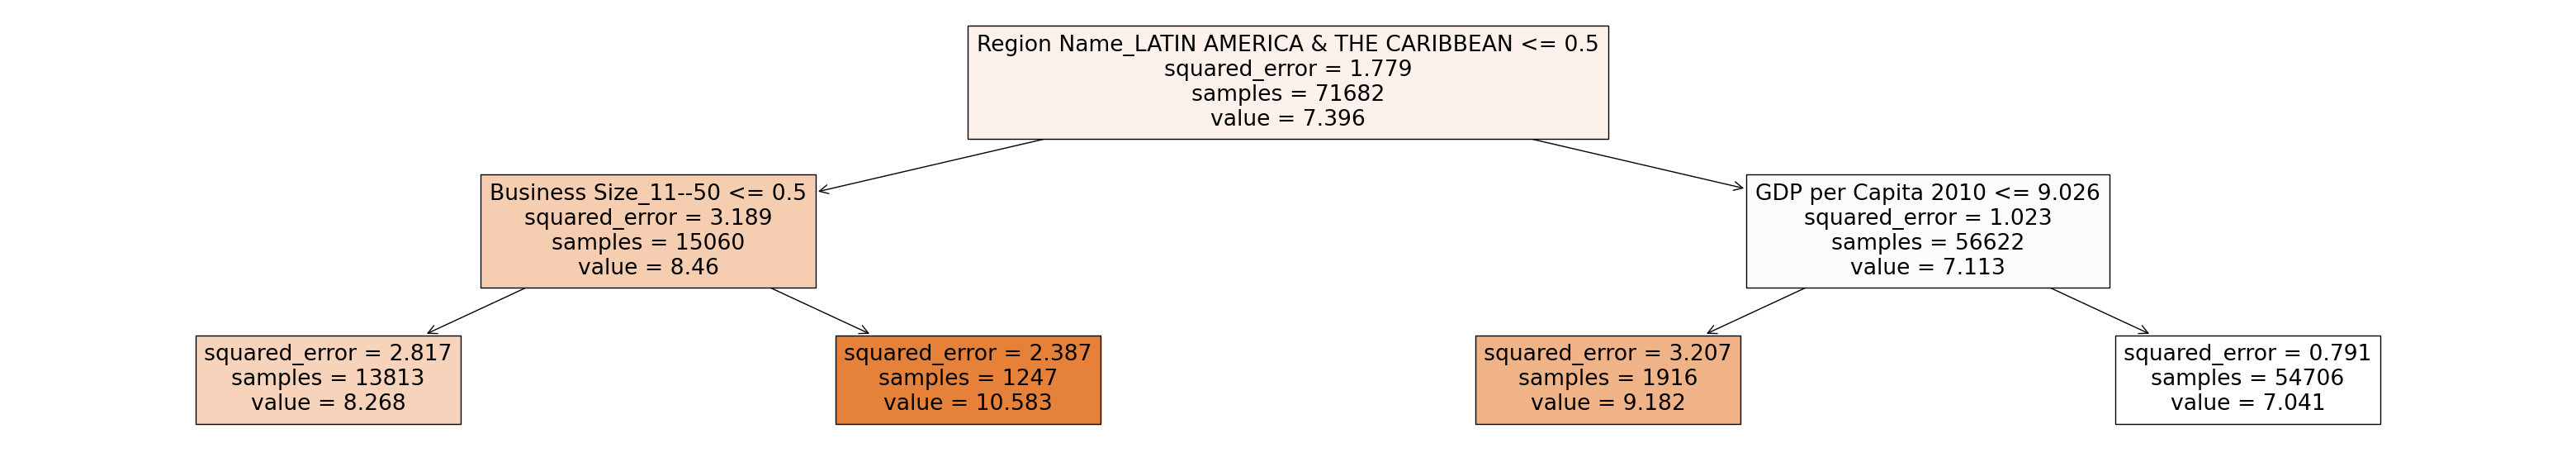

In [116]:
simple_tree = tree.DecisionTreeRegressor(max_depth=2).fit(X,y)
amount_fig = plt.figure(figsize=(40,7))
amount_fig = tree.plot_tree(simple_tree, feature_names=X.columns, filled=True)
y_pred = simple_tree.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Above is the tree we get from regressing our values using a simple tree algorithm described in "Regression Tree Setup." Like our linear regression, the decision tree agrees splitting on the Latin America region is highly predictive of the final loan size. Converted to non-logged terms, loan sizes in Latin America are on average \\$1,200, yet in other regions are on average \\$4,700. This approximately 75% reduction in loan size is in line with previous regressions.

After this split, the tree splits on Businesses with 11-50 employees. Business of this size have much bigger loans than the average of the loans of business of other sizes. Again this is not a surprise and is in line with our previous regressions.

However, it is a surprise to see GDP per Capita in 2010 to be a strong predictor in the right subtree. It seems by splitting on GDP Capita less than 8,300 (9.03) for regions in Latin America is able to split off many outliers which have extremely large loans for the region \\$9,700 (9.18), about 8 times the average for the region.

For such a simple model, the performance is very good with a medium R-squared and a small Mean Squared Error. In fact the R-squared of this model is comparable to our linear regression models!

However, there are already issues that are showing up with this tree. Since we did not prune our tree, and did not split our datasets into training and test datasets, there is a high risk that this tree is over-fitted, and would produce very poor predictions with new data. 

GDP per Capita being such a strong predictor may be a symptom of this problem, since we would not expect this variable to have a strong effect on loan size from previous regressions. The tree at that node is also very "unbalanced," meaning the split to the left has a very small sample (1,916) compared to the the right (54,706). This indicates that this split is targeting a specific anomaly in our dataset, which may not be a true feature given new data.

One way to avoid this issue is to use a Random Forest Algorithm, and split our dataset into a training and test dataset. We did an 80%/20% split on training and test data as shown below.

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The Random Forest Algorithm takes boot-strapped samples (sampling with replacement) of the data, and runs multiple trees on each of these samples. For each split decision of every tree, it only considers a fraction of the available predictors (instead of the entire predictor space) forcing the tree to consider predictors that may not reduce the RSS immediately, but might be important later on. Predictions are made using this tree by taking a "majority vote" of all the trees created by this algorithm. While this is a bit complicated, we can simply use the `RandomForestRegressor` from `sklearn` to implement this algorithm.

In [118]:
# Fit Random Forest to Training Data
regr2 = RandomForestRegressor(max_features=5, random_state=1)
regr2.fit(X_train, y_train)

# Cross Validate our tree on our test dataset
y_pred = regr2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.5931466534149348
R-squared: 0.6603875415900891


Validating it on the test dataset, our model performs extremely well with small MSE and large R-squared!

The main drawback of this algorithm however is because we have created a forest of trees, there is no simple way of visualizing/interpreting our results.

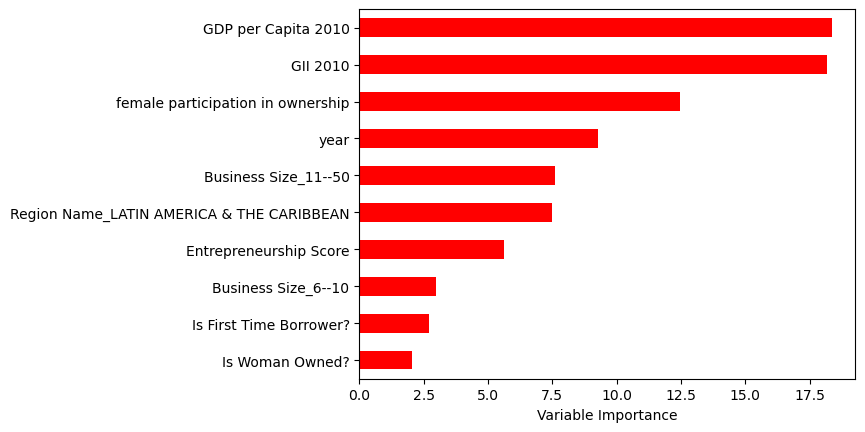

In [119]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).tail(10).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

Above we plotted the top 10 most important variables that our forest is splitting on. 

Immediately, we see some extremely surprising results. The top 4 most important variables the forest splits on are "GDP, GII, Female Participation Rate in Ownership, year", none of which showed up in our previous regressions. This suggests there is a highly non-linear relationship with loan amount and these variables.

However, notice how 3 of these 4 variables are actually national indicators! Combined with our observation in our simple tree, where GDP is used split our a section of outliers in a specific region... it seems like our forest is sneakily using these national indicators to reverse-engineer specific countries! Since these indicators are a unique identifier of a country (e.g. no two countries have the same GDP) it makes sense to instead of using the previously very powerful Region Name dummies, to simply split until we have divided our loans into different countries!

While we cannot definitively prove what is going on in this forest, this is a highly plausible conjecture considering everything we already know.

This result actually has some interesting implications. Recall in the introduction, literature has shown that foreign aid is influenced by political interests and strategy. This tree model, which reveals the importance of the specific country (not just region) on loan size, indicates that perhaps the DCA program is influenced strongly by these political interests. This gives evidence that the size of loans different countries receive is perhaps determined by these political motivations, which vary by country too!

### Excluding Country Indicators

In [120]:
df_regression_dropped = df_regression.drop(['GII 2010', 'GDP per Capita 2010', 'female participation in ownership', 
                                            'Entrepreneurship Score'], axis=1)
X = df_regression_dropped.dropna().iloc[:, 1:]
y = df_regression_dropped.dropna().iloc[:, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Our previous tree models were cheating a little. By factoring in countries, and so potentially the varying levels of political interest they are to the US, the trees were able to make better predictions. The relationship between these country indicators and the political interest to the US is likely extremely non-linear, which explains why our linear models were unable to use these indicators effectively.

But how will our forest models do if we prevent it from using these indicators? Will this model be similar to our linear regression models?

We will used the most advanced Tree algorithm yet to give our model the best chance to make accurate predictions. Gradient Boosted Random Forests, are an improvement to Random Forests since it iteratively creates trees, learning from each previous tree. There are a lot of hyperparameters to tune, so we will implement a grid search algorithm to find good hyperparameters. This can be implemented with the package `GridSearchCV`.

In [121]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune and the range of values to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.5, 0.1, 0.01],
    'min_samples_split': [25, 50, 100]
}

# Create a Gradient Boosting Regressor object
gbr = GradientBoostingRegressor(random_state=42)

# Define the search strategy and perform hyperparameter tuning using grid search
gbr_grid = GridSearchCV(gbr, param_grid, cv=5, n_jobs=-1, verbose=1)
gbr_grid.fit(X_train, y_train)

# Evaluate the performance of the best model on the test data
gbr_grid_best = gbr_grid.best_estimator_
y_pred = gbr_grid_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Best Parameters:", gbr_grid.best_params_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_split': 50, 'n_estimators': 200}
Mean Squared Error: 1.0318341460124738
R-squared: 0.4885452708629061


This algorithm works by testing each combination of the hyperparameters we have specified to test.
- `n_estimators` is the number of trees we want in our forest
- `nax_depth` is the maximum depth of each tree we create
- `learning_rate` is related to how fast the algorithm optimizes/learns
- `min_samples_split` is the minimum number of samples a leaf can have

There parameters are reasonable guesses of the optimal parameters for our dataset, given the computational power we have.

Even with our better algorithm, since we dropped country indicators, we have a lower R-squared and higher MSE compared to previous forests. However, compared to our linear models, this is much better!

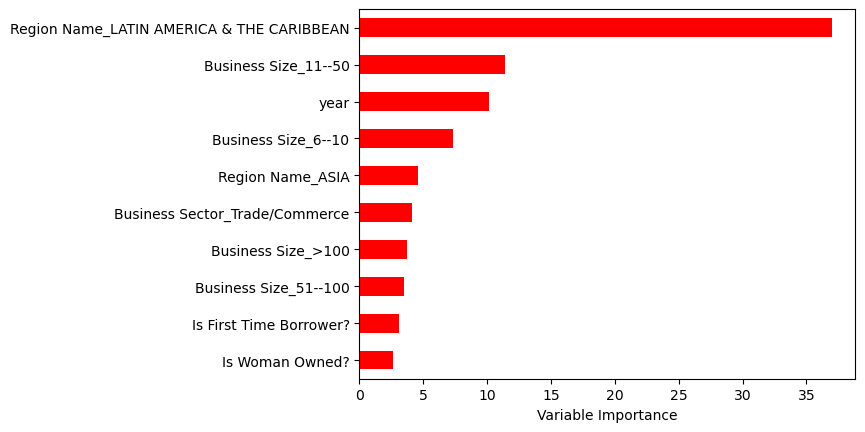

In [122]:
Importance = pd.DataFrame({'Importance':gbr_grid_best.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).tail(10).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

Above we plotted the importance of each variable in our forest. The importance of our variables seems to align much more closely to our previous linear regressions. Region dummies such as Latin America and Asia, and business sizes are very important predictors, as well as some business sectors. The Is Woman Owned? parameter appears 10th on our variable importance list, but it was the 7th variable using forward selection in regressions.

Again, it year appears as a very important parameter that our linear regression model did not pick up on. Year probably was a very non-linear parameter.

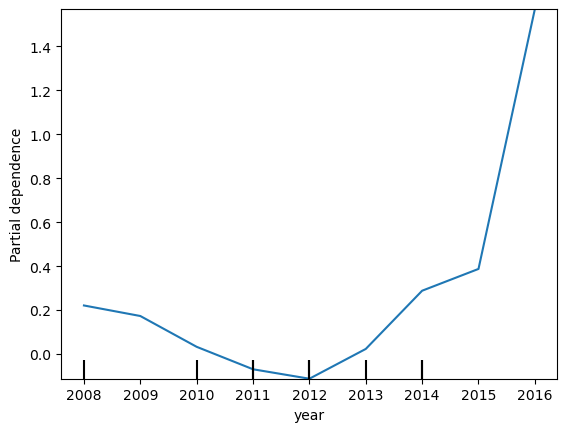

In [123]:
plt = PartialDependenceDisplay.from_estimator(gbr_grid_best, X_train, ['year'], feature_names=X_train.columns)

This plot above displays the partial dependence of the year parameter. The partial dependence plot shows how the predicted outcome (Log Loan Amount (USD)) is affected by the parameter (year) holding all other variables fixed at average levels. This is a common way to better understand how our forest model is making predictions, but the interpretation can sometimes be hazardous. Since forests are able to capture non-linearities/interactions in our data, "holding all other variables fixed at average levels" is a dangerous assumption, since the variable of interest could have a non-linear interaction with the other variables!

Since we have included Is Woman Owned? data, we only have data from 2008-2016. Loan amounts seem to have peaked on average in 2015 and 2016, and stayed roughly the same from 2008-2014, which match our previous plots of loan size over time in the DCA program. Notice how non-linear this plot is, which explains why our linear regression was unable to utilize this variable effectively.

In [124]:
variables = ['Region Name_LATIN AMERICA & THE CARIBBEAN', 'Business Size_11--50', 'Business Size_6--10', 'Business Size_>100', 'Business Size_51--100', 'Region Name_ASIA', 'Is Woman Owned?']

partial_dependence_data = []

for var in variables:
    values = partial_dependence(gbr_grid_best, X_train, [var], kind='average')
    value_0 = values['average'][0][0]
    value_1 = values['average'][0][1]
    partial_dependence_data.append([value_0, value_1, value_1 - value_0])

# Create a dataframe to display the partial dependence values in a table format
partial_dependence_table = pd.DataFrame(partial_dependence_data, columns=['0', '1', 'difference'], index=variables)
partial_dependence_table['converted to percent'] = (np.exp(partial_dependence_table['difference']) - 1) * 100
partial_dependence_table

0         1  difference  \
Region Name_LATIN AMERICA & THE CARIBBEAN  1.170014 -0.288074   -1.458088   
Business Size_11--50                      -0.049330  1.782380    1.831711   
Business Size_6--10                       -0.029308  2.069537    2.098844   
Business Size_>100                        -0.006926  3.724539    3.731465   
Business Size_51--100                     -0.007824  2.558998    2.566822   
Region Name_ASIA                           0.053892 -0.024905   -0.078797   
Is Woman Owned?                            0.096489 -0.202406   -0.298895   

                                           converted to percent  
Region Name_LATIN AMERICA & THE CARIBBEAN            -76.731929  
Business Size_11--50                                 524.456101  
Business Size_6--10                                  715.673857  
Business Size_>100                                  4074.023019  
Business Size_51--100                               1202.436482  
Region Name_ASIA                                      -7.577289  
Is Woman Owned?                                      -25.836285

A similar partial dependence plot can be created for our dummy variables, but since there are only two points 0 and 1, they would all be uninteresting plots of lines of various slopes. Instead, we summarize these plots in this table.

- Column 0 is the partial dependence plot at 0 (when loan does not satisfy dummy variable)
- Column 1 is the partial dependence plot at 1 (when loan does satisfy dummy variable)
- Difference is Column 1 - Column 0. Intuitively, it measures the average effect of satisfying the dummy variable on log of loan size
- Converted to percent is converting the previous difference with our formula

Before we interpret these, results, we want to emphasize another warning about using partial dependence plots. Since essentially we are linearizing the forest's predictions, this is not a true representation of how the forest makes predictions. This is just how the forest predicts on average.

The upside is that these results are highly interpretable, and thus can be compared to our previous regression results. Remarkably, all our results are in line with our regressions, especially being a woman owned business has a -26% effect on loan size on average. There is a more muted effect of having a business with more than 100 employees compared to our OLS regression.

### Excluding Women Owned & Country Indicators

Like in OLS regression, we had to drop over half our data to include data for "Is Woman Owned? and "Is First Time Borrower?" parameters. We will remove these variables, allow us to use the majority our observations again!

In [125]:
df_regression_dropped = df_regression.drop(['GII 2010', 'GDP per Capita 2010', 'female participation in ownership', 
                                            'Entrepreneurship Score', 'Is First Time Borrower?', 'Is Woman Owned?'], axis=1)
X = df_regression_dropped.dropna().iloc[:, 1:]
y = df_regression_dropped.dropna().iloc[:, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
# Define the hyperparameters to tune and the range of values to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7, 9, 11],
    'learning_rate': [0.2, 0.1, 0.05],
    'min_samples_split': [50, 100, 200]
}

# Create a Gradient Boosting Regressor object
gbr = GradientBoostingRegressor(random_state=42)

# Define the search strategy and perform hyperparameter tuning using grid search
gbr_grid = GridSearchCV(gbr, param_grid, cv=5, n_jobs=-1, verbose=1)
gbr_grid.fit(X_train, y_train)

# Evaluate the performance of the best model on the test data
gbr_grid_best2 = gbr_grid.best_estimator_
y_pred = gbr_grid_best2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Best Parameters:", gbr_grid.best_params_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 11, 'min_samples_split': 50, 'n_estimators': 100}
Mean Squared Error: 0.9757947622970978
R-squared: 0.48517454389506864


We used a similar grid search technique to tune our hyperparameters. Since we have a lot more data, we increased `min_samples_split` and increased the allowable `max_depth` of our trees. Cross validating on our test data, we have achieved an model with low MSE and almost twice the R-squared value as our linear Regression Model (0.28). 

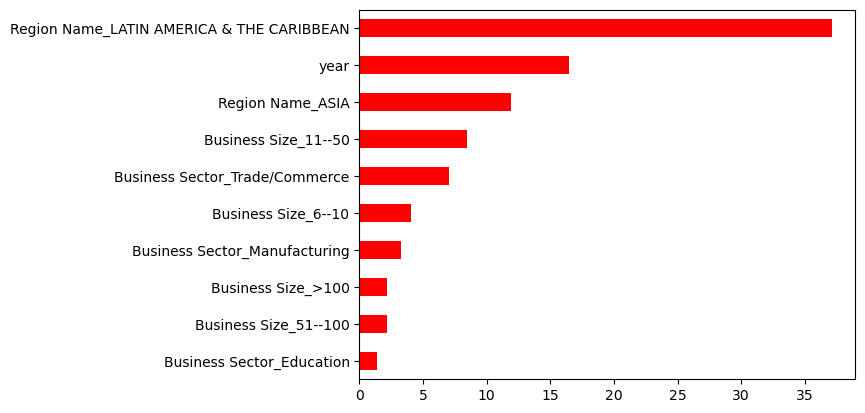

In [145]:
Importance = pd.DataFrame({'Importance': gbr_grid_best2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).tail(10).plot(kind='barh', color='r', legend = False)
l = ax.set_xlabel('Variable Importance')

Above we plotted the importance of each variable in our forest. The importance of our variables seems to again align closely to our previous linear regressions. Region dummies such as Latin America and Asia, and business sizes are very important predictors, as well as some business sectors.

Again, it year appears as a very important parameter that our linear regression model did not pick up on. Year is a very non-linear parameter.

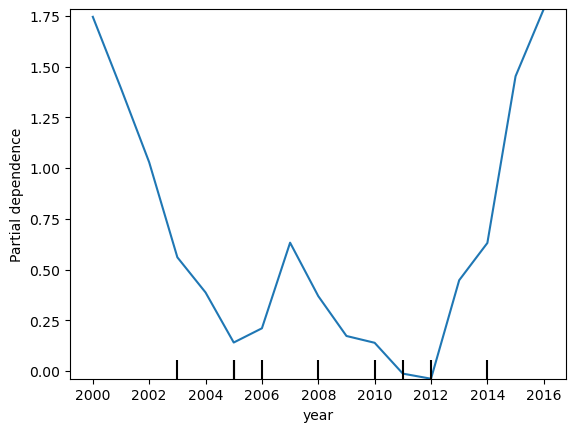

In [146]:
plt = PartialDependenceDisplay.from_estimator(gbr_grid_best2, X_train, ['year'], feature_names=X_train.columns)

Since we have not dropped data prior to 2008 (because we excluded Is Woman Owned? etc.), we see the full picture of how our model treats the year in the partial dependence plot. It is a very nonlinear relationship.

In [147]:
variables = ['Region Name_LATIN AMERICA & THE CARIBBEAN', 'Region Name_ASIA', 'Business Sector_Trade/Commerce', 'Business Size_11--50', 'Business Size_6--10', 'Business Size_>100', 'Business Size_51--100']

partial_dependence_data = []

for var in variables:
    values = partial_dependence(gbr_grid_best2, X_train, [var], kind='average')
    value_0 = values['average'][0][0]
    value_1 = values['average'][0][1]
    partial_dependence_data.append([value_0, value_1, value_1 - value_0])

# Create a dataframe to display the partial dependence values in a table format
partial_dependence_table = pd.DataFrame(partial_dependence_data, columns=['0', '1', 'difference'], index=variables)
partial_dependence_table['converted to percent'] = (np.exp(partial_dependence_table['difference']) - 1) * 100
partial_dependence_table

0         1  difference  \
Region Name_LATIN AMERICA & THE CARIBBEAN  1.158962 -0.278700   -1.437661   
Region Name_ASIA                           0.130309 -0.141081   -0.271390   
Business Sector_Trade/Commerce             0.180569 -0.111401   -0.291970   
Business Size_11--50                      -0.027887  2.304229    2.332117   
Business Size_6--10                       -0.015766  1.852614    1.868379   
Business Size_>100                        -0.003933  2.707360    2.711293   
Business Size_51--100                     -0.004599  2.302368    2.306967   

                                           converted to percent  
Region Name_LATIN AMERICA & THE CARIBBEAN            -76.251749  
Region Name_ASIA                                     -23.768092  
Business Sector_Trade/Commerce                       -25.320891  
Business Size_11--50                                 929.971871  
Business Size_6--10                                  547.779056  
Business Size_>100                                  1404.872150  
Business Size_51--100                                904.391543

In the final table of this project, we summarize the partial dependence plots of our dummy variables. Compared to our linear regressions, these values closely align with our regression results. For example, a business in Latin America on average receives -76% smaller loans, which is similar to our -73% achieved with the `Corrected Top 7` specification in our OLS regression. Surprisingly, the effect of business size for businesses with more than 51 employees is significantly reduced compared to our OLS models. For example, the forest model estimates that a business with more than 100 employees receives 14 times bigger loans, but was estimated as 108 times bigger in our OLS model. Likely this is due to the fact of many non-linear interactions that mute this effect.

## Conclusion

The data shows that the region, business size and sector, and the gender of the entrepreneur have significant effects on the final loan amount received by the borrower. Using OLS multiple regression models, we estimated these precise effects while controlling for other variables, and corroborated these results using state-of-the-art machine learning methods. From these results, we identified obvious improvements to the DCA program in the facets of 1. Reducing the influences of politics, 2. Stronger assessment of if DCA backed loans are going to businesses that would not have otherwise, and most importantly, 3. Increasing loans and loan amounts to women entrepreneurs.

Latin America \& The Caribbean are favoured heavily by the DCA in terms of loan frequency, however, receive approximately 75\% smaller loans than Africa (Regression: -73.27\%, ML: -76.25\%). Our machine learning model also detected high variability predicated by national indicators, indicating there are high discrepancies determined by nationality. This gives evidence of political conflicts of interest as identified in the literature (See Section 2.4). Unfortunately, this means that these political influences may be reducing the potential effectiveness of the DCA program. Ideally, the program should be operating from a humanitarian perspective to maximize positive impact, regardless of country. Perhaps this is too much to ask for a program funded by the U.S. Government.

Our regressions estimate that the effects of business size on loan size are substantial. Compared to businesses with 1-5 employees, our regression model pins the effect as approximately 5.5 times bigger loans for businesses for 6-10 employees, 9 times for 11-50 employees, 48 times for 51-100 employees, and 108 times for $>$100 employees. This is not a surprising result and aligns with standard economic theory that larger businesses need more capital investment. We also found that very small businesses (1-5 employees), were heavily favoured by the DCA program (86.2 \%) of all loan transactions, yet the majority of loan dollars went to larger businesses. It is hard to read too much into this result without better measures of whether the loan is going to a business that would not have gotten a loan otherwise. Would the banks have given these large loans to bigger businesses without the DCA? Or are banks simply taking advantage of the program to reduce their own liability?

Business Sector has a highly variable impact on loan size, as expected since different sectors have different business needs. However, our regression and machine learning models show that in general, these are not very strong predictors of loan size ($R^2 < 0.04$ for the regression). Trade/Commerce is the exception (2nd most frequent loan), with predicted to receive 36.5\% smaller loans compared to Agriculture, which is the most frequent loan type, and also tends to receive smaller loans.

First time borrowers made up a slight majority of loans in the DCA program (54.7\%). For a program specifically targeted to businesses underserved by banks, this is perhaps an underwhelming number. The DCA program should have a stronger criterion for evaluating whether along is going to a business that would not have gotten on otherwise. Positively, there is a negligible ($<$1\%) difference in loan sizes between first time borrowers and former borrowers for comparable businesses.

Finally, the primary focus of this paper was uncovering the Gender Loan Gap (See 4.5.2 for definition). Not only does the DCA program give loans at a rate to women below the rate of women owned businesses for three-quarters of the countries in the program (Figure 9), the loans women receive are significantly smaller than men. Women rarely get loans larger than \$5,000, and the larger the loan, the less likely it is to go to a woman (Figure 10). So although 32\% of loans are to women in the program, only 9\% of loan dollars go to women (Figure 11). Controlling for relevant factors such as region, business size, business sector, and year, still, yields that for businesses that are comparable in these dimensions, women owned businesses receive 26\% smaller loans than men owned businesses (ML: -25.84\%, Regression -27.33\%). 

The World Bank and other sources have extensively studied the importance of women entrepreneurs for sustainable development, and a USAID report has admitted that barriers do exist for women entrepreneurs, and "Promoting financial services
to women is an important factor in improving women’s access to entrepreneurship" (World Bank, 2012; Jazouli et al., 2020). It is disappointing there is no evidence that the DCA program is following through with these facts and is giving loans to women at a below status-quo rate and amount. Future programs in foreign aid and development need to emphasize keeping track of statistics for women and be held accountable for promoting gender equality.

## References

Akhtar, S. and N. Brown (2022, January). U.S. International Development Finance Corporation: Overview
and Issues. Technical report, Congressional Research Service.

Alesina, A. and D. Dollar (2000, March). Who Gives Foreign Aid to Whom and Why? Journal of Economic
Growth 5(1), 33–63.

Andrzejewski, A. (2021, August). New Report: Nearly \$300 Billion In Foreign Aid Spent By U.S. Government. Section: Policy.

Banerjee, A. and E. Duflo (2012). Poor Economics. PublicAffairs.

Bawaba, A. (2014, September). Development Credit Authority. SyndiGate Media Inc., 1. Publisher:
Albawaba (London) Ltd.

Jazouli, A., R. Akerbib, F. Mouline, D. L. Bernard, S. W. Bordat, and S. Kouzzi (2020, November).
USAID/Morocco Gender Analysis Final Report 2020. Technical report, TALM/MRA Mobilising for
Rights Associates.

Marr, A. (2012). Effectiveness of Rural Microfinance: What We Know and What We Need to Know. Journal
of Agrarian Change 12(4), 555–563. eprint: https://onlinelibrary.wiley.com/doi/pdf/10.1111/j.1471-0366.2012.00373.x.

Sajjad, M., N. Kaleem, M. I. Chani, and M. Ahmed (2020, January). Worldwide role of women entrepreneurs
in economic development. Asia Pacific Journal of Innovation and Entrepreneurship 14(2), 151–160.
Publisher: Emerald Publishing Limited.

Tarnoff, C. (2017, July). U.S. Foreign Assistance: USAID Loan Guarantees. Congressional Research
Service 1(5), 1–2.

United Nations, n. (2023). Gender Inequality Index. Technical report, United Nations, n/a. Publication Title:
Human Development Reports

USAID (2019, March). Development Credit Authority (DCA) Data Set: Loan Transactions | Development
Data Library.

USAID (2022, December). DCA Loan Dataset.

USAID Video (2012, February). Development Credit Authority and Sustainability.

Westover, J. (2008, January). The Record of Microfinance: The Effectiveness/Ineffectiveness of Microfinance
Programs as a Means of Alleviating Poverty. Jonathan H. Westover 12.

World Bank, n. (2012). World Development Report 2012. World Bank, n/a.

World Bank, n. (2018). GDP per capita, PPP (constant 2017 international $) | Data.

World Bank, n. (2022a). Firms with female participation in ownership (% of firms) | Data.

World Bank, n. (2022b, November). Poverty Overview.

World Bank, n. (2023). Women, Business and the Law Entrepreneurship Indicator